# 1 Deep Learning on Tabular Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold,train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt

To start we first have to preprocess the data by scaling it encoding it and then applying the model with the embedding.<br>
So in order to do this we define a class named preprocess data that handles all the data preprocessing part which makes the model more dynamic

In [2]:
class Preprocess:
    #We define a constructor that takes the data to be read, train and test indeces which will be passed during the K fold
    #categorical columns to be encoded and embedded, continuous columns to be scaled and finally the target column to be
    #predicted
    def __init__(self,dataset,cat_cols,cont_cols,train_indeces,test_indeces,target_col):
#         self.cat_cols = cat_cols
#         self.cont_cols = cont_cols
#         self.train_indeces=train_indeces
#         self.test_indeces=test_indeces
#         self.target_col = target_col #Initialize the target column
#         self.dataset= dataset ##Load the dataset
#         self.cat_dict = self.get_cat_dict() #Initialize categorical features with their embeddings
#         self.train = self.process_data(train_indeces) #Initialize the train set with respective kfold indeces
#         self.test = self.process_data(test_indeces) #Initialize the test set with respective kfold indeces
        self.dataset = dataset
        self.cat_cols = cat_cols
        self.cont_cols = cont_cols
        self.train_indeces = train_indeces
        self.test_indeces = test_indeces 
        self.target_col = target_col
        self.cat_dict = self.get_cat_dict()
        self.train = self.process_data(train_indeces)
        self.test = self.process_data(test_indeces)
    
    def get_cat_dict(self):
        cat_dict= {}
        for col in self.cat_cols:
            #Getting the categorical columns of data
            cat_col= self.dataset[col].astype('category')
            #Assign for each categorical column a number ranging from [0,n-1] where n is the cardinality of the column
            cat_dict[col] = {cat_val:idx for idx,cat_val in enumerate(cat_col.cat.categories)}
        return cat_dict
    
    def process_data(self,index):
        #In this step we scale the data first, map the category of the dataset in the dataset column which is basically
        #encoding the features and finally encoding the target variable
        
        #Scaling continous columns
        data_copied = self.dataset.copy()
        data_copied=data_copied.iloc[index,:]
        scaler = StandardScaler()
        
        data_copied[self.cont_cols] = scaler.fit_transform(data_copied[self.cont_cols])
        data_copied[self.cont_cols] = data_copied[self.cont_cols].astype(np.float32)
        
        #Encoding categorical columns
        for col in self.cat_cols:
            code_dict = self.cat_dict[col]
            data_copied[col] = data_copied[col].map(code_dict).astype(np.int64)
        #Encoding target variable
        data_copied[self.target_col] = data_copied[self.target_col].map({"no": 0, "yes":1}).astype(np.int64)
        
        return data_copied
        
        
        
        
    

After defining the preprocess class now we have the data preprocessed we will initialize the tabular class which will help taking the data as batches 

In [3]:
class TabularDataset(Dataset):  
    #In this class we initialize the categorical, continuous columns and the target column to be taken in the batch
    #along with the dataset as a part to be divided to certain batches
    def __init__(self, dataset, cat_cols,cont_cols,target_col):        
        self.cat_cols = cat_cols
        self.cont_cols = cont_cols
        self.target_col = target_col
        self.dataset = dataset
    #Gets the length for the dataset 
    def __len__(self):
        return self.dataset.shape[0]
    #Calculates the categorical,continous and target columns from the categorical columns, continous columns and target
    #columns of the whole dataset with a certain index idx
    def __getitem__(self, idx):
        cat_array = self.dataset[self.cat_cols].iloc[idx].to_numpy()
        cont_array = self.dataset[self.cont_cols].iloc[idx].to_numpy()
        target_array = self.dataset[self.target_col].iloc[idx]
        cat_array = torch.LongTensor(cat_array)
        cont_array = torch.FloatTensor(cont_array)
        
        return cat_array, cont_array, target_array

Now the data is divided into preprocessed batches and ready to be passed to our model.

In this class we define our model parameters and the methods to apply later our model

In [4]:
class NN_model(nn.Module):
    #Initialize the categorical dictionary columns that contains each categorical columns with their encoded values,
    #categorical columns, continous columns, target column and the embeddings vector which will have a dimension that
    #is considered as a hyperparameter and the layers which consists of a stack of Linear layers and ReLUs.
    def __init__(self,cat_dict,cat_cols,cont_cols):
        super().__init__()
        self.cat_dict = cat_dict
        self.cat_cols = cat_cols 
        self.cont_cols = cont_cols  
        self.embeddings = self.create_embedding_vectors() #Initialize embedding vector
        self.in_features = self.total_embed_dim+ len(cont_cols) #Initialize the input features of the embeddings applied
        self.layers = nn.Sequential(
            nn.Linear(self.in_features,64),
            nn.ReLU(),
            nn.Linear(64,16),
            nn.ReLU(),
            nn.Linear(16,1)       
        )
    #In this function we create an embedding vectors for each categorical value in the columns and return the model
    #with the dimensions embedded for the categorical features
    def create_embedding_vectors(self):
        #Dictionary of embeddings to map the cardinality in each category
        embedding_size_dict = {cat_val:len(dict) for cat_val,dict in self.cat_dict.items()}
        #Build a dictionary to map the dimension of option vectors per category
        #It's usually taken as a dimension of the minumum 
        embedding_dim_dict = { cat_val:min(50,options//2) for cat_val,options in embedding_size_dict.items()}
        
        embeddings = {}
        self.total_embed_dim = 0
        for col in self.cat_cols:
            #Calculate the number of levels for each categorical feature
            num_embeddings =embedding_size_dict[col]
            
            #Calculate the number of dimensions representing the categorical feature
            embedding_dim =embedding_dim_dict[col]
            embeddings[col] = nn.Embedding(num_embeddings, embedding_dim)
            self.total_embed_dim+= embedding_dim
        return nn.ModuleDict(embeddings)
    
    #In this function we get the embeddings of each categorical column and then calculate the outputs till reaching
    #the total layers
    def forward(self,cat_tensor,num_tensor):
        embeddings_total_outputs = []
        for idx,cat_col in enumerate(self.cat_cols):
            embedding_layer = self.embeddings[cat_col] #Embeddings for each category
            cat_input = cat_tensor[:, idx] #Initialzing a categorical tensor ranging to a certain index of the batch
            embedding_output = embedding_layer(cat_input) #Pass the categoical encoded to the layer for a vectorized
                                                          #representation
            embeddings_total_outputs.append(embedding_output)#This represents a vector of 1 category
        #Concatenate each vector to form an embedding matrix
        embedding_tensor = torch.cat(embeddings_total_outputs, dim=1)
        concat_tensor = torch.cat((embedding_tensor, num_tensor), dim=1)
        
        return self.layers(concat_tensor)
    

Now we define the training class in which we train the model and predict the output

In [5]:
#In this class we initialize the training model that takes the dataset, categorical,continous and target column,
#the number of folds which is a hyperparameter, the number of epochs and the learning rate for the optimizer
class model_training:
    def __init__(self,data,cat_cols,cont_cols,target_col,k_fold,num_epochs,learning_rate=0.01,random_state=None):
        self.cat_cols = cat_cols
        self.cont_cols = cont_cols
        self.target_col = target_col
        self.data = data
        self.k_fold = k_fold
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.random_state = random_state
    #In the training function we will preprocess the data for each fold, apply the model then train it
    def train_model(self):
        score=[] #Initialize the score array to have a history of the scores for each fold in order to decide the
                 #hyperparameter k
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        folds=KFold(n_splits=self.k_fold, shuffle=True)
        for i, (train_indeces,test_indeces) in enumerate(folds.split(data)):
            print("In fold",i)
            dataset = Preprocess(data,categorical_cols,continuous_cols,train_indeces,test_indeces, target_col)
            #Passing the dataset processed to the tabular dataset class 
            train_dataset = TabularDataset(dataset.train, categorical_cols, continuous_cols, target_col)
            test_dataset = TabularDataset(dataset.test, categorical_cols, continuous_cols, target_col)
            #Pass the train and test sets to the dataloader for dividing it into batches
            train_loader = DataLoader(train_dataset, batch_size=16)
#             print("Train loader is",enumerate(train_loader))
            test_loader = DataLoader(test_dataset, batch_size=16)
            #Initialize the model with the dataset and the categorical and continuous columns
            model = NN_model(dataset.cat_dict, categorical_cols, continuous_cols)
            model=model.to(device)
            #Apply the optimizer which can be SGD Adam or any optimizer this is considered as a hyperparameter
            optimizer = torch.optim.Adam(model.parameters(), self.learning_rate)
            train_loss_per_epoch = []
            
            for epoch in range(self.num_epochs):
                curr_loss=0
                for idx, (cat_tensor, cont_tensor, target_array) in enumerate(train_loader):
                    cat_tensor = cat_tensor.to(device)
                    cont_tensor = cont_tensor.to(device)
                    target_array = target_array.to(device)
                    output = model(cat_tensor, cont_tensor)
                    
                    #Applying the loss as a binary cross entropy because it's a classification problem
                    loss = F.binary_cross_entropy_with_logits(output.squeeze(1), target_array.float())
                    
                    #Adjust gradients auto diff
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    curr_loss += loss.item()
                
                train_loss_per_epoch.append(curr_loss / (idx + 1))
                
            print('Train loss for each epoch is {}'.format(train_loss_per_epoch))
            model.eval()
            #Setting the torch with no grad because we don't calculate gradients in the backward propagation
            with torch.no_grad():
                batch_acc = 0
                for idx, (cat_tensor, cont_tensor, target_array) in enumerate(test_loader):
                    #accuracy
                    predicted = model(cat_tensor, cont_tensor)
                    batch_acc += sum((torch.round(predicted.reshape(-1)).eq(target_array)).int())
                
                score.append(batch_acc/dataset.test.shape[0])
        avg_score = sum(score)/self.k_fold
        print('Accuracy of each fold : {}'.format(score))
        print('Avg accuracy : {}'.format(avg_score))
        

In [6]:
categorical_cols = ["job", "marital", "education"]
continuous_cols = ["age", "duration"]
#We chose only these categorical columns because these are the ones that mainly affect the target variable
target_col = "y"

data = pd.read_csv('bank-additional-full.csv', sep=";")

trainer = model_training(data, categorical_cols, continuous_cols, target_col, k_fold=3, num_epochs = 10, learning_rate=0.01,random_state=42)
trainer.train_model()

In fold 0
Train loss for each epoch is [0.2246355723587616, 0.22853929257089486, 0.2273006896164548, 0.2163711137745267, 0.21440232287111693, 0.21352942156603796, 0.214111768623763, 0.21154450247770454, 0.21231309601648704, 0.21231119280483576]
In fold 1
Train loss for each epoch is [0.2177999365359697, 0.2128805191854844, 0.21618541166612057, 0.2198662459982588, 0.22017682318161888, 0.2147798425250567, 0.21231489208190527, 0.21193409767370708, 0.20909249589842394, 0.20900265664192016]
In fold 2
Train loss for each epoch is [0.23002593971145024, 0.21270447201626969, 0.21238671044321114, 0.21154598652644455, 0.21430165273891846, 0.21618013185274162, 0.21550776084936846, 0.21437042179845456, 0.2203386597189229, 0.21619698253433997]
Accuracy of each fold : [tensor(0.2490), tensor(0.2171), tensor(0.1866)]
Avg accuracy : 0.21758687496185303


Reference for this code is in the links https://yashuseth.wordpress.com/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/ and https://hacksforai.blogspot.com/2022/11/how-to-adopt-embeddings-for-categorical-features-part-2.html

In [7]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [8]:
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [9]:
cols_to_be_encoded = []
for i in data.select_dtypes(include='object').columns:
    cols_to_be_encoded.append(i)
target_var='y'

In [10]:
encoder = LabelEncoder()
for i in cols_to_be_encoded:
    data[i]=encoder.fit_transform(data[i]) 

In [11]:
scaler=StandardScaler()
data_without_y=data.drop('y',axis=1)
target_data=data['y']
data_without_y
data_scaled=scaler.fit_transform(data_without_y)
data_scaled


array([[ 1.53303429, -0.20157925, -0.2837415 , ...,  0.88644656,
         0.71245988,  0.33167991],
       [ 1.62899323,  0.91122681, -0.2837415 , ...,  0.88644656,
         0.71245988,  0.33167991],
       [-0.29018564,  0.91122681, -0.2837415 , ...,  0.88644656,
         0.71245988,  0.33167991],
       ...,
       [ 1.53303429,  0.35482378, -0.2837415 , ..., -2.22495344,
        -1.49518647, -2.8156966 ],
       [ 0.38152696,  1.46762984, -0.2837415 , ..., -2.22495344,
        -1.49518647, -2.8156966 ],
       [ 3.26029527,  0.35482378, -0.2837415 , ..., -2.22495344,
        -1.49518647, -2.8156966 ]])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled,target_data.to_numpy(),test_size=0.2)

In [13]:
import catboost as ctb

folds=KFold(n_splits=3, shuffle=True)
num_epochs=10
model=ctb.CatBoostClassifier()

for i,(train_indeces,test_indeces) in enumerate(folds.split(X_train)):
            print("In fold",i)
            X_train_fold, X_test_fold = X_train[train_indeces,:], X_train[test_indeces,:]
            y_train_fold, y_test_fold = y_train[train_indeces], y_train[test_indeces]
            
            score = []
            
            for epoch in range(num_epochs):
                model.fit(X_train_fold,y_train_fold)
                predicted_y = model.predict(X_test_fold)
                score.append(metrics.r2_score(y_test_fold, predicted_y))
            print("Score in each epoch is",score)
                
                
            

In fold 0
Learning rate set to 0.038536
0:	learn: 0.6366301	total: 77.2ms	remaining: 1m 17s
1:	learn: 0.5794269	total: 84.3ms	remaining: 42.1s
2:	learn: 0.5427966	total: 89ms	remaining: 29.6s
3:	learn: 0.5028167	total: 95.7ms	remaining: 23.8s
4:	learn: 0.4667185	total: 103ms	remaining: 20.6s
5:	learn: 0.4371475	total: 110ms	remaining: 18.2s
6:	learn: 0.4112555	total: 116ms	remaining: 16.5s
7:	learn: 0.3879011	total: 122ms	remaining: 15.1s
8:	learn: 0.3682119	total: 127ms	remaining: 14s
9:	learn: 0.3435089	total: 133ms	remaining: 13.2s
10:	learn: 0.3248101	total: 138ms	remaining: 12.4s
11:	learn: 0.3118749	total: 144ms	remaining: 11.9s
12:	learn: 0.2973940	total: 150ms	remaining: 11.4s
13:	learn: 0.2835056	total: 156ms	remaining: 11s
14:	learn: 0.2753929	total: 162ms	remaining: 10.7s
15:	learn: 0.2681528	total: 168ms	remaining: 10.3s
16:	learn: 0.2621390	total: 173ms	remaining: 10s
17:	learn: 0.2560714	total: 179ms	remaining: 9.78s
18:	learn: 0.2516916	total: 184ms	remaining: 9.48s
19:	

184:	learn: 0.1618330	total: 1.47s	remaining: 6.49s
185:	learn: 0.1617731	total: 1.48s	remaining: 6.49s
186:	learn: 0.1616596	total: 1.49s	remaining: 6.49s
187:	learn: 0.1615886	total: 1.5s	remaining: 6.47s
188:	learn: 0.1615564	total: 1.51s	remaining: 6.47s
189:	learn: 0.1614597	total: 1.51s	remaining: 6.45s
190:	learn: 0.1613606	total: 1.52s	remaining: 6.44s
191:	learn: 0.1612697	total: 1.52s	remaining: 6.42s
192:	learn: 0.1612266	total: 1.53s	remaining: 6.41s
193:	learn: 0.1611945	total: 1.54s	remaining: 6.39s
194:	learn: 0.1611093	total: 1.54s	remaining: 6.38s
195:	learn: 0.1610043	total: 1.55s	remaining: 6.37s
196:	learn: 0.1609134	total: 1.56s	remaining: 6.35s
197:	learn: 0.1608656	total: 1.56s	remaining: 6.33s
198:	learn: 0.1607582	total: 1.57s	remaining: 6.32s
199:	learn: 0.1606475	total: 1.57s	remaining: 6.3s
200:	learn: 0.1604385	total: 1.58s	remaining: 6.29s
201:	learn: 0.1602955	total: 1.59s	remaining: 6.28s
202:	learn: 0.1602169	total: 1.6s	remaining: 6.27s
203:	learn: 0.1

346:	learn: 0.1485610	total: 2.46s	remaining: 4.64s
347:	learn: 0.1485258	total: 2.47s	remaining: 4.63s
348:	learn: 0.1485116	total: 2.48s	remaining: 4.63s
349:	learn: 0.1484721	total: 2.48s	remaining: 4.62s
350:	learn: 0.1484631	total: 2.49s	remaining: 4.6s
351:	learn: 0.1484191	total: 2.5s	remaining: 4.6s
352:	learn: 0.1483592	total: 2.5s	remaining: 4.59s
353:	learn: 0.1483304	total: 2.51s	remaining: 4.58s
354:	learn: 0.1483089	total: 2.51s	remaining: 4.57s
355:	learn: 0.1483018	total: 2.52s	remaining: 4.56s
356:	learn: 0.1481608	total: 2.52s	remaining: 4.55s
357:	learn: 0.1481262	total: 2.53s	remaining: 4.54s
358:	learn: 0.1480279	total: 2.54s	remaining: 4.53s
359:	learn: 0.1479689	total: 2.54s	remaining: 4.52s
360:	learn: 0.1479066	total: 2.55s	remaining: 4.51s
361:	learn: 0.1478689	total: 2.55s	remaining: 4.5s
362:	learn: 0.1478578	total: 2.56s	remaining: 4.49s
363:	learn: 0.1478215	total: 2.56s	remaining: 4.48s
364:	learn: 0.1477390	total: 2.57s	remaining: 4.47s
365:	learn: 0.147

514:	learn: 0.1388206	total: 3.45s	remaining: 3.25s
515:	learn: 0.1387808	total: 3.45s	remaining: 3.24s
516:	learn: 0.1387631	total: 3.46s	remaining: 3.23s
517:	learn: 0.1387401	total: 3.47s	remaining: 3.23s
518:	learn: 0.1387258	total: 3.48s	remaining: 3.22s
519:	learn: 0.1386731	total: 3.48s	remaining: 3.21s
520:	learn: 0.1385663	total: 3.49s	remaining: 3.21s
521:	learn: 0.1385197	total: 3.49s	remaining: 3.2s
522:	learn: 0.1385181	total: 3.5s	remaining: 3.19s
523:	learn: 0.1384531	total: 3.5s	remaining: 3.18s
524:	learn: 0.1384339	total: 3.51s	remaining: 3.18s
525:	learn: 0.1383503	total: 3.52s	remaining: 3.17s
526:	learn: 0.1383235	total: 3.52s	remaining: 3.16s
527:	learn: 0.1383046	total: 3.53s	remaining: 3.15s
528:	learn: 0.1383000	total: 3.53s	remaining: 3.15s
529:	learn: 0.1382140	total: 3.54s	remaining: 3.14s
530:	learn: 0.1381647	total: 3.55s	remaining: 3.13s
531:	learn: 0.1381632	total: 3.55s	remaining: 3.12s
532:	learn: 0.1381375	total: 3.56s	remaining: 3.12s
533:	learn: 0.1

703:	learn: 0.1295853	total: 4.62s	remaining: 1.94s
704:	learn: 0.1295276	total: 4.63s	remaining: 1.94s
705:	learn: 0.1295141	total: 4.64s	remaining: 1.93s
706:	learn: 0.1294997	total: 4.65s	remaining: 1.93s
707:	learn: 0.1294940	total: 4.65s	remaining: 1.92s
708:	learn: 0.1294482	total: 4.66s	remaining: 1.91s
709:	learn: 0.1293929	total: 4.66s	remaining: 1.9s
710:	learn: 0.1293634	total: 4.67s	remaining: 1.9s
711:	learn: 0.1293580	total: 4.67s	remaining: 1.89s
712:	learn: 0.1293387	total: 4.68s	remaining: 1.88s
713:	learn: 0.1292903	total: 4.68s	remaining: 1.88s
714:	learn: 0.1292309	total: 4.69s	remaining: 1.87s
715:	learn: 0.1291907	total: 4.7s	remaining: 1.86s
716:	learn: 0.1291870	total: 4.7s	remaining: 1.85s
717:	learn: 0.1291191	total: 4.71s	remaining: 1.85s
718:	learn: 0.1290806	total: 4.71s	remaining: 1.84s
719:	learn: 0.1290289	total: 4.72s	remaining: 1.83s
720:	learn: 0.1289919	total: 4.72s	remaining: 1.83s
721:	learn: 0.1289573	total: 4.73s	remaining: 1.82s
722:	learn: 0.12

870:	learn: 0.1220932	total: 5.6s	remaining: 830ms
871:	learn: 0.1220567	total: 5.61s	remaining: 824ms
872:	learn: 0.1220088	total: 5.62s	remaining: 817ms
873:	learn: 0.1219597	total: 5.63s	remaining: 811ms
874:	learn: 0.1219289	total: 5.63s	remaining: 805ms
875:	learn: 0.1218837	total: 5.64s	remaining: 798ms
876:	learn: 0.1218832	total: 5.64s	remaining: 791ms
877:	learn: 0.1218553	total: 5.65s	remaining: 785ms
878:	learn: 0.1218312	total: 5.65s	remaining: 778ms
879:	learn: 0.1217678	total: 5.66s	remaining: 772ms
880:	learn: 0.1216935	total: 5.66s	remaining: 765ms
881:	learn: 0.1216408	total: 5.67s	remaining: 759ms
882:	learn: 0.1215631	total: 5.68s	remaining: 752ms
883:	learn: 0.1215323	total: 5.68s	remaining: 746ms
884:	learn: 0.1214908	total: 5.69s	remaining: 739ms
885:	learn: 0.1214039	total: 5.69s	remaining: 733ms
886:	learn: 0.1213702	total: 5.7s	remaining: 726ms
887:	learn: 0.1213394	total: 5.7s	remaining: 719ms
888:	learn: 0.1213094	total: 5.71s	remaining: 713ms
889:	learn: 0.1

51:	learn: 0.1878953	total: 383ms	remaining: 6.99s
52:	learn: 0.1874698	total: 392ms	remaining: 7s
53:	learn: 0.1870547	total: 401ms	remaining: 7.02s
54:	learn: 0.1866744	total: 407ms	remaining: 6.99s
55:	learn: 0.1863093	total: 413ms	remaining: 6.96s
56:	learn: 0.1857524	total: 420ms	remaining: 6.95s
57:	learn: 0.1853599	total: 427ms	remaining: 6.93s
58:	learn: 0.1848922	total: 433ms	remaining: 6.91s
59:	learn: 0.1839254	total: 439ms	remaining: 6.88s
60:	learn: 0.1835431	total: 445ms	remaining: 6.85s
61:	learn: 0.1830474	total: 451ms	remaining: 6.83s
62:	learn: 0.1827291	total: 458ms	remaining: 6.81s
63:	learn: 0.1822956	total: 464ms	remaining: 6.78s
64:	learn: 0.1817038	total: 470ms	remaining: 6.76s
65:	learn: 0.1814865	total: 479ms	remaining: 6.77s
66:	learn: 0.1810841	total: 488ms	remaining: 6.8s
67:	learn: 0.1806240	total: 498ms	remaining: 6.82s
68:	learn: 0.1801499	total: 506ms	remaining: 6.82s
69:	learn: 0.1798841	total: 514ms	remaining: 6.83s
70:	learn: 0.1795742	total: 526ms	r

229:	learn: 0.1577380	total: 1.56s	remaining: 5.23s
230:	learn: 0.1576604	total: 1.57s	remaining: 5.22s
231:	learn: 0.1574805	total: 1.58s	remaining: 5.22s
232:	learn: 0.1573969	total: 1.58s	remaining: 5.21s
233:	learn: 0.1573271	total: 1.59s	remaining: 5.21s
234:	learn: 0.1572043	total: 1.6s	remaining: 5.2s
235:	learn: 0.1571482	total: 1.6s	remaining: 5.19s
236:	learn: 0.1569832	total: 1.61s	remaining: 5.18s
237:	learn: 0.1569041	total: 1.62s	remaining: 5.17s
238:	learn: 0.1568163	total: 1.62s	remaining: 5.16s
239:	learn: 0.1567129	total: 1.63s	remaining: 5.16s
240:	learn: 0.1566760	total: 1.63s	remaining: 5.15s
241:	learn: 0.1565531	total: 1.64s	remaining: 5.14s
242:	learn: 0.1564025	total: 1.65s	remaining: 5.13s
243:	learn: 0.1562939	total: 1.65s	remaining: 5.12s
244:	learn: 0.1562274	total: 1.66s	remaining: 5.11s
245:	learn: 0.1561730	total: 1.66s	remaining: 5.1s
246:	learn: 0.1560377	total: 1.67s	remaining: 5.09s
247:	learn: 0.1559800	total: 1.68s	remaining: 5.08s
248:	learn: 0.15

414:	learn: 0.1445468	total: 2.75s	remaining: 3.87s
415:	learn: 0.1444496	total: 2.75s	remaining: 3.87s
416:	learn: 0.1443403	total: 2.76s	remaining: 3.86s
417:	learn: 0.1442800	total: 2.77s	remaining: 3.85s
418:	learn: 0.1442425	total: 2.77s	remaining: 3.84s
419:	learn: 0.1441589	total: 2.78s	remaining: 3.84s
420:	learn: 0.1440796	total: 2.79s	remaining: 3.83s
421:	learn: 0.1439760	total: 2.79s	remaining: 3.82s
422:	learn: 0.1438955	total: 2.8s	remaining: 3.81s
423:	learn: 0.1438212	total: 2.8s	remaining: 3.81s
424:	learn: 0.1437789	total: 2.81s	remaining: 3.8s
425:	learn: 0.1437520	total: 2.81s	remaining: 3.79s
426:	learn: 0.1437340	total: 2.82s	remaining: 3.78s
427:	learn: 0.1437010	total: 2.82s	remaining: 3.77s
428:	learn: 0.1436239	total: 2.83s	remaining: 3.77s
429:	learn: 0.1435693	total: 2.83s	remaining: 3.76s
430:	learn: 0.1434845	total: 2.84s	remaining: 3.75s
431:	learn: 0.1433975	total: 2.85s	remaining: 3.74s
432:	learn: 0.1433450	total: 2.85s	remaining: 3.73s
433:	learn: 0.1

580:	learn: 0.1352180	total: 3.73s	remaining: 2.69s
581:	learn: 0.1351807	total: 3.74s	remaining: 2.69s
582:	learn: 0.1351341	total: 3.75s	remaining: 2.68s
583:	learn: 0.1350661	total: 3.75s	remaining: 2.67s
584:	learn: 0.1350128	total: 3.76s	remaining: 2.67s
585:	learn: 0.1349975	total: 3.77s	remaining: 2.66s
586:	learn: 0.1349586	total: 3.77s	remaining: 2.66s
587:	learn: 0.1348642	total: 3.78s	remaining: 2.65s
588:	learn: 0.1348264	total: 3.79s	remaining: 2.64s
589:	learn: 0.1348012	total: 3.79s	remaining: 2.64s
590:	learn: 0.1347778	total: 3.8s	remaining: 2.63s
591:	learn: 0.1347017	total: 3.81s	remaining: 2.62s
592:	learn: 0.1346432	total: 3.81s	remaining: 2.62s
593:	learn: 0.1345584	total: 3.82s	remaining: 2.61s
594:	learn: 0.1344755	total: 3.83s	remaining: 2.6s
595:	learn: 0.1344408	total: 3.83s	remaining: 2.6s
596:	learn: 0.1343858	total: 3.84s	remaining: 2.59s
597:	learn: 0.1343308	total: 3.85s	remaining: 2.58s
598:	learn: 0.1342895	total: 3.85s	remaining: 2.58s
599:	learn: 0.1

749:	learn: 0.1276487	total: 4.72s	remaining: 1.57s
750:	learn: 0.1276073	total: 4.73s	remaining: 1.57s
751:	learn: 0.1275781	total: 4.74s	remaining: 1.56s
752:	learn: 0.1275017	total: 4.75s	remaining: 1.56s
753:	learn: 0.1274361	total: 4.75s	remaining: 1.55s
754:	learn: 0.1273873	total: 4.76s	remaining: 1.54s
755:	learn: 0.1273255	total: 4.76s	remaining: 1.54s
756:	learn: 0.1272968	total: 4.77s	remaining: 1.53s
757:	learn: 0.1272409	total: 4.78s	remaining: 1.52s
758:	learn: 0.1271995	total: 4.78s	remaining: 1.52s
759:	learn: 0.1271779	total: 4.79s	remaining: 1.51s
760:	learn: 0.1271603	total: 4.79s	remaining: 1.5s
761:	learn: 0.1270901	total: 4.8s	remaining: 1.5s
762:	learn: 0.1270505	total: 4.8s	remaining: 1.49s
763:	learn: 0.1269878	total: 4.81s	remaining: 1.49s
764:	learn: 0.1269498	total: 4.82s	remaining: 1.48s
765:	learn: 0.1268646	total: 4.82s	remaining: 1.47s
766:	learn: 0.1268356	total: 4.83s	remaining: 1.47s
767:	learn: 0.1268087	total: 4.83s	remaining: 1.46s
768:	learn: 0.12

911:	learn: 0.1202786	total: 5.7s	remaining: 550ms
912:	learn: 0.1201858	total: 5.71s	remaining: 544ms
913:	learn: 0.1201512	total: 5.72s	remaining: 538ms
914:	learn: 0.1201169	total: 5.73s	remaining: 532ms
915:	learn: 0.1200764	total: 5.73s	remaining: 526ms
916:	learn: 0.1200288	total: 5.74s	remaining: 520ms
917:	learn: 0.1199642	total: 5.75s	remaining: 513ms
918:	learn: 0.1198981	total: 5.75s	remaining: 507ms
919:	learn: 0.1198658	total: 5.76s	remaining: 501ms
920:	learn: 0.1198299	total: 5.76s	remaining: 494ms
921:	learn: 0.1197839	total: 5.77s	remaining: 488ms
922:	learn: 0.1197832	total: 5.78s	remaining: 482ms
923:	learn: 0.1197417	total: 5.78s	remaining: 476ms
924:	learn: 0.1196942	total: 5.79s	remaining: 469ms
925:	learn: 0.1196495	total: 5.79s	remaining: 463ms
926:	learn: 0.1196489	total: 5.8s	remaining: 457ms
927:	learn: 0.1196154	total: 5.8s	remaining: 450ms
928:	learn: 0.1195672	total: 5.81s	remaining: 444ms
929:	learn: 0.1195368	total: 5.82s	remaining: 438ms
930:	learn: 0.1

97:	learn: 0.1732665	total: 585ms	remaining: 5.38s
98:	learn: 0.1729834	total: 594ms	remaining: 5.4s
99:	learn: 0.1728190	total: 602ms	remaining: 5.42s
100:	learn: 0.1726694	total: 609ms	remaining: 5.42s
101:	learn: 0.1725392	total: 615ms	remaining: 5.42s
102:	learn: 0.1724060	total: 622ms	remaining: 5.41s
103:	learn: 0.1721673	total: 628ms	remaining: 5.41s
104:	learn: 0.1718695	total: 634ms	remaining: 5.41s
105:	learn: 0.1717154	total: 640ms	remaining: 5.4s
106:	learn: 0.1716012	total: 646ms	remaining: 5.39s
107:	learn: 0.1714508	total: 652ms	remaining: 5.38s
108:	learn: 0.1712552	total: 657ms	remaining: 5.37s
109:	learn: 0.1711136	total: 662ms	remaining: 5.36s
110:	learn: 0.1707811	total: 669ms	remaining: 5.36s
111:	learn: 0.1705795	total: 675ms	remaining: 5.35s
112:	learn: 0.1704637	total: 681ms	remaining: 5.34s
113:	learn: 0.1703717	total: 686ms	remaining: 5.33s
114:	learn: 0.1702640	total: 692ms	remaining: 5.33s
115:	learn: 0.1700730	total: 699ms	remaining: 5.33s
116:	learn: 0.169

262:	learn: 0.1544410	total: 1.58s	remaining: 4.42s
263:	learn: 0.1543419	total: 1.59s	remaining: 4.43s
264:	learn: 0.1542609	total: 1.59s	remaining: 4.42s
265:	learn: 0.1540662	total: 1.6s	remaining: 4.42s
266:	learn: 0.1540129	total: 1.61s	remaining: 4.41s
267:	learn: 0.1539717	total: 1.61s	remaining: 4.41s
268:	learn: 0.1538974	total: 1.62s	remaining: 4.4s
269:	learn: 0.1537665	total: 1.63s	remaining: 4.39s
270:	learn: 0.1537221	total: 1.63s	remaining: 4.39s
271:	learn: 0.1536351	total: 1.64s	remaining: 4.38s
272:	learn: 0.1535937	total: 1.64s	remaining: 4.37s
273:	learn: 0.1535563	total: 1.65s	remaining: 4.36s
274:	learn: 0.1534847	total: 1.65s	remaining: 4.36s
275:	learn: 0.1532719	total: 1.66s	remaining: 4.35s
276:	learn: 0.1531462	total: 1.66s	remaining: 4.34s
277:	learn: 0.1530838	total: 1.67s	remaining: 4.34s
278:	learn: 0.1530113	total: 1.68s	remaining: 4.33s
279:	learn: 0.1529315	total: 1.68s	remaining: 4.33s
280:	learn: 0.1527476	total: 1.69s	remaining: 4.32s
281:	learn: 0.

433:	learn: 0.1432960	total: 2.56s	remaining: 3.35s
434:	learn: 0.1432278	total: 2.57s	remaining: 3.34s
435:	learn: 0.1431823	total: 2.58s	remaining: 3.34s
436:	learn: 0.1431129	total: 2.59s	remaining: 3.34s
437:	learn: 0.1430259	total: 2.6s	remaining: 3.33s
438:	learn: 0.1430025	total: 2.6s	remaining: 3.33s
439:	learn: 0.1429347	total: 2.61s	remaining: 3.32s
440:	learn: 0.1428497	total: 2.61s	remaining: 3.31s
441:	learn: 0.1428331	total: 2.62s	remaining: 3.31s
442:	learn: 0.1427810	total: 2.63s	remaining: 3.3s
443:	learn: 0.1427706	total: 2.63s	remaining: 3.29s
444:	learn: 0.1427151	total: 2.64s	remaining: 3.29s
445:	learn: 0.1426668	total: 2.64s	remaining: 3.28s
446:	learn: 0.1426045	total: 2.65s	remaining: 3.28s
447:	learn: 0.1425492	total: 2.65s	remaining: 3.27s
448:	learn: 0.1425108	total: 2.66s	remaining: 3.26s
449:	learn: 0.1424451	total: 2.66s	remaining: 3.26s
450:	learn: 0.1423665	total: 2.67s	remaining: 3.25s
451:	learn: 0.1423226	total: 2.67s	remaining: 3.24s
452:	learn: 0.1

600:	learn: 0.1342285	total: 3.54s	remaining: 2.35s
601:	learn: 0.1341542	total: 3.55s	remaining: 2.35s
602:	learn: 0.1341178	total: 3.58s	remaining: 2.36s
603:	learn: 0.1340939	total: 3.59s	remaining: 2.35s
604:	learn: 0.1340211	total: 3.6s	remaining: 2.35s
605:	learn: 0.1340174	total: 3.6s	remaining: 2.34s
606:	learn: 0.1339531	total: 3.61s	remaining: 2.33s
607:	learn: 0.1339150	total: 3.61s	remaining: 2.33s
608:	learn: 0.1338406	total: 3.62s	remaining: 2.32s
609:	learn: 0.1338002	total: 3.62s	remaining: 2.32s
610:	learn: 0.1337326	total: 3.63s	remaining: 2.31s
611:	learn: 0.1336970	total: 3.63s	remaining: 2.3s
612:	learn: 0.1336362	total: 3.64s	remaining: 2.3s
613:	learn: 0.1335765	total: 3.65s	remaining: 2.29s
614:	learn: 0.1335087	total: 3.65s	remaining: 2.29s
615:	learn: 0.1334648	total: 3.66s	remaining: 2.28s
616:	learn: 0.1334384	total: 3.66s	remaining: 2.27s
617:	learn: 0.1334372	total: 3.67s	remaining: 2.27s
618:	learn: 0.1334036	total: 3.67s	remaining: 2.26s
619:	learn: 0.13

765:	learn: 0.1268646	total: 4.52s	remaining: 1.38s
766:	learn: 0.1268356	total: 4.53s	remaining: 1.37s
767:	learn: 0.1268087	total: 4.53s	remaining: 1.37s
768:	learn: 0.1267449	total: 4.54s	remaining: 1.36s
769:	learn: 0.1266210	total: 4.55s	remaining: 1.36s
770:	learn: 0.1265768	total: 4.55s	remaining: 1.35s
771:	learn: 0.1265204	total: 4.56s	remaining: 1.35s
772:	learn: 0.1264838	total: 4.56s	remaining: 1.34s
773:	learn: 0.1264326	total: 4.57s	remaining: 1.33s
774:	learn: 0.1263613	total: 4.58s	remaining: 1.33s
775:	learn: 0.1262951	total: 4.58s	remaining: 1.32s
776:	learn: 0.1262585	total: 4.59s	remaining: 1.32s
777:	learn: 0.1262016	total: 4.59s	remaining: 1.31s
778:	learn: 0.1261226	total: 4.6s	remaining: 1.3s
779:	learn: 0.1260091	total: 4.61s	remaining: 1.3s
780:	learn: 0.1259302	total: 4.61s	remaining: 1.29s
781:	learn: 0.1258562	total: 4.62s	remaining: 1.29s
782:	learn: 0.1258014	total: 4.62s	remaining: 1.28s
783:	learn: 0.1257500	total: 4.63s	remaining: 1.27s
784:	learn: 0.1

932:	learn: 0.1194100	total: 5.5s	remaining: 395ms
933:	learn: 0.1193727	total: 5.51s	remaining: 389ms
934:	learn: 0.1193462	total: 5.51s	remaining: 383ms
935:	learn: 0.1193115	total: 5.52s	remaining: 377ms
936:	learn: 0.1192877	total: 5.53s	remaining: 372ms
937:	learn: 0.1192458	total: 5.53s	remaining: 366ms
938:	learn: 0.1192183	total: 5.54s	remaining: 360ms
939:	learn: 0.1191733	total: 5.54s	remaining: 354ms
940:	learn: 0.1191300	total: 5.55s	remaining: 348ms
941:	learn: 0.1190631	total: 5.55s	remaining: 342ms
942:	learn: 0.1190231	total: 5.56s	remaining: 336ms
943:	learn: 0.1189967	total: 5.57s	remaining: 330ms
944:	learn: 0.1189502	total: 5.57s	remaining: 324ms
945:	learn: 0.1189183	total: 5.58s	remaining: 318ms
946:	learn: 0.1188593	total: 5.58s	remaining: 312ms
947:	learn: 0.1188227	total: 5.59s	remaining: 307ms
948:	learn: 0.1187888	total: 5.59s	remaining: 301ms
949:	learn: 0.1187512	total: 5.6s	remaining: 295ms
950:	learn: 0.1187258	total: 5.61s	remaining: 289ms
951:	learn: 0.

93:	learn: 0.1741673	total: 596ms	remaining: 5.74s
94:	learn: 0.1738416	total: 604ms	remaining: 5.75s
95:	learn: 0.1736927	total: 612ms	remaining: 5.76s
96:	learn: 0.1734612	total: 618ms	remaining: 5.75s
97:	learn: 0.1732665	total: 626ms	remaining: 5.76s
98:	learn: 0.1729834	total: 632ms	remaining: 5.75s
99:	learn: 0.1728190	total: 638ms	remaining: 5.75s
100:	learn: 0.1726694	total: 645ms	remaining: 5.74s
101:	learn: 0.1725392	total: 650ms	remaining: 5.72s
102:	learn: 0.1724060	total: 656ms	remaining: 5.71s
103:	learn: 0.1721673	total: 662ms	remaining: 5.7s
104:	learn: 0.1718695	total: 669ms	remaining: 5.7s
105:	learn: 0.1717154	total: 675ms	remaining: 5.69s
106:	learn: 0.1716012	total: 681ms	remaining: 5.68s
107:	learn: 0.1714508	total: 687ms	remaining: 5.67s
108:	learn: 0.1712552	total: 693ms	remaining: 5.66s
109:	learn: 0.1711136	total: 699ms	remaining: 5.66s
110:	learn: 0.1707811	total: 705ms	remaining: 5.65s
111:	learn: 0.1705795	total: 712ms	remaining: 5.64s
112:	learn: 0.1704637

254:	learn: 0.1551247	total: 1.58s	remaining: 4.62s
255:	learn: 0.1550237	total: 1.59s	remaining: 4.62s
256:	learn: 0.1549782	total: 1.6s	remaining: 4.62s
257:	learn: 0.1548531	total: 1.6s	remaining: 4.61s
258:	learn: 0.1547950	total: 1.61s	remaining: 4.6s
259:	learn: 0.1546655	total: 1.61s	remaining: 4.59s
260:	learn: 0.1545855	total: 1.62s	remaining: 4.59s
261:	learn: 0.1544992	total: 1.63s	remaining: 4.58s
262:	learn: 0.1544410	total: 1.63s	remaining: 4.57s
263:	learn: 0.1543419	total: 1.64s	remaining: 4.56s
264:	learn: 0.1542609	total: 1.64s	remaining: 4.55s
265:	learn: 0.1540662	total: 1.65s	remaining: 4.55s
266:	learn: 0.1540129	total: 1.65s	remaining: 4.54s
267:	learn: 0.1539717	total: 1.66s	remaining: 4.53s
268:	learn: 0.1538974	total: 1.66s	remaining: 4.52s
269:	learn: 0.1537665	total: 1.67s	remaining: 4.52s
270:	learn: 0.1537221	total: 1.68s	remaining: 4.51s
271:	learn: 0.1536351	total: 1.68s	remaining: 4.5s
272:	learn: 0.1535937	total: 1.69s	remaining: 4.49s
273:	learn: 0.15

418:	learn: 0.1442425	total: 2.55s	remaining: 3.54s
419:	learn: 0.1441589	total: 2.56s	remaining: 3.53s
420:	learn: 0.1440796	total: 2.57s	remaining: 3.53s
421:	learn: 0.1439760	total: 2.57s	remaining: 3.52s
422:	learn: 0.1438955	total: 2.58s	remaining: 3.52s
423:	learn: 0.1438212	total: 2.59s	remaining: 3.51s
424:	learn: 0.1437789	total: 2.59s	remaining: 3.51s
425:	learn: 0.1437520	total: 2.6s	remaining: 3.5s
426:	learn: 0.1437340	total: 2.6s	remaining: 3.49s
427:	learn: 0.1437010	total: 2.61s	remaining: 3.48s
428:	learn: 0.1436239	total: 2.61s	remaining: 3.48s
429:	learn: 0.1435693	total: 2.62s	remaining: 3.47s
430:	learn: 0.1434845	total: 2.62s	remaining: 3.46s
431:	learn: 0.1433975	total: 2.63s	remaining: 3.46s
432:	learn: 0.1433450	total: 2.63s	remaining: 3.45s
433:	learn: 0.1432960	total: 2.64s	remaining: 3.44s
434:	learn: 0.1432278	total: 2.65s	remaining: 3.44s
435:	learn: 0.1431823	total: 2.65s	remaining: 3.43s
436:	learn: 0.1431129	total: 2.66s	remaining: 3.42s
437:	learn: 0.1

588:	learn: 0.1348264	total: 3.53s	remaining: 2.46s
589:	learn: 0.1348012	total: 3.54s	remaining: 2.46s
590:	learn: 0.1347778	total: 3.55s	remaining: 2.46s
591:	learn: 0.1347017	total: 3.56s	remaining: 2.45s
592:	learn: 0.1346432	total: 3.56s	remaining: 2.44s
593:	learn: 0.1345584	total: 3.57s	remaining: 2.44s
594:	learn: 0.1344755	total: 3.57s	remaining: 2.43s
595:	learn: 0.1344408	total: 3.58s	remaining: 2.43s
596:	learn: 0.1343858	total: 3.59s	remaining: 2.42s
597:	learn: 0.1343308	total: 3.59s	remaining: 2.42s
598:	learn: 0.1342895	total: 3.6s	remaining: 2.41s
599:	learn: 0.1342790	total: 3.6s	remaining: 2.4s
600:	learn: 0.1342285	total: 3.61s	remaining: 2.4s
601:	learn: 0.1341542	total: 3.62s	remaining: 2.39s
602:	learn: 0.1341178	total: 3.62s	remaining: 2.38s
603:	learn: 0.1340939	total: 3.63s	remaining: 2.38s
604:	learn: 0.1340211	total: 3.63s	remaining: 2.37s
605:	learn: 0.1340174	total: 3.64s	remaining: 2.37s
606:	learn: 0.1339531	total: 3.65s	remaining: 2.36s
607:	learn: 0.13

750:	learn: 0.1276073	total: 4.52s	remaining: 1.5s
751:	learn: 0.1275781	total: 4.53s	remaining: 1.49s
752:	learn: 0.1275017	total: 4.54s	remaining: 1.49s
753:	learn: 0.1274361	total: 4.54s	remaining: 1.48s
754:	learn: 0.1273873	total: 4.55s	remaining: 1.48s
755:	learn: 0.1273255	total: 4.56s	remaining: 1.47s
756:	learn: 0.1272968	total: 4.56s	remaining: 1.47s
757:	learn: 0.1272409	total: 4.57s	remaining: 1.46s
758:	learn: 0.1271995	total: 4.58s	remaining: 1.45s
759:	learn: 0.1271779	total: 4.58s	remaining: 1.45s
760:	learn: 0.1271603	total: 4.59s	remaining: 1.44s
761:	learn: 0.1270901	total: 4.59s	remaining: 1.43s
762:	learn: 0.1270505	total: 4.6s	remaining: 1.43s
763:	learn: 0.1269878	total: 4.61s	remaining: 1.42s
764:	learn: 0.1269498	total: 4.61s	remaining: 1.42s
765:	learn: 0.1268646	total: 4.62s	remaining: 1.41s
766:	learn: 0.1268356	total: 4.63s	remaining: 1.41s
767:	learn: 0.1268087	total: 4.63s	remaining: 1.4s
768:	learn: 0.1267449	total: 4.64s	remaining: 1.39s
769:	learn: 0.1

911:	learn: 0.1202786	total: 5.51s	remaining: 532ms
912:	learn: 0.1201858	total: 5.52s	remaining: 526ms
913:	learn: 0.1201512	total: 5.53s	remaining: 520ms
914:	learn: 0.1201169	total: 5.53s	remaining: 514ms
915:	learn: 0.1200764	total: 5.54s	remaining: 508ms
916:	learn: 0.1200288	total: 5.54s	remaining: 502ms
917:	learn: 0.1199642	total: 5.55s	remaining: 496ms
918:	learn: 0.1198981	total: 5.56s	remaining: 490ms
919:	learn: 0.1198658	total: 5.56s	remaining: 484ms
920:	learn: 0.1198299	total: 5.57s	remaining: 478ms
921:	learn: 0.1197839	total: 5.57s	remaining: 471ms
922:	learn: 0.1197832	total: 5.58s	remaining: 465ms
923:	learn: 0.1197417	total: 5.58s	remaining: 459ms
924:	learn: 0.1196942	total: 5.59s	remaining: 453ms
925:	learn: 0.1196495	total: 5.59s	remaining: 447ms
926:	learn: 0.1196489	total: 5.6s	remaining: 441ms
927:	learn: 0.1196154	total: 5.6s	remaining: 435ms
928:	learn: 0.1195672	total: 5.61s	remaining: 429ms
929:	learn: 0.1195368	total: 5.62s	remaining: 423ms
930:	learn: 0.

97:	learn: 0.1732665	total: 591ms	remaining: 5.44s
98:	learn: 0.1729834	total: 601ms	remaining: 5.47s
99:	learn: 0.1728190	total: 607ms	remaining: 5.46s
100:	learn: 0.1726694	total: 612ms	remaining: 5.45s
101:	learn: 0.1725392	total: 619ms	remaining: 5.45s
102:	learn: 0.1724060	total: 625ms	remaining: 5.44s
103:	learn: 0.1721673	total: 630ms	remaining: 5.43s
104:	learn: 0.1718695	total: 636ms	remaining: 5.42s
105:	learn: 0.1717154	total: 642ms	remaining: 5.41s
106:	learn: 0.1716012	total: 647ms	remaining: 5.4s
107:	learn: 0.1714508	total: 653ms	remaining: 5.4s
108:	learn: 0.1712552	total: 659ms	remaining: 5.39s
109:	learn: 0.1711136	total: 665ms	remaining: 5.38s
110:	learn: 0.1707811	total: 670ms	remaining: 5.37s
111:	learn: 0.1705795	total: 676ms	remaining: 5.36s
112:	learn: 0.1704637	total: 681ms	remaining: 5.35s
113:	learn: 0.1703717	total: 687ms	remaining: 5.34s
114:	learn: 0.1702640	total: 692ms	remaining: 5.33s
115:	learn: 0.1700730	total: 698ms	remaining: 5.32s
116:	learn: 0.169

260:	learn: 0.1545855	total: 1.59s	remaining: 4.5s
261:	learn: 0.1544992	total: 1.6s	remaining: 4.5s
262:	learn: 0.1544410	total: 1.6s	remaining: 4.49s
263:	learn: 0.1543419	total: 1.61s	remaining: 4.49s
264:	learn: 0.1542609	total: 1.62s	remaining: 4.48s
265:	learn: 0.1540662	total: 1.62s	remaining: 4.48s
266:	learn: 0.1540129	total: 1.63s	remaining: 4.47s
267:	learn: 0.1539717	total: 1.63s	remaining: 4.46s
268:	learn: 0.1538974	total: 1.64s	remaining: 4.46s
269:	learn: 0.1537665	total: 1.65s	remaining: 4.45s
270:	learn: 0.1537221	total: 1.65s	remaining: 4.44s
271:	learn: 0.1536351	total: 1.66s	remaining: 4.44s
272:	learn: 0.1535937	total: 1.66s	remaining: 4.43s
273:	learn: 0.1535563	total: 1.67s	remaining: 4.42s
274:	learn: 0.1534847	total: 1.67s	remaining: 4.41s
275:	learn: 0.1532719	total: 1.68s	remaining: 4.41s
276:	learn: 0.1531462	total: 1.69s	remaining: 4.4s
277:	learn: 0.1530838	total: 1.69s	remaining: 4.39s
278:	learn: 0.1530113	total: 1.7s	remaining: 4.38s
279:	learn: 0.1529

428:	learn: 0.1436239	total: 2.56s	remaining: 3.41s
429:	learn: 0.1435693	total: 2.57s	remaining: 3.41s
430:	learn: 0.1434845	total: 2.58s	remaining: 3.41s
431:	learn: 0.1433975	total: 2.58s	remaining: 3.4s
432:	learn: 0.1433450	total: 2.59s	remaining: 3.4s
433:	learn: 0.1432960	total: 2.6s	remaining: 3.39s
434:	learn: 0.1432278	total: 2.6s	remaining: 3.38s
435:	learn: 0.1431823	total: 2.61s	remaining: 3.38s
436:	learn: 0.1431129	total: 2.62s	remaining: 3.37s
437:	learn: 0.1430259	total: 2.62s	remaining: 3.36s
438:	learn: 0.1430025	total: 2.63s	remaining: 3.35s
439:	learn: 0.1429347	total: 2.63s	remaining: 3.35s
440:	learn: 0.1428497	total: 2.64s	remaining: 3.34s
441:	learn: 0.1428331	total: 2.64s	remaining: 3.34s
442:	learn: 0.1427810	total: 2.65s	remaining: 3.33s
443:	learn: 0.1427706	total: 2.65s	remaining: 3.32s
444:	learn: 0.1427151	total: 2.66s	remaining: 3.32s
445:	learn: 0.1426668	total: 2.67s	remaining: 3.31s
446:	learn: 0.1426045	total: 2.67s	remaining: 3.3s
447:	learn: 0.142

599:	learn: 0.1342790	total: 3.55s	remaining: 2.37s
600:	learn: 0.1342285	total: 3.56s	remaining: 2.36s
601:	learn: 0.1341542	total: 3.56s	remaining: 2.36s
602:	learn: 0.1341178	total: 3.57s	remaining: 2.35s
603:	learn: 0.1340939	total: 3.58s	remaining: 2.34s
604:	learn: 0.1340211	total: 3.58s	remaining: 2.34s
605:	learn: 0.1340174	total: 3.59s	remaining: 2.33s
606:	learn: 0.1339531	total: 3.59s	remaining: 2.33s
607:	learn: 0.1339150	total: 3.6s	remaining: 2.32s
608:	learn: 0.1338406	total: 3.6s	remaining: 2.31s
609:	learn: 0.1338002	total: 3.61s	remaining: 2.31s
610:	learn: 0.1337326	total: 3.62s	remaining: 2.3s
611:	learn: 0.1336970	total: 3.62s	remaining: 2.29s
612:	learn: 0.1336362	total: 3.63s	remaining: 2.29s
613:	learn: 0.1335765	total: 3.63s	remaining: 2.28s
614:	learn: 0.1335087	total: 3.64s	remaining: 2.28s
615:	learn: 0.1334648	total: 3.64s	remaining: 2.27s
616:	learn: 0.1334384	total: 3.65s	remaining: 2.27s
617:	learn: 0.1334372	total: 3.65s	remaining: 2.26s
618:	learn: 0.1

765:	learn: 0.1268646	total: 4.53s	remaining: 1.38s
766:	learn: 0.1268356	total: 4.54s	remaining: 1.38s
767:	learn: 0.1268087	total: 4.55s	remaining: 1.37s
768:	learn: 0.1267449	total: 4.55s	remaining: 1.37s
769:	learn: 0.1266210	total: 4.56s	remaining: 1.36s
770:	learn: 0.1265768	total: 4.57s	remaining: 1.36s
771:	learn: 0.1265204	total: 4.57s	remaining: 1.35s
772:	learn: 0.1264838	total: 4.58s	remaining: 1.34s
773:	learn: 0.1264326	total: 4.58s	remaining: 1.34s
774:	learn: 0.1263613	total: 4.59s	remaining: 1.33s
775:	learn: 0.1262951	total: 4.6s	remaining: 1.33s
776:	learn: 0.1262585	total: 4.6s	remaining: 1.32s
777:	learn: 0.1262016	total: 4.61s	remaining: 1.31s
778:	learn: 0.1261226	total: 4.61s	remaining: 1.31s
779:	learn: 0.1260091	total: 4.62s	remaining: 1.3s
780:	learn: 0.1259302	total: 4.63s	remaining: 1.3s
781:	learn: 0.1258562	total: 4.63s	remaining: 1.29s
782:	learn: 0.1258014	total: 4.64s	remaining: 1.28s
783:	learn: 0.1257500	total: 4.64s	remaining: 1.28s
784:	learn: 0.12

928:	learn: 0.1195672	total: 5.52s	remaining: 422ms
929:	learn: 0.1195368	total: 5.53s	remaining: 416ms
930:	learn: 0.1194809	total: 5.53s	remaining: 410ms
931:	learn: 0.1194481	total: 5.54s	remaining: 404ms
932:	learn: 0.1194100	total: 5.55s	remaining: 398ms
933:	learn: 0.1193727	total: 5.55s	remaining: 392ms
934:	learn: 0.1193462	total: 5.56s	remaining: 386ms
935:	learn: 0.1193115	total: 5.57s	remaining: 381ms
936:	learn: 0.1192877	total: 5.57s	remaining: 375ms
937:	learn: 0.1192458	total: 5.58s	remaining: 369ms
938:	learn: 0.1192183	total: 5.58s	remaining: 363ms
939:	learn: 0.1191733	total: 5.59s	remaining: 357ms
940:	learn: 0.1191300	total: 5.59s	remaining: 351ms
941:	learn: 0.1190631	total: 5.6s	remaining: 345ms
942:	learn: 0.1190231	total: 5.61s	remaining: 339ms
943:	learn: 0.1189967	total: 5.61s	remaining: 333ms
944:	learn: 0.1189502	total: 5.62s	remaining: 327ms
945:	learn: 0.1189183	total: 5.62s	remaining: 321ms
946:	learn: 0.1188593	total: 5.63s	remaining: 315ms
947:	learn: 0

89:	learn: 0.1748321	total: 590ms	remaining: 5.97s
90:	learn: 0.1746813	total: 599ms	remaining: 5.98s
91:	learn: 0.1745098	total: 608ms	remaining: 6s
92:	learn: 0.1742800	total: 614ms	remaining: 5.99s
93:	learn: 0.1741673	total: 622ms	remaining: 6s
94:	learn: 0.1738416	total: 629ms	remaining: 5.99s
95:	learn: 0.1736927	total: 635ms	remaining: 5.98s
96:	learn: 0.1734612	total: 642ms	remaining: 5.97s
97:	learn: 0.1732665	total: 648ms	remaining: 5.96s
98:	learn: 0.1729834	total: 654ms	remaining: 5.95s
99:	learn: 0.1728190	total: 660ms	remaining: 5.94s
100:	learn: 0.1726694	total: 666ms	remaining: 5.92s
101:	learn: 0.1725392	total: 672ms	remaining: 5.91s
102:	learn: 0.1724060	total: 678ms	remaining: 5.9s
103:	learn: 0.1721673	total: 683ms	remaining: 5.89s
104:	learn: 0.1718695	total: 689ms	remaining: 5.88s
105:	learn: 0.1717154	total: 696ms	remaining: 5.87s
106:	learn: 0.1716012	total: 702ms	remaining: 5.86s
107:	learn: 0.1714508	total: 707ms	remaining: 5.84s
108:	learn: 0.1712552	total: 7

254:	learn: 0.1551247	total: 1.57s	remaining: 4.59s
255:	learn: 0.1550237	total: 1.58s	remaining: 4.59s
256:	learn: 0.1549782	total: 1.59s	remaining: 4.59s
257:	learn: 0.1548531	total: 1.59s	remaining: 4.58s
258:	learn: 0.1547950	total: 1.6s	remaining: 4.58s
259:	learn: 0.1546655	total: 1.6s	remaining: 4.57s
260:	learn: 0.1545855	total: 1.61s	remaining: 4.56s
261:	learn: 0.1544992	total: 1.61s	remaining: 4.55s
262:	learn: 0.1544410	total: 1.62s	remaining: 4.54s
263:	learn: 0.1543419	total: 1.63s	remaining: 4.53s
264:	learn: 0.1542609	total: 1.63s	remaining: 4.53s
265:	learn: 0.1540662	total: 1.64s	remaining: 4.52s
266:	learn: 0.1540129	total: 1.64s	remaining: 4.51s
267:	learn: 0.1539717	total: 1.65s	remaining: 4.5s
268:	learn: 0.1538974	total: 1.65s	remaining: 4.49s
269:	learn: 0.1537665	total: 1.66s	remaining: 4.49s
270:	learn: 0.1537221	total: 1.67s	remaining: 4.48s
271:	learn: 0.1536351	total: 1.67s	remaining: 4.47s
272:	learn: 0.1535937	total: 1.68s	remaining: 4.46s
273:	learn: 0.1

424:	learn: 0.1437789	total: 2.54s	remaining: 3.44s
425:	learn: 0.1437520	total: 2.55s	remaining: 3.44s
426:	learn: 0.1437340	total: 2.56s	remaining: 3.43s
427:	learn: 0.1437010	total: 2.56s	remaining: 3.43s
428:	learn: 0.1436239	total: 2.57s	remaining: 3.42s
429:	learn: 0.1435693	total: 2.58s	remaining: 3.42s
430:	learn: 0.1434845	total: 2.58s	remaining: 3.41s
431:	learn: 0.1433975	total: 2.59s	remaining: 3.4s
432:	learn: 0.1433450	total: 2.59s	remaining: 3.4s
433:	learn: 0.1432960	total: 2.6s	remaining: 3.39s
434:	learn: 0.1432278	total: 2.6s	remaining: 3.38s
435:	learn: 0.1431823	total: 2.61s	remaining: 3.38s
436:	learn: 0.1431129	total: 2.62s	remaining: 3.37s
437:	learn: 0.1430259	total: 2.62s	remaining: 3.36s
438:	learn: 0.1430025	total: 2.63s	remaining: 3.35s
439:	learn: 0.1429347	total: 2.63s	remaining: 3.35s
440:	learn: 0.1428497	total: 2.64s	remaining: 3.34s
441:	learn: 0.1428331	total: 2.64s	remaining: 3.33s
442:	learn: 0.1427810	total: 2.65s	remaining: 3.33s
443:	learn: 0.14

589:	learn: 0.1348012	total: 3.52s	remaining: 2.44s
590:	learn: 0.1347778	total: 3.52s	remaining: 2.44s
591:	learn: 0.1347017	total: 3.54s	remaining: 2.44s
592:	learn: 0.1346432	total: 3.54s	remaining: 2.43s
593:	learn: 0.1345584	total: 3.55s	remaining: 2.42s
594:	learn: 0.1344755	total: 3.56s	remaining: 2.42s
595:	learn: 0.1344408	total: 3.56s	remaining: 2.41s
596:	learn: 0.1343858	total: 3.57s	remaining: 2.41s
597:	learn: 0.1343308	total: 3.57s	remaining: 2.4s
598:	learn: 0.1342895	total: 3.58s	remaining: 2.4s
599:	learn: 0.1342790	total: 3.58s	remaining: 2.39s
600:	learn: 0.1342285	total: 3.59s	remaining: 2.38s
601:	learn: 0.1341542	total: 3.6s	remaining: 2.38s
602:	learn: 0.1341178	total: 3.6s	remaining: 2.37s
603:	learn: 0.1340939	total: 3.61s	remaining: 2.37s
604:	learn: 0.1340211	total: 3.61s	remaining: 2.36s
605:	learn: 0.1340174	total: 3.62s	remaining: 2.35s
606:	learn: 0.1339531	total: 3.63s	remaining: 2.35s
607:	learn: 0.1339150	total: 3.63s	remaining: 2.34s
608:	learn: 0.13

755:	learn: 0.1273255	total: 4.51s	remaining: 1.46s
756:	learn: 0.1272968	total: 4.52s	remaining: 1.45s
757:	learn: 0.1272409	total: 4.53s	remaining: 1.44s
758:	learn: 0.1271995	total: 4.53s	remaining: 1.44s
759:	learn: 0.1271779	total: 4.54s	remaining: 1.43s
760:	learn: 0.1271603	total: 4.54s	remaining: 1.43s
761:	learn: 0.1270901	total: 4.55s	remaining: 1.42s
762:	learn: 0.1270505	total: 4.55s	remaining: 1.41s
763:	learn: 0.1269878	total: 4.56s	remaining: 1.41s
764:	learn: 0.1269498	total: 4.57s	remaining: 1.4s
765:	learn: 0.1268646	total: 4.57s	remaining: 1.4s
766:	learn: 0.1268356	total: 4.58s	remaining: 1.39s
767:	learn: 0.1268087	total: 4.58s	remaining: 1.38s
768:	learn: 0.1267449	total: 4.59s	remaining: 1.38s
769:	learn: 0.1266210	total: 4.59s	remaining: 1.37s
770:	learn: 0.1265768	total: 4.6s	remaining: 1.36s
771:	learn: 0.1265204	total: 4.6s	remaining: 1.36s
772:	learn: 0.1264838	total: 4.61s	remaining: 1.35s
773:	learn: 0.1264326	total: 4.61s	remaining: 1.35s
774:	learn: 0.12

914:	learn: 0.1201169	total: 5.49s	remaining: 510ms
915:	learn: 0.1200764	total: 5.5s	remaining: 505ms
916:	learn: 0.1200288	total: 5.51s	remaining: 499ms
917:	learn: 0.1199642	total: 5.52s	remaining: 493ms
918:	learn: 0.1198981	total: 5.52s	remaining: 487ms
919:	learn: 0.1198658	total: 5.53s	remaining: 481ms
920:	learn: 0.1198299	total: 5.54s	remaining: 475ms
921:	learn: 0.1197839	total: 5.55s	remaining: 469ms
922:	learn: 0.1197832	total: 5.55s	remaining: 463ms
923:	learn: 0.1197417	total: 5.56s	remaining: 457ms
924:	learn: 0.1196942	total: 5.57s	remaining: 451ms
925:	learn: 0.1196495	total: 5.57s	remaining: 445ms
926:	learn: 0.1196489	total: 5.58s	remaining: 439ms
927:	learn: 0.1196154	total: 5.58s	remaining: 433ms
928:	learn: 0.1195672	total: 5.59s	remaining: 427ms
929:	learn: 0.1195368	total: 5.6s	remaining: 421ms
930:	learn: 0.1194809	total: 5.6s	remaining: 415ms
931:	learn: 0.1194481	total: 5.61s	remaining: 409ms
932:	learn: 0.1194100	total: 5.62s	remaining: 403ms
933:	learn: 0.1

96:	learn: 0.1734612	total: 584ms	remaining: 5.43s
97:	learn: 0.1732665	total: 592ms	remaining: 5.45s
98:	learn: 0.1729834	total: 601ms	remaining: 5.47s
99:	learn: 0.1728190	total: 607ms	remaining: 5.46s
100:	learn: 0.1726694	total: 614ms	remaining: 5.47s
101:	learn: 0.1725392	total: 620ms	remaining: 5.46s
102:	learn: 0.1724060	total: 626ms	remaining: 5.45s
103:	learn: 0.1721673	total: 632ms	remaining: 5.44s
104:	learn: 0.1718695	total: 638ms	remaining: 5.43s
105:	learn: 0.1717154	total: 643ms	remaining: 5.43s
106:	learn: 0.1716012	total: 649ms	remaining: 5.42s
107:	learn: 0.1714508	total: 654ms	remaining: 5.4s
108:	learn: 0.1712552	total: 660ms	remaining: 5.39s
109:	learn: 0.1711136	total: 665ms	remaining: 5.38s
110:	learn: 0.1707811	total: 671ms	remaining: 5.37s
111:	learn: 0.1705795	total: 677ms	remaining: 5.37s
112:	learn: 0.1704637	total: 682ms	remaining: 5.36s
113:	learn: 0.1703717	total: 688ms	remaining: 5.34s
114:	learn: 0.1702640	total: 693ms	remaining: 5.33s
115:	learn: 0.170

266:	learn: 0.1540129	total: 1.56s	remaining: 4.29s
267:	learn: 0.1539717	total: 1.57s	remaining: 4.3s
268:	learn: 0.1538974	total: 1.58s	remaining: 4.3s
269:	learn: 0.1537665	total: 1.59s	remaining: 4.29s
270:	learn: 0.1537221	total: 1.59s	remaining: 4.29s
271:	learn: 0.1536351	total: 1.6s	remaining: 4.28s
272:	learn: 0.1535937	total: 1.6s	remaining: 4.27s
273:	learn: 0.1535563	total: 1.61s	remaining: 4.27s
274:	learn: 0.1534847	total: 1.61s	remaining: 4.26s
275:	learn: 0.1532719	total: 1.62s	remaining: 4.25s
276:	learn: 0.1531462	total: 1.63s	remaining: 4.25s
277:	learn: 0.1530838	total: 1.63s	remaining: 4.24s
278:	learn: 0.1530113	total: 1.64s	remaining: 4.23s
279:	learn: 0.1529315	total: 1.64s	remaining: 4.22s
280:	learn: 0.1527476	total: 1.65s	remaining: 4.22s
281:	learn: 0.1526972	total: 1.65s	remaining: 4.21s
282:	learn: 0.1526525	total: 1.66s	remaining: 4.2s
283:	learn: 0.1525961	total: 1.66s	remaining: 4.2s
284:	learn: 0.1525454	total: 1.67s	remaining: 4.19s
285:	learn: 0.1524

443:	learn: 0.1427706	total: 2.55s	remaining: 3.19s
444:	learn: 0.1427151	total: 2.56s	remaining: 3.19s
445:	learn: 0.1426668	total: 2.56s	remaining: 3.19s
446:	learn: 0.1426045	total: 2.57s	remaining: 3.18s
447:	learn: 0.1425492	total: 2.58s	remaining: 3.18s
448:	learn: 0.1425108	total: 2.58s	remaining: 3.17s
449:	learn: 0.1424451	total: 2.59s	remaining: 3.17s
450:	learn: 0.1423665	total: 2.6s	remaining: 3.16s
451:	learn: 0.1423226	total: 2.6s	remaining: 3.15s
452:	learn: 0.1422613	total: 2.61s	remaining: 3.15s
453:	learn: 0.1422147	total: 2.61s	remaining: 3.14s
454:	learn: 0.1421650	total: 2.62s	remaining: 3.14s
455:	learn: 0.1421417	total: 2.62s	remaining: 3.13s
456:	learn: 0.1420904	total: 2.63s	remaining: 3.12s
457:	learn: 0.1419917	total: 2.63s	remaining: 3.12s
458:	learn: 0.1419450	total: 2.64s	remaining: 3.11s
459:	learn: 0.1418821	total: 2.65s	remaining: 3.1s
460:	learn: 0.1417802	total: 2.65s	remaining: 3.1s
461:	learn: 0.1417172	total: 2.66s	remaining: 3.1s
462:	learn: 0.141

618:	learn: 0.1334036	total: 3.54s	remaining: 2.18s
619:	learn: 0.1333806	total: 3.54s	remaining: 2.17s
620:	learn: 0.1333753	total: 3.55s	remaining: 2.17s
621:	learn: 0.1333193	total: 3.56s	remaining: 2.16s
622:	learn: 0.1332306	total: 3.57s	remaining: 2.16s
623:	learn: 0.1331766	total: 3.57s	remaining: 2.15s
624:	learn: 0.1330986	total: 3.58s	remaining: 2.15s
625:	learn: 0.1330422	total: 3.58s	remaining: 2.14s
626:	learn: 0.1330391	total: 3.59s	remaining: 2.13s
627:	learn: 0.1330355	total: 3.59s	remaining: 2.13s
628:	learn: 0.1329921	total: 3.6s	remaining: 2.12s
629:	learn: 0.1329588	total: 3.6s	remaining: 2.12s
630:	learn: 0.1329259	total: 3.61s	remaining: 2.11s
631:	learn: 0.1328862	total: 3.62s	remaining: 2.1s
632:	learn: 0.1328108	total: 3.62s	remaining: 2.1s
633:	learn: 0.1327734	total: 3.63s	remaining: 2.09s
634:	learn: 0.1326934	total: 3.63s	remaining: 2.09s
635:	learn: 0.1326583	total: 3.64s	remaining: 2.08s
636:	learn: 0.1326043	total: 3.64s	remaining: 2.08s
637:	learn: 0.13

787:	learn: 0.1255264	total: 4.51s	remaining: 1.21s
788:	learn: 0.1254927	total: 4.52s	remaining: 1.21s
789:	learn: 0.1254624	total: 4.53s	remaining: 1.2s
790:	learn: 0.1253890	total: 4.54s	remaining: 1.2s
791:	learn: 0.1253657	total: 4.54s	remaining: 1.19s
792:	learn: 0.1253122	total: 4.55s	remaining: 1.19s
793:	learn: 0.1252957	total: 4.55s	remaining: 1.18s
794:	learn: 0.1252452	total: 4.56s	remaining: 1.18s
795:	learn: 0.1251928	total: 4.57s	remaining: 1.17s
796:	learn: 0.1251730	total: 4.57s	remaining: 1.16s
797:	learn: 0.1251382	total: 4.58s	remaining: 1.16s
798:	learn: 0.1250781	total: 4.58s	remaining: 1.15s
799:	learn: 0.1250463	total: 4.59s	remaining: 1.15s
800:	learn: 0.1249649	total: 4.59s	remaining: 1.14s
801:	learn: 0.1249350	total: 4.6s	remaining: 1.14s
802:	learn: 0.1249064	total: 4.61s	remaining: 1.13s
803:	learn: 0.1248744	total: 4.61s	remaining: 1.12s
804:	learn: 0.1248426	total: 4.62s	remaining: 1.12s
805:	learn: 0.1248112	total: 4.63s	remaining: 1.11s
806:	learn: 0.1

952:	learn: 0.1186828	total: 5.49s	remaining: 271ms
953:	learn: 0.1186304	total: 5.5s	remaining: 265ms
954:	learn: 0.1186284	total: 5.51s	remaining: 260ms
955:	learn: 0.1186035	total: 5.51s	remaining: 254ms
956:	learn: 0.1185614	total: 5.52s	remaining: 248ms
957:	learn: 0.1185012	total: 5.53s	remaining: 242ms
958:	learn: 0.1184583	total: 5.53s	remaining: 237ms
959:	learn: 0.1184111	total: 5.54s	remaining: 231ms
960:	learn: 0.1183565	total: 5.54s	remaining: 225ms
961:	learn: 0.1182952	total: 5.55s	remaining: 219ms
962:	learn: 0.1182425	total: 5.55s	remaining: 213ms
963:	learn: 0.1182120	total: 5.56s	remaining: 208ms
964:	learn: 0.1181862	total: 5.57s	remaining: 202ms
965:	learn: 0.1181310	total: 5.57s	remaining: 196ms
966:	learn: 0.1180724	total: 5.58s	remaining: 190ms
967:	learn: 0.1180089	total: 5.58s	remaining: 185ms
968:	learn: 0.1179699	total: 5.59s	remaining: 179ms
969:	learn: 0.1179234	total: 5.59s	remaining: 173ms
970:	learn: 0.1178748	total: 5.6s	remaining: 167ms
971:	learn: 0.

126:	learn: 0.1686725	total: 794ms	remaining: 5.46s
127:	learn: 0.1684924	total: 804ms	remaining: 5.47s
128:	learn: 0.1683725	total: 811ms	remaining: 5.48s
129:	learn: 0.1682142	total: 818ms	remaining: 5.47s
130:	learn: 0.1681276	total: 825ms	remaining: 5.47s
131:	learn: 0.1679642	total: 831ms	remaining: 5.47s
132:	learn: 0.1677932	total: 837ms	remaining: 5.46s
133:	learn: 0.1676476	total: 843ms	remaining: 5.45s
134:	learn: 0.1675085	total: 848ms	remaining: 5.43s
135:	learn: 0.1673647	total: 854ms	remaining: 5.42s
136:	learn: 0.1672163	total: 860ms	remaining: 5.42s
137:	learn: 0.1669740	total: 866ms	remaining: 5.41s
138:	learn: 0.1669280	total: 872ms	remaining: 5.4s
139:	learn: 0.1668365	total: 877ms	remaining: 5.39s
140:	learn: 0.1666747	total: 883ms	remaining: 5.38s
141:	learn: 0.1665156	total: 889ms	remaining: 5.37s
142:	learn: 0.1664537	total: 894ms	remaining: 5.36s
143:	learn: 0.1663246	total: 899ms	remaining: 5.34s
144:	learn: 0.1661769	total: 905ms	remaining: 5.33s
145:	learn: 0

296:	learn: 0.1518056	total: 1.77s	remaining: 4.2s
297:	learn: 0.1517330	total: 1.78s	remaining: 4.2s
298:	learn: 0.1516710	total: 1.79s	remaining: 4.2s
299:	learn: 0.1516347	total: 1.8s	remaining: 4.19s
300:	learn: 0.1516061	total: 1.8s	remaining: 4.18s
301:	learn: 0.1515489	total: 1.81s	remaining: 4.18s
302:	learn: 0.1514895	total: 1.81s	remaining: 4.17s
303:	learn: 0.1514127	total: 1.82s	remaining: 4.17s
304:	learn: 0.1513370	total: 1.83s	remaining: 4.16s
305:	learn: 0.1512013	total: 1.83s	remaining: 4.15s
306:	learn: 0.1511639	total: 1.84s	remaining: 4.15s
307:	learn: 0.1511013	total: 1.84s	remaining: 4.14s
308:	learn: 0.1510182	total: 1.85s	remaining: 4.13s
309:	learn: 0.1509814	total: 1.85s	remaining: 4.13s
310:	learn: 0.1509176	total: 1.86s	remaining: 4.12s
311:	learn: 0.1508777	total: 1.86s	remaining: 4.11s
312:	learn: 0.1508363	total: 1.87s	remaining: 4.11s
313:	learn: 0.1507977	total: 1.88s	remaining: 4.1s
314:	learn: 0.1507337	total: 1.88s	remaining: 4.09s
315:	learn: 0.1507

462:	learn: 0.1416622	total: 2.75s	remaining: 3.19s
463:	learn: 0.1416185	total: 2.76s	remaining: 3.18s
464:	learn: 0.1415396	total: 2.77s	remaining: 3.18s
465:	learn: 0.1414872	total: 2.77s	remaining: 3.17s
466:	learn: 0.1414082	total: 2.78s	remaining: 3.17s
467:	learn: 0.1413213	total: 2.78s	remaining: 3.17s
468:	learn: 0.1412401	total: 2.79s	remaining: 3.16s
469:	learn: 0.1412191	total: 2.8s	remaining: 3.15s
470:	learn: 0.1411809	total: 2.8s	remaining: 3.15s
471:	learn: 0.1411112	total: 2.81s	remaining: 3.14s
472:	learn: 0.1410919	total: 2.82s	remaining: 3.14s
473:	learn: 0.1410729	total: 2.82s	remaining: 3.13s
474:	learn: 0.1410248	total: 2.83s	remaining: 3.13s
475:	learn: 0.1409738	total: 2.84s	remaining: 3.12s
476:	learn: 0.1409602	total: 2.85s	remaining: 3.12s
477:	learn: 0.1408760	total: 2.85s	remaining: 3.12s
478:	learn: 0.1408238	total: 2.86s	remaining: 3.11s
479:	learn: 0.1407747	total: 2.87s	remaining: 3.1s
480:	learn: 0.1407188	total: 2.87s	remaining: 3.1s
481:	learn: 0.14

650:	learn: 0.1320121	total: 3.92s	remaining: 2.1s
651:	learn: 0.1320111	total: 3.92s	remaining: 2.09s
652:	learn: 0.1319532	total: 3.93s	remaining: 2.09s
653:	learn: 0.1319495	total: 3.94s	remaining: 2.08s
654:	learn: 0.1319223	total: 3.94s	remaining: 2.08s
655:	learn: 0.1318597	total: 3.95s	remaining: 2.07s
656:	learn: 0.1317771	total: 3.95s	remaining: 2.06s
657:	learn: 0.1317274	total: 3.96s	remaining: 2.06s
658:	learn: 0.1316961	total: 3.97s	remaining: 2.05s
659:	learn: 0.1316465	total: 3.97s	remaining: 2.05s
660:	learn: 0.1315649	total: 3.98s	remaining: 2.04s
661:	learn: 0.1315166	total: 3.98s	remaining: 2.03s
662:	learn: 0.1314597	total: 3.99s	remaining: 2.03s
663:	learn: 0.1314237	total: 3.99s	remaining: 2.02s
664:	learn: 0.1313865	total: 4s	remaining: 2.01s
665:	learn: 0.1313580	total: 4s	remaining: 2.01s
666:	learn: 0.1312306	total: 4.01s	remaining: 2s
667:	learn: 0.1312023	total: 4.01s	remaining: 2s
668:	learn: 0.1311643	total: 4.02s	remaining: 1.99s
669:	learn: 0.1311421	tot

838:	learn: 0.1232829	total: 5.09s	remaining: 977ms
839:	learn: 0.1232592	total: 5.1s	remaining: 972ms
840:	learn: 0.1232103	total: 5.11s	remaining: 966ms
841:	learn: 0.1231261	total: 5.12s	remaining: 961ms
842:	learn: 0.1230681	total: 5.13s	remaining: 955ms
843:	learn: 0.1230351	total: 5.13s	remaining: 949ms
844:	learn: 0.1229999	total: 5.14s	remaining: 943ms
845:	learn: 0.1229574	total: 5.14s	remaining: 937ms
846:	learn: 0.1229163	total: 5.15s	remaining: 931ms
847:	learn: 0.1228852	total: 5.16s	remaining: 925ms
848:	learn: 0.1228750	total: 5.16s	remaining: 918ms
849:	learn: 0.1228438	total: 5.17s	remaining: 912ms
850:	learn: 0.1228231	total: 5.17s	remaining: 906ms
851:	learn: 0.1227686	total: 5.18s	remaining: 900ms
852:	learn: 0.1226911	total: 5.19s	remaining: 894ms
853:	learn: 0.1226306	total: 5.19s	remaining: 888ms
854:	learn: 0.1225929	total: 5.2s	remaining: 882ms
855:	learn: 0.1225453	total: 5.21s	remaining: 876ms
856:	learn: 0.1224728	total: 5.21s	remaining: 870ms
857:	learn: 0.

Learning rate set to 0.038536
0:	learn: 0.6366301	total: 7.4ms	remaining: 7.39s
1:	learn: 0.5794269	total: 13.6ms	remaining: 6.79s
2:	learn: 0.5427966	total: 18.4ms	remaining: 6.13s
3:	learn: 0.5028167	total: 24.7ms	remaining: 6.14s
4:	learn: 0.4667185	total: 30.7ms	remaining: 6.12s
5:	learn: 0.4371475	total: 36.5ms	remaining: 6.05s
6:	learn: 0.4112555	total: 42.3ms	remaining: 5.99s
7:	learn: 0.3879011	total: 47.9ms	remaining: 5.94s
8:	learn: 0.3682119	total: 53.5ms	remaining: 5.89s
9:	learn: 0.3435089	total: 60.2ms	remaining: 5.96s
10:	learn: 0.3248101	total: 66.8ms	remaining: 6.01s
11:	learn: 0.3118749	total: 73.2ms	remaining: 6.03s
12:	learn: 0.2973940	total: 79.4ms	remaining: 6.03s
13:	learn: 0.2835056	total: 85.5ms	remaining: 6.02s
14:	learn: 0.2753929	total: 91.8ms	remaining: 6.03s
15:	learn: 0.2681528	total: 98.7ms	remaining: 6.07s
16:	learn: 0.2621390	total: 105ms	remaining: 6.08s
17:	learn: 0.2560714	total: 111ms	remaining: 6.07s
18:	learn: 0.2516916	total: 116ms	remaining: 6s

185:	learn: 0.1617731	total: 1.18s	remaining: 5.15s
186:	learn: 0.1616596	total: 1.19s	remaining: 5.15s
187:	learn: 0.1615886	total: 1.2s	remaining: 5.16s
188:	learn: 0.1615564	total: 1.2s	remaining: 5.17s
189:	learn: 0.1614597	total: 1.21s	remaining: 5.16s
190:	learn: 0.1613606	total: 1.22s	remaining: 5.16s
191:	learn: 0.1612697	total: 1.23s	remaining: 5.16s
192:	learn: 0.1612266	total: 1.23s	remaining: 5.15s
193:	learn: 0.1611945	total: 1.24s	remaining: 5.14s
194:	learn: 0.1611093	total: 1.24s	remaining: 5.13s
195:	learn: 0.1610043	total: 1.25s	remaining: 5.13s
196:	learn: 0.1609134	total: 1.26s	remaining: 5.12s
197:	learn: 0.1608656	total: 1.26s	remaining: 5.11s
198:	learn: 0.1607582	total: 1.27s	remaining: 5.1s
199:	learn: 0.1606475	total: 1.27s	remaining: 5.09s
200:	learn: 0.1604385	total: 1.28s	remaining: 5.08s
201:	learn: 0.1602955	total: 1.28s	remaining: 5.08s
202:	learn: 0.1602169	total: 1.29s	remaining: 5.07s
203:	learn: 0.1601682	total: 1.3s	remaining: 5.06s
204:	learn: 0.16

346:	learn: 0.1485610	total: 2.16s	remaining: 4.07s
347:	learn: 0.1485258	total: 2.17s	remaining: 4.06s
348:	learn: 0.1485116	total: 2.17s	remaining: 4.05s
349:	learn: 0.1484721	total: 2.18s	remaining: 4.05s
350:	learn: 0.1484631	total: 2.19s	remaining: 4.04s
351:	learn: 0.1484191	total: 2.19s	remaining: 4.04s
352:	learn: 0.1483592	total: 2.2s	remaining: 4.03s
353:	learn: 0.1483304	total: 2.2s	remaining: 4.02s
354:	learn: 0.1483089	total: 2.21s	remaining: 4.01s
355:	learn: 0.1483018	total: 2.21s	remaining: 4s
356:	learn: 0.1481608	total: 2.22s	remaining: 4s
357:	learn: 0.1481262	total: 2.22s	remaining: 3.99s
358:	learn: 0.1480279	total: 2.23s	remaining: 3.98s
359:	learn: 0.1479689	total: 2.23s	remaining: 3.97s
360:	learn: 0.1479066	total: 2.24s	remaining: 3.97s
361:	learn: 0.1478689	total: 2.25s	remaining: 3.96s
362:	learn: 0.1478578	total: 2.25s	remaining: 3.95s
363:	learn: 0.1478215	total: 2.26s	remaining: 3.94s
364:	learn: 0.1477390	total: 2.26s	remaining: 3.94s
365:	learn: 0.147646

518:	learn: 0.1387258	total: 3.15s	remaining: 2.92s
519:	learn: 0.1386731	total: 3.15s	remaining: 2.91s
520:	learn: 0.1385663	total: 3.16s	remaining: 2.91s
521:	learn: 0.1385197	total: 3.17s	remaining: 2.9s
522:	learn: 0.1385181	total: 3.17s	remaining: 2.89s
523:	learn: 0.1384531	total: 3.18s	remaining: 2.89s
524:	learn: 0.1384339	total: 3.19s	remaining: 2.88s
525:	learn: 0.1383503	total: 3.19s	remaining: 2.88s
526:	learn: 0.1383235	total: 3.2s	remaining: 2.87s
527:	learn: 0.1383046	total: 3.21s	remaining: 2.87s
528:	learn: 0.1383000	total: 3.21s	remaining: 2.86s
529:	learn: 0.1382140	total: 3.22s	remaining: 2.85s
530:	learn: 0.1381647	total: 3.22s	remaining: 2.85s
531:	learn: 0.1381632	total: 3.23s	remaining: 2.84s
532:	learn: 0.1381375	total: 3.23s	remaining: 2.83s
533:	learn: 0.1381105	total: 3.24s	remaining: 2.82s
534:	learn: 0.1380359	total: 3.24s	remaining: 2.82s
535:	learn: 0.1379914	total: 3.25s	remaining: 2.81s
536:	learn: 0.1378941	total: 3.25s	remaining: 2.81s
537:	learn: 0.

683:	learn: 0.1304519	total: 4.13s	remaining: 1.91s
684:	learn: 0.1303917	total: 4.14s	remaining: 1.9s
685:	learn: 0.1303520	total: 4.15s	remaining: 1.9s
686:	learn: 0.1302984	total: 4.15s	remaining: 1.89s
687:	learn: 0.1302364	total: 4.16s	remaining: 1.89s
688:	learn: 0.1301889	total: 4.17s	remaining: 1.88s
689:	learn: 0.1301642	total: 4.17s	remaining: 1.87s
690:	learn: 0.1301022	total: 4.18s	remaining: 1.87s
691:	learn: 0.1300802	total: 4.19s	remaining: 1.86s
692:	learn: 0.1300457	total: 4.19s	remaining: 1.86s
693:	learn: 0.1300116	total: 4.2s	remaining: 1.85s
694:	learn: 0.1299655	total: 4.21s	remaining: 1.85s
695:	learn: 0.1299209	total: 4.22s	remaining: 1.84s
696:	learn: 0.1298803	total: 4.23s	remaining: 1.84s
697:	learn: 0.1298389	total: 4.23s	remaining: 1.83s
698:	learn: 0.1297865	total: 4.24s	remaining: 1.83s
699:	learn: 0.1297450	total: 4.25s	remaining: 1.82s
700:	learn: 0.1297136	total: 4.25s	remaining: 1.81s
701:	learn: 0.1296857	total: 4.26s	remaining: 1.81s
702:	learn: 0.1

873:	learn: 0.1219597	total: 5.3s	remaining: 765ms
874:	learn: 0.1219289	total: 5.31s	remaining: 759ms
875:	learn: 0.1218837	total: 5.32s	remaining: 753ms
876:	learn: 0.1218832	total: 5.33s	remaining: 747ms
877:	learn: 0.1218553	total: 5.33s	remaining: 741ms
878:	learn: 0.1218312	total: 5.34s	remaining: 735ms
879:	learn: 0.1217678	total: 5.34s	remaining: 729ms
880:	learn: 0.1216935	total: 5.35s	remaining: 723ms
881:	learn: 0.1216408	total: 5.36s	remaining: 717ms
882:	learn: 0.1215631	total: 5.36s	remaining: 711ms
883:	learn: 0.1215323	total: 5.37s	remaining: 705ms
884:	learn: 0.1214908	total: 5.38s	remaining: 699ms
885:	learn: 0.1214039	total: 5.38s	remaining: 692ms
886:	learn: 0.1213702	total: 5.39s	remaining: 686ms
887:	learn: 0.1213394	total: 5.39s	remaining: 680ms
888:	learn: 0.1213094	total: 5.4s	remaining: 674ms
889:	learn: 0.1212371	total: 5.4s	remaining: 668ms
890:	learn: 0.1212110	total: 5.41s	remaining: 662ms
891:	learn: 0.1211873	total: 5.42s	remaining: 656ms
892:	learn: 0.1

57:	learn: 0.1853599	total: 394ms	remaining: 6.4s
58:	learn: 0.1848922	total: 402ms	remaining: 6.41s
59:	learn: 0.1839254	total: 411ms	remaining: 6.43s
60:	learn: 0.1835431	total: 418ms	remaining: 6.44s
61:	learn: 0.1830474	total: 425ms	remaining: 6.43s
62:	learn: 0.1827291	total: 431ms	remaining: 6.42s
63:	learn: 0.1822956	total: 438ms	remaining: 6.4s
64:	learn: 0.1817038	total: 444ms	remaining: 6.38s
65:	learn: 0.1814865	total: 450ms	remaining: 6.37s
66:	learn: 0.1810841	total: 456ms	remaining: 6.35s
67:	learn: 0.1806240	total: 462ms	remaining: 6.33s
68:	learn: 0.1801499	total: 468ms	remaining: 6.32s
69:	learn: 0.1798841	total: 474ms	remaining: 6.3s
70:	learn: 0.1795742	total: 480ms	remaining: 6.28s
71:	learn: 0.1790313	total: 487ms	remaining: 6.28s
72:	learn: 0.1786834	total: 493ms	remaining: 6.26s
73:	learn: 0.1784082	total: 499ms	remaining: 6.25s
74:	learn: 0.1782563	total: 506ms	remaining: 6.23s
75:	learn: 0.1779392	total: 512ms	remaining: 6.22s
76:	learn: 0.1776997	total: 518ms	

218:	learn: 0.1587492	total: 1.38s	remaining: 4.93s
219:	learn: 0.1587040	total: 1.39s	remaining: 4.93s
220:	learn: 0.1585953	total: 1.4s	remaining: 4.93s
221:	learn: 0.1585173	total: 1.4s	remaining: 4.92s
222:	learn: 0.1584422	total: 1.41s	remaining: 4.92s
223:	learn: 0.1583487	total: 1.42s	remaining: 4.91s
224:	learn: 0.1582242	total: 1.42s	remaining: 4.9s
225:	learn: 0.1581396	total: 1.43s	remaining: 4.9s
226:	learn: 0.1580724	total: 1.44s	remaining: 4.89s
227:	learn: 0.1579945	total: 1.44s	remaining: 4.88s
228:	learn: 0.1577957	total: 1.45s	remaining: 4.87s
229:	learn: 0.1577380	total: 1.45s	remaining: 4.87s
230:	learn: 0.1576604	total: 1.46s	remaining: 4.86s
231:	learn: 0.1574805	total: 1.47s	remaining: 4.85s
232:	learn: 0.1573969	total: 1.47s	remaining: 4.85s
233:	learn: 0.1573271	total: 1.48s	remaining: 4.84s
234:	learn: 0.1572043	total: 1.49s	remaining: 4.84s
235:	learn: 0.1571482	total: 1.49s	remaining: 4.83s
236:	learn: 0.1569832	total: 1.5s	remaining: 4.82s
237:	learn: 0.156

404:	learn: 0.1453653	total: 2.59s	remaining: 3.8s
405:	learn: 0.1452321	total: 2.6s	remaining: 3.8s
406:	learn: 0.1451464	total: 2.6s	remaining: 3.79s
407:	learn: 0.1450360	total: 2.61s	remaining: 3.79s
408:	learn: 0.1449115	total: 2.62s	remaining: 3.78s
409:	learn: 0.1448180	total: 2.62s	remaining: 3.77s
410:	learn: 0.1447857	total: 2.63s	remaining: 3.77s
411:	learn: 0.1447230	total: 2.63s	remaining: 3.76s
412:	learn: 0.1446607	total: 2.64s	remaining: 3.75s
413:	learn: 0.1446079	total: 2.64s	remaining: 3.74s
414:	learn: 0.1445468	total: 2.65s	remaining: 3.73s
415:	learn: 0.1444496	total: 2.65s	remaining: 3.73s
416:	learn: 0.1443403	total: 2.66s	remaining: 3.72s
417:	learn: 0.1442800	total: 2.67s	remaining: 3.71s
418:	learn: 0.1442425	total: 2.67s	remaining: 3.7s
419:	learn: 0.1441589	total: 2.68s	remaining: 3.7s
420:	learn: 0.1440796	total: 2.68s	remaining: 3.69s
421:	learn: 0.1439760	total: 2.69s	remaining: 3.68s
422:	learn: 0.1438955	total: 2.69s	remaining: 3.68s
423:	learn: 0.1438

577:	learn: 0.1354019	total: 3.56s	remaining: 2.6s
578:	learn: 0.1353347	total: 3.57s	remaining: 2.6s
579:	learn: 0.1352544	total: 3.58s	remaining: 2.59s
580:	learn: 0.1352180	total: 3.58s	remaining: 2.58s
581:	learn: 0.1351807	total: 3.59s	remaining: 2.58s
582:	learn: 0.1351341	total: 3.6s	remaining: 2.57s
583:	learn: 0.1350661	total: 3.6s	remaining: 2.56s
584:	learn: 0.1350128	total: 3.61s	remaining: 2.56s
585:	learn: 0.1349975	total: 3.61s	remaining: 2.55s
586:	learn: 0.1349586	total: 3.62s	remaining: 2.55s
587:	learn: 0.1348642	total: 3.64s	remaining: 2.55s
588:	learn: 0.1348264	total: 3.64s	remaining: 2.54s
589:	learn: 0.1348012	total: 3.65s	remaining: 2.53s
590:	learn: 0.1347778	total: 3.65s	remaining: 2.53s
591:	learn: 0.1347017	total: 3.66s	remaining: 2.52s
592:	learn: 0.1346432	total: 3.67s	remaining: 2.52s
593:	learn: 0.1345584	total: 3.67s	remaining: 2.51s
594:	learn: 0.1344755	total: 3.68s	remaining: 2.5s
595:	learn: 0.1344408	total: 3.69s	remaining: 2.5s
596:	learn: 0.1343

745:	learn: 0.1278210	total: 4.54s	remaining: 1.54s
746:	learn: 0.1277627	total: 4.54s	remaining: 1.54s
747:	learn: 0.1277227	total: 4.55s	remaining: 1.53s
748:	learn: 0.1276867	total: 4.56s	remaining: 1.53s
749:	learn: 0.1276487	total: 4.57s	remaining: 1.52s
750:	learn: 0.1276073	total: 4.57s	remaining: 1.51s
751:	learn: 0.1275781	total: 4.58s	remaining: 1.51s
752:	learn: 0.1275017	total: 4.58s	remaining: 1.5s
753:	learn: 0.1274361	total: 4.59s	remaining: 1.5s
754:	learn: 0.1273873	total: 4.59s	remaining: 1.49s
755:	learn: 0.1273255	total: 4.6s	remaining: 1.49s
756:	learn: 0.1272968	total: 4.61s	remaining: 1.48s
757:	learn: 0.1272409	total: 4.61s	remaining: 1.47s
758:	learn: 0.1271995	total: 4.62s	remaining: 1.47s
759:	learn: 0.1271779	total: 4.62s	remaining: 1.46s
760:	learn: 0.1271603	total: 4.63s	remaining: 1.45s
761:	learn: 0.1270901	total: 4.63s	remaining: 1.45s
762:	learn: 0.1270505	total: 4.64s	remaining: 1.44s
763:	learn: 0.1269878	total: 4.64s	remaining: 1.43s
764:	learn: 0.1

914:	learn: 0.1201169	total: 5.52s	remaining: 513ms
915:	learn: 0.1200764	total: 5.53s	remaining: 507ms
916:	learn: 0.1200288	total: 5.54s	remaining: 501ms
917:	learn: 0.1199642	total: 5.55s	remaining: 496ms
918:	learn: 0.1198981	total: 5.55s	remaining: 490ms
919:	learn: 0.1198658	total: 5.56s	remaining: 484ms
920:	learn: 0.1198299	total: 5.57s	remaining: 478ms
921:	learn: 0.1197839	total: 5.57s	remaining: 472ms
922:	learn: 0.1197832	total: 5.58s	remaining: 465ms
923:	learn: 0.1197417	total: 5.58s	remaining: 459ms
924:	learn: 0.1196942	total: 5.59s	remaining: 453ms
925:	learn: 0.1196495	total: 5.6s	remaining: 447ms
926:	learn: 0.1196489	total: 5.6s	remaining: 441ms
927:	learn: 0.1196154	total: 5.61s	remaining: 435ms
928:	learn: 0.1195672	total: 5.62s	remaining: 429ms
929:	learn: 0.1195368	total: 5.62s	remaining: 423ms
930:	learn: 0.1194809	total: 5.63s	remaining: 417ms
931:	learn: 0.1194481	total: 5.63s	remaining: 411ms
932:	learn: 0.1194100	total: 5.64s	remaining: 405ms
933:	learn: 0.

71:	learn: 0.1774245	total: 454ms	remaining: 5.85s
72:	learn: 0.1771759	total: 463ms	remaining: 5.88s
73:	learn: 0.1768491	total: 472ms	remaining: 5.9s
74:	learn: 0.1766748	total: 479ms	remaining: 5.9s
75:	learn: 0.1764669	total: 485ms	remaining: 5.9s
76:	learn: 0.1763005	total: 492ms	remaining: 5.89s
77:	learn: 0.1758443	total: 498ms	remaining: 5.89s
78:	learn: 0.1755968	total: 504ms	remaining: 5.88s
79:	learn: 0.1753965	total: 511ms	remaining: 5.87s
80:	learn: 0.1751210	total: 517ms	remaining: 5.87s
81:	learn: 0.1749737	total: 525ms	remaining: 5.88s
82:	learn: 0.1745390	total: 532ms	remaining: 5.88s
83:	learn: 0.1743765	total: 539ms	remaining: 5.87s
84:	learn: 0.1741860	total: 545ms	remaining: 5.86s
85:	learn: 0.1740154	total: 551ms	remaining: 5.85s
86:	learn: 0.1737782	total: 557ms	remaining: 5.85s
87:	learn: 0.1734825	total: 564ms	remaining: 5.85s
88:	learn: 0.1732517	total: 571ms	remaining: 5.84s
89:	learn: 0.1730000	total: 577ms	remaining: 5.84s
90:	learn: 0.1728521	total: 583ms	

257:	learn: 0.1555931	total: 1.65s	remaining: 4.73s
258:	learn: 0.1555004	total: 1.65s	remaining: 4.73s
259:	learn: 0.1553839	total: 1.66s	remaining: 4.73s
260:	learn: 0.1552796	total: 1.67s	remaining: 4.72s
261:	learn: 0.1552570	total: 1.68s	remaining: 4.72s
262:	learn: 0.1551986	total: 1.68s	remaining: 4.71s
263:	learn: 0.1551231	total: 1.69s	remaining: 4.7s
264:	learn: 0.1550771	total: 1.69s	remaining: 4.69s
265:	learn: 0.1550450	total: 1.7s	remaining: 4.69s
266:	learn: 0.1549846	total: 1.7s	remaining: 4.68s
267:	learn: 0.1549238	total: 1.71s	remaining: 4.67s
268:	learn: 0.1548023	total: 1.72s	remaining: 4.66s
269:	learn: 0.1547221	total: 1.72s	remaining: 4.65s
270:	learn: 0.1546417	total: 1.73s	remaining: 4.64s
271:	learn: 0.1545844	total: 1.73s	remaining: 4.64s
272:	learn: 0.1545556	total: 1.74s	remaining: 4.63s
273:	learn: 0.1545208	total: 1.74s	remaining: 4.62s
274:	learn: 0.1545202	total: 1.75s	remaining: 4.61s
275:	learn: 0.1544583	total: 1.75s	remaining: 4.6s
276:	learn: 0.15

424:	learn: 0.1444958	total: 2.62s	remaining: 3.54s
425:	learn: 0.1444296	total: 2.63s	remaining: 3.54s
426:	learn: 0.1443760	total: 2.64s	remaining: 3.54s
427:	learn: 0.1443093	total: 2.64s	remaining: 3.53s
428:	learn: 0.1442480	total: 2.65s	remaining: 3.53s
429:	learn: 0.1442254	total: 2.66s	remaining: 3.52s
430:	learn: 0.1441266	total: 2.66s	remaining: 3.52s
431:	learn: 0.1440426	total: 2.67s	remaining: 3.51s
432:	learn: 0.1440181	total: 2.67s	remaining: 3.5s
433:	learn: 0.1440104	total: 2.68s	remaining: 3.5s
434:	learn: 0.1439560	total: 2.69s	remaining: 3.49s
435:	learn: 0.1439144	total: 2.69s	remaining: 3.48s
436:	learn: 0.1438167	total: 2.7s	remaining: 3.48s
437:	learn: 0.1438009	total: 2.7s	remaining: 3.47s
438:	learn: 0.1437265	total: 2.71s	remaining: 3.46s
439:	learn: 0.1437214	total: 2.71s	remaining: 3.46s
440:	learn: 0.1436737	total: 2.72s	remaining: 3.45s
441:	learn: 0.1435688	total: 2.73s	remaining: 3.44s
442:	learn: 0.1435117	total: 2.73s	remaining: 3.44s
443:	learn: 0.14

594:	learn: 0.1352426	total: 3.81s	remaining: 2.59s
595:	learn: 0.1352408	total: 3.82s	remaining: 2.59s
596:	learn: 0.1351837	total: 3.83s	remaining: 2.58s
597:	learn: 0.1351321	total: 3.84s	remaining: 2.58s
598:	learn: 0.1350585	total: 3.84s	remaining: 2.57s
599:	learn: 0.1350000	total: 3.85s	remaining: 2.57s
600:	learn: 0.1349842	total: 3.86s	remaining: 2.56s
601:	learn: 0.1348966	total: 3.86s	remaining: 2.56s
602:	learn: 0.1348042	total: 3.87s	remaining: 2.55s
603:	learn: 0.1348017	total: 3.88s	remaining: 2.54s
604:	learn: 0.1347918	total: 3.88s	remaining: 2.53s
605:	learn: 0.1347054	total: 3.89s	remaining: 2.53s
606:	learn: 0.1347031	total: 3.89s	remaining: 2.52s
607:	learn: 0.1346321	total: 3.9s	remaining: 2.51s
608:	learn: 0.1345838	total: 3.91s	remaining: 2.51s
609:	learn: 0.1345079	total: 3.91s	remaining: 2.5s
610:	learn: 0.1344498	total: 3.92s	remaining: 2.5s
611:	learn: 0.1344489	total: 3.93s	remaining: 2.49s
612:	learn: 0.1343960	total: 3.93s	remaining: 2.48s
613:	learn: 0.1

778:	learn: 0.1268432	total: 5s	remaining: 1.42s
779:	learn: 0.1268086	total: 5.02s	remaining: 1.41s
780:	learn: 0.1267579	total: 5.03s	remaining: 1.41s
781:	learn: 0.1266898	total: 5.03s	remaining: 1.4s
782:	learn: 0.1266393	total: 5.04s	remaining: 1.4s
783:	learn: 0.1266003	total: 5.05s	remaining: 1.39s
784:	learn: 0.1265567	total: 5.05s	remaining: 1.38s
785:	learn: 0.1265081	total: 5.06s	remaining: 1.38s
786:	learn: 0.1264753	total: 5.07s	remaining: 1.37s
787:	learn: 0.1264254	total: 5.07s	remaining: 1.36s
788:	learn: 0.1263836	total: 5.08s	remaining: 1.36s
789:	learn: 0.1263484	total: 5.09s	remaining: 1.35s
790:	learn: 0.1263078	total: 5.09s	remaining: 1.34s
791:	learn: 0.1262640	total: 5.1s	remaining: 1.34s
792:	learn: 0.1261950	total: 5.1s	remaining: 1.33s
793:	learn: 0.1261540	total: 5.11s	remaining: 1.33s
794:	learn: 0.1261208	total: 5.12s	remaining: 1.32s
795:	learn: 0.1260555	total: 5.12s	remaining: 1.31s
796:	learn: 0.1260006	total: 5.13s	remaining: 1.31s
797:	learn: 0.12594

965:	learn: 0.1191388	total: 6.18s	remaining: 217ms
966:	learn: 0.1190972	total: 6.19s	remaining: 211ms
967:	learn: 0.1190682	total: 6.2s	remaining: 205ms
968:	learn: 0.1190460	total: 6.2s	remaining: 198ms
969:	learn: 0.1190092	total: 6.21s	remaining: 192ms
970:	learn: 0.1189159	total: 6.21s	remaining: 186ms
971:	learn: 0.1188799	total: 6.22s	remaining: 179ms
972:	learn: 0.1188512	total: 6.23s	remaining: 173ms
973:	learn: 0.1188207	total: 6.23s	remaining: 166ms
974:	learn: 0.1188144	total: 6.24s	remaining: 160ms
975:	learn: 0.1188039	total: 6.24s	remaining: 154ms
976:	learn: 0.1187424	total: 6.25s	remaining: 147ms
977:	learn: 0.1186987	total: 6.26s	remaining: 141ms
978:	learn: 0.1186653	total: 6.26s	remaining: 134ms
979:	learn: 0.1186196	total: 6.27s	remaining: 128ms
980:	learn: 0.1185743	total: 6.28s	remaining: 122ms
981:	learn: 0.1185327	total: 6.28s	remaining: 115ms
982:	learn: 0.1184687	total: 6.29s	remaining: 109ms
983:	learn: 0.1184667	total: 6.29s	remaining: 102ms
984:	learn: 0.

157:	learn: 0.1639296	total: 991ms	remaining: 5.28s
158:	learn: 0.1638433	total: 1000ms	remaining: 5.29s
159:	learn: 0.1637260	total: 1.01s	remaining: 5.29s
160:	learn: 0.1636276	total: 1.01s	remaining: 5.29s
161:	learn: 0.1635297	total: 1.02s	remaining: 5.29s
162:	learn: 0.1634090	total: 1.03s	remaining: 5.28s
163:	learn: 0.1633292	total: 1.03s	remaining: 5.27s
164:	learn: 0.1632518	total: 1.04s	remaining: 5.27s
165:	learn: 0.1631448	total: 1.05s	remaining: 5.26s
166:	learn: 0.1630203	total: 1.05s	remaining: 5.25s
167:	learn: 0.1629285	total: 1.06s	remaining: 5.24s
168:	learn: 0.1628756	total: 1.06s	remaining: 5.23s
169:	learn: 0.1627962	total: 1.07s	remaining: 5.22s
170:	learn: 0.1626928	total: 1.07s	remaining: 5.21s
171:	learn: 0.1625541	total: 1.08s	remaining: 5.21s
172:	learn: 0.1624842	total: 1.09s	remaining: 5.2s
173:	learn: 0.1623700	total: 1.09s	remaining: 5.19s
174:	learn: 0.1622968	total: 1.1s	remaining: 5.18s
175:	learn: 0.1621754	total: 1.1s	remaining: 5.17s
176:	learn: 0.

317:	learn: 0.1513424	total: 1.97s	remaining: 4.22s
318:	learn: 0.1512107	total: 1.98s	remaining: 4.23s
319:	learn: 0.1511921	total: 1.99s	remaining: 4.23s
320:	learn: 0.1511237	total: 2s	remaining: 4.22s
321:	learn: 0.1510984	total: 2s	remaining: 4.22s
322:	learn: 0.1510095	total: 2.01s	remaining: 4.21s
323:	learn: 0.1509533	total: 2.02s	remaining: 4.21s
324:	learn: 0.1508925	total: 2.02s	remaining: 4.2s
325:	learn: 0.1508262	total: 2.03s	remaining: 4.2s
326:	learn: 0.1507440	total: 2.04s	remaining: 4.19s
327:	learn: 0.1506891	total: 2.04s	remaining: 4.19s
328:	learn: 0.1505846	total: 2.05s	remaining: 4.18s
329:	learn: 0.1505292	total: 2.06s	remaining: 4.17s
330:	learn: 0.1504767	total: 2.06s	remaining: 4.17s
331:	learn: 0.1503979	total: 2.07s	remaining: 4.16s
332:	learn: 0.1503910	total: 2.08s	remaining: 4.16s
333:	learn: 0.1503635	total: 2.08s	remaining: 4.15s
334:	learn: 0.1503176	total: 2.09s	remaining: 4.14s
335:	learn: 0.1503116	total: 2.09s	remaining: 4.14s
336:	learn: 0.150252

506:	learn: 0.1399734	total: 3.16s	remaining: 3.08s
507:	learn: 0.1399166	total: 3.17s	remaining: 3.07s
508:	learn: 0.1398397	total: 3.18s	remaining: 3.07s
509:	learn: 0.1397852	total: 3.19s	remaining: 3.06s
510:	learn: 0.1397374	total: 3.19s	remaining: 3.06s
511:	learn: 0.1396473	total: 3.2s	remaining: 3.05s
512:	learn: 0.1395988	total: 3.2s	remaining: 3.04s
513:	learn: 0.1395289	total: 3.21s	remaining: 3.04s
514:	learn: 0.1394596	total: 3.22s	remaining: 3.03s
515:	learn: 0.1394083	total: 3.22s	remaining: 3.02s
516:	learn: 0.1393338	total: 3.23s	remaining: 3.02s
517:	learn: 0.1393322	total: 3.23s	remaining: 3.01s
518:	learn: 0.1393118	total: 3.24s	remaining: 3s
519:	learn: 0.1392215	total: 3.24s	remaining: 2.99s
520:	learn: 0.1390834	total: 3.25s	remaining: 2.99s
521:	learn: 0.1390113	total: 3.25s	remaining: 2.98s
522:	learn: 0.1389091	total: 3.26s	remaining: 2.97s
523:	learn: 0.1388647	total: 3.27s	remaining: 2.97s
524:	learn: 0.1387669	total: 3.27s	remaining: 2.96s
525:	learn: 0.138

673:	learn: 0.1316892	total: 4.16s	remaining: 2.01s
674:	learn: 0.1316457	total: 4.16s	remaining: 2s
675:	learn: 0.1316099	total: 4.17s	remaining: 2s
676:	learn: 0.1315354	total: 4.18s	remaining: 1.99s
677:	learn: 0.1314501	total: 4.18s	remaining: 1.99s
678:	learn: 0.1313964	total: 4.19s	remaining: 1.98s
679:	learn: 0.1313478	total: 4.2s	remaining: 1.98s
680:	learn: 0.1313465	total: 4.2s	remaining: 1.97s
681:	learn: 0.1312851	total: 4.21s	remaining: 1.96s
682:	learn: 0.1312312	total: 4.21s	remaining: 1.96s
683:	learn: 0.1311705	total: 4.22s	remaining: 1.95s
684:	learn: 0.1311628	total: 4.22s	remaining: 1.94s
685:	learn: 0.1311586	total: 4.23s	remaining: 1.94s
686:	learn: 0.1311090	total: 4.24s	remaining: 1.93s
687:	learn: 0.1311018	total: 4.24s	remaining: 1.92s
688:	learn: 0.1310507	total: 4.25s	remaining: 1.92s
689:	learn: 0.1309845	total: 4.25s	remaining: 1.91s
690:	learn: 0.1309804	total: 4.26s	remaining: 1.9s
691:	learn: 0.1309252	total: 4.26s	remaining: 1.9s
692:	learn: 0.1308954	

842:	learn: 0.1242003	total: 5.14s	remaining: 958ms
843:	learn: 0.1241602	total: 5.15s	remaining: 952ms
844:	learn: 0.1241060	total: 5.16s	remaining: 946ms
845:	learn: 0.1240451	total: 5.17s	remaining: 940ms
846:	learn: 0.1239762	total: 5.17s	remaining: 934ms
847:	learn: 0.1239306	total: 5.18s	remaining: 928ms
848:	learn: 0.1238751	total: 5.18s	remaining: 922ms
849:	learn: 0.1238261	total: 5.19s	remaining: 916ms
850:	learn: 0.1237905	total: 5.19s	remaining: 910ms
851:	learn: 0.1236892	total: 5.2s	remaining: 903ms
852:	learn: 0.1236535	total: 5.21s	remaining: 897ms
853:	learn: 0.1236104	total: 5.21s	remaining: 891ms
854:	learn: 0.1235552	total: 5.22s	remaining: 885ms
855:	learn: 0.1235289	total: 5.22s	remaining: 879ms
856:	learn: 0.1235079	total: 5.23s	remaining: 872ms
857:	learn: 0.1234687	total: 5.23s	remaining: 866ms
858:	learn: 0.1234021	total: 5.24s	remaining: 860ms
859:	learn: 0.1233705	total: 5.25s	remaining: 854ms
860:	learn: 0.1233290	total: 5.25s	remaining: 848ms
861:	learn: 0

Learning rate set to 0.038536
0:	learn: 0.6350592	total: 5.69ms	remaining: 5.68s
1:	learn: 0.5757772	total: 11.2ms	remaining: 5.59s
2:	learn: 0.5373606	total: 16.5ms	remaining: 5.47s
3:	learn: 0.4979470	total: 22ms	remaining: 5.47s
4:	learn: 0.4518353	total: 27.6ms	remaining: 5.49s
5:	learn: 0.4214065	total: 33.1ms	remaining: 5.49s
6:	learn: 0.3959252	total: 38.6ms	remaining: 5.48s
7:	learn: 0.3752924	total: 44.3ms	remaining: 5.5s
8:	learn: 0.3549022	total: 49.4ms	remaining: 5.44s
9:	learn: 0.3397871	total: 54.7ms	remaining: 5.41s
10:	learn: 0.3218218	total: 60ms	remaining: 5.39s
11:	learn: 0.3092808	total: 65.7ms	remaining: 5.41s
12:	learn: 0.2987962	total: 71.1ms	remaining: 5.4s
13:	learn: 0.2856120	total: 76.7ms	remaining: 5.4s
14:	learn: 0.2777383	total: 82ms	remaining: 5.39s
15:	learn: 0.2705399	total: 87.3ms	remaining: 5.37s
16:	learn: 0.2644113	total: 92.6ms	remaining: 5.36s
17:	learn: 0.2562750	total: 98ms	remaining: 5.35s
18:	learn: 0.2508344	total: 104ms	remaining: 5.35s
19:	

186:	learn: 0.1611466	total: 1.18s	remaining: 5.11s
187:	learn: 0.1610477	total: 1.18s	remaining: 5.11s
188:	learn: 0.1609597	total: 1.19s	remaining: 5.13s
189:	learn: 0.1609135	total: 1.2s	remaining: 5.12s
190:	learn: 0.1608122	total: 1.21s	remaining: 5.12s
191:	learn: 0.1607447	total: 1.21s	remaining: 5.11s
192:	learn: 0.1607103	total: 1.22s	remaining: 5.1s
193:	learn: 0.1606528	total: 1.23s	remaining: 5.1s
194:	learn: 0.1606016	total: 1.23s	remaining: 5.09s
195:	learn: 0.1605280	total: 1.24s	remaining: 5.08s
196:	learn: 0.1604354	total: 1.25s	remaining: 5.08s
197:	learn: 0.1603344	total: 1.25s	remaining: 5.07s
198:	learn: 0.1602119	total: 1.26s	remaining: 5.07s
199:	learn: 0.1600857	total: 1.26s	remaining: 5.06s
200:	learn: 0.1600490	total: 1.27s	remaining: 5.05s
201:	learn: 0.1600173	total: 1.28s	remaining: 5.04s
202:	learn: 0.1598490	total: 1.28s	remaining: 5.04s
203:	learn: 0.1598001	total: 1.29s	remaining: 5.03s
204:	learn: 0.1597105	total: 1.29s	remaining: 5.02s
205:	learn: 0.1

373:	learn: 0.1475596	total: 2.34s	remaining: 3.92s
374:	learn: 0.1474905	total: 2.35s	remaining: 3.92s
375:	learn: 0.1474224	total: 2.36s	remaining: 3.92s
376:	learn: 0.1473508	total: 2.37s	remaining: 3.91s
377:	learn: 0.1473139	total: 2.37s	remaining: 3.9s
378:	learn: 0.1472409	total: 2.38s	remaining: 3.9s
379:	learn: 0.1471526	total: 2.38s	remaining: 3.89s
380:	learn: 0.1470860	total: 2.39s	remaining: 3.89s
381:	learn: 0.1470050	total: 2.4s	remaining: 3.88s
382:	learn: 0.1469455	total: 2.4s	remaining: 3.87s
383:	learn: 0.1469293	total: 2.41s	remaining: 3.87s
384:	learn: 0.1468807	total: 2.42s	remaining: 3.86s
385:	learn: 0.1468461	total: 2.42s	remaining: 3.85s
386:	learn: 0.1467474	total: 2.43s	remaining: 3.85s
387:	learn: 0.1467337	total: 2.43s	remaining: 3.84s
388:	learn: 0.1467129	total: 2.44s	remaining: 3.83s
389:	learn: 0.1466998	total: 2.44s	remaining: 3.83s
390:	learn: 0.1466771	total: 2.45s	remaining: 3.82s
391:	learn: 0.1465965	total: 2.46s	remaining: 3.81s
392:	learn: 0.14

536:	learn: 0.1381591	total: 3.33s	remaining: 2.87s
537:	learn: 0.1380622	total: 3.33s	remaining: 2.86s
538:	learn: 0.1379908	total: 3.34s	remaining: 2.86s
539:	learn: 0.1379243	total: 3.35s	remaining: 2.85s
540:	learn: 0.1378600	total: 3.35s	remaining: 2.85s
541:	learn: 0.1377832	total: 3.36s	remaining: 2.84s
542:	learn: 0.1377070	total: 3.37s	remaining: 2.83s
543:	learn: 0.1376730	total: 3.37s	remaining: 2.83s
544:	learn: 0.1376357	total: 3.38s	remaining: 2.82s
545:	learn: 0.1375939	total: 3.38s	remaining: 2.81s
546:	learn: 0.1375159	total: 3.39s	remaining: 2.81s
547:	learn: 0.1374554	total: 3.4s	remaining: 2.8s
548:	learn: 0.1374540	total: 3.4s	remaining: 2.79s
549:	learn: 0.1374020	total: 3.41s	remaining: 2.79s
550:	learn: 0.1373519	total: 3.41s	remaining: 2.78s
551:	learn: 0.1372871	total: 3.42s	remaining: 2.77s
552:	learn: 0.1372407	total: 3.42s	remaining: 2.77s
553:	learn: 0.1372394	total: 3.43s	remaining: 2.76s
554:	learn: 0.1371884	total: 3.44s	remaining: 2.75s
555:	learn: 0.1

705:	learn: 0.1302472	total: 4.29s	remaining: 1.79s
706:	learn: 0.1302405	total: 4.3s	remaining: 1.78s
707:	learn: 0.1301753	total: 4.31s	remaining: 1.78s
708:	learn: 0.1301429	total: 4.32s	remaining: 1.77s
709:	learn: 0.1300494	total: 4.32s	remaining: 1.76s
710:	learn: 0.1299831	total: 4.33s	remaining: 1.76s
711:	learn: 0.1299452	total: 4.34s	remaining: 1.75s
712:	learn: 0.1299381	total: 4.34s	remaining: 1.75s
713:	learn: 0.1299022	total: 4.35s	remaining: 1.74s
714:	learn: 0.1298601	total: 4.35s	remaining: 1.74s
715:	learn: 0.1298244	total: 4.36s	remaining: 1.73s
716:	learn: 0.1298203	total: 4.36s	remaining: 1.72s
717:	learn: 0.1297398	total: 4.37s	remaining: 1.72s
718:	learn: 0.1297335	total: 4.37s	remaining: 1.71s
719:	learn: 0.1297268	total: 4.38s	remaining: 1.7s
720:	learn: 0.1296694	total: 4.38s	remaining: 1.7s
721:	learn: 0.1296156	total: 4.39s	remaining: 1.69s
722:	learn: 0.1295620	total: 4.39s	remaining: 1.68s
723:	learn: 0.1294940	total: 4.4s	remaining: 1.68s
724:	learn: 0.12

873:	learn: 0.1227560	total: 5.27s	remaining: 760ms
874:	learn: 0.1227278	total: 5.28s	remaining: 754ms
875:	learn: 0.1227234	total: 5.29s	remaining: 749ms
876:	learn: 0.1226949	total: 5.29s	remaining: 743ms
877:	learn: 0.1226441	total: 5.3s	remaining: 737ms
878:	learn: 0.1226028	total: 5.31s	remaining: 731ms
879:	learn: 0.1225968	total: 5.31s	remaining: 725ms
880:	learn: 0.1225702	total: 5.32s	remaining: 719ms
881:	learn: 0.1225354	total: 5.33s	remaining: 713ms
882:	learn: 0.1224763	total: 5.33s	remaining: 707ms
883:	learn: 0.1224148	total: 5.34s	remaining: 701ms
884:	learn: 0.1224118	total: 5.34s	remaining: 694ms
885:	learn: 0.1223723	total: 5.35s	remaining: 688ms
886:	learn: 0.1223436	total: 5.36s	remaining: 682ms
887:	learn: 0.1223348	total: 5.36s	remaining: 676ms
888:	learn: 0.1222673	total: 5.37s	remaining: 670ms
889:	learn: 0.1222313	total: 5.37s	remaining: 664ms
890:	learn: 0.1221823	total: 5.38s	remaining: 658ms
891:	learn: 0.1221401	total: 5.39s	remaining: 652ms
892:	learn: 0

33:	learn: 0.2031705	total: 197ms	remaining: 5.59s
34:	learn: 0.2022844	total: 205ms	remaining: 5.66s
35:	learn: 0.2008900	total: 213ms	remaining: 5.7s
36:	learn: 0.1996989	total: 220ms	remaining: 5.71s
37:	learn: 0.1978627	total: 225ms	remaining: 5.7s
38:	learn: 0.1967275	total: 231ms	remaining: 5.69s
39:	learn: 0.1952651	total: 236ms	remaining: 5.67s
40:	learn: 0.1946363	total: 242ms	remaining: 5.67s
41:	learn: 0.1941104	total: 248ms	remaining: 5.67s
42:	learn: 0.1933033	total: 255ms	remaining: 5.68s
43:	learn: 0.1919013	total: 261ms	remaining: 5.67s
44:	learn: 0.1907935	total: 272ms	remaining: 5.77s
45:	learn: 0.1897298	total: 279ms	remaining: 5.78s
46:	learn: 0.1890420	total: 285ms	remaining: 5.78s
47:	learn: 0.1886610	total: 291ms	remaining: 5.77s
48:	learn: 0.1881211	total: 297ms	remaining: 5.76s
49:	learn: 0.1874596	total: 303ms	remaining: 5.75s
50:	learn: 0.1870409	total: 308ms	remaining: 5.73s
51:	learn: 0.1862335	total: 314ms	remaining: 5.72s
52:	learn: 0.1853428	total: 319ms

218:	learn: 0.1584270	total: 1.38s	remaining: 4.92s
219:	learn: 0.1584260	total: 1.38s	remaining: 4.91s
220:	learn: 0.1583360	total: 1.39s	remaining: 4.92s
221:	learn: 0.1582821	total: 1.4s	remaining: 4.91s
222:	learn: 0.1581496	total: 1.41s	remaining: 4.9s
223:	learn: 0.1580777	total: 1.42s	remaining: 4.9s
224:	learn: 0.1580341	total: 1.42s	remaining: 4.9s
225:	learn: 0.1580108	total: 1.43s	remaining: 4.9s
226:	learn: 0.1579411	total: 1.44s	remaining: 4.89s
227:	learn: 0.1578409	total: 1.44s	remaining: 4.89s
228:	learn: 0.1577862	total: 1.45s	remaining: 4.88s
229:	learn: 0.1576794	total: 1.46s	remaining: 4.87s
230:	learn: 0.1576493	total: 1.46s	remaining: 4.87s
231:	learn: 0.1575669	total: 1.47s	remaining: 4.86s
232:	learn: 0.1574757	total: 1.48s	remaining: 4.86s
233:	learn: 0.1574050	total: 1.48s	remaining: 4.86s
234:	learn: 0.1573046	total: 1.49s	remaining: 4.85s
235:	learn: 0.1572162	total: 1.5s	remaining: 4.84s
236:	learn: 0.1571047	total: 1.5s	remaining: 4.84s
237:	learn: 0.15701

406:	learn: 0.1454868	total: 2.57s	remaining: 3.74s
407:	learn: 0.1454112	total: 2.58s	remaining: 3.74s
408:	learn: 0.1453087	total: 2.58s	remaining: 3.73s
409:	learn: 0.1452733	total: 2.59s	remaining: 3.73s
410:	learn: 0.1452544	total: 2.6s	remaining: 3.72s
411:	learn: 0.1452236	total: 2.6s	remaining: 3.72s
412:	learn: 0.1451570	total: 2.61s	remaining: 3.71s
413:	learn: 0.1450978	total: 2.62s	remaining: 3.7s
414:	learn: 0.1450330	total: 2.62s	remaining: 3.7s
415:	learn: 0.1449896	total: 2.63s	remaining: 3.69s
416:	learn: 0.1449722	total: 2.63s	remaining: 3.68s
417:	learn: 0.1449445	total: 2.64s	remaining: 3.67s
418:	learn: 0.1449003	total: 2.65s	remaining: 3.67s
419:	learn: 0.1448414	total: 2.65s	remaining: 3.66s
420:	learn: 0.1447696	total: 2.66s	remaining: 3.65s
421:	learn: 0.1447509	total: 2.66s	remaining: 3.65s
422:	learn: 0.1446567	total: 2.67s	remaining: 3.64s
423:	learn: 0.1445424	total: 2.68s	remaining: 3.63s
424:	learn: 0.1444958	total: 2.68s	remaining: 3.63s
425:	learn: 0.14

569:	learn: 0.1364964	total: 3.56s	remaining: 2.68s
570:	learn: 0.1364943	total: 3.56s	remaining: 2.68s
571:	learn: 0.1364171	total: 3.57s	remaining: 2.67s
572:	learn: 0.1363591	total: 3.58s	remaining: 2.67s
573:	learn: 0.1363203	total: 3.59s	remaining: 2.66s
574:	learn: 0.1362686	total: 3.59s	remaining: 2.65s
575:	learn: 0.1362340	total: 3.6s	remaining: 2.65s
576:	learn: 0.1361772	total: 3.6s	remaining: 2.64s
577:	learn: 0.1360659	total: 3.61s	remaining: 2.64s
578:	learn: 0.1360227	total: 3.62s	remaining: 2.63s
579:	learn: 0.1359566	total: 3.62s	remaining: 2.62s
580:	learn: 0.1358897	total: 3.63s	remaining: 2.62s
581:	learn: 0.1358329	total: 3.63s	remaining: 2.61s
582:	learn: 0.1357640	total: 3.64s	remaining: 2.6s
583:	learn: 0.1357628	total: 3.65s	remaining: 2.6s
584:	learn: 0.1357066	total: 3.65s	remaining: 2.59s
585:	learn: 0.1356464	total: 3.66s	remaining: 2.58s
586:	learn: 0.1356178	total: 3.66s	remaining: 2.58s
587:	learn: 0.1356157	total: 3.67s	remaining: 2.57s
588:	learn: 0.13

733:	learn: 0.1290127	total: 4.54s	remaining: 1.64s
734:	learn: 0.1289706	total: 4.54s	remaining: 1.64s
735:	learn: 0.1289101	total: 4.55s	remaining: 1.63s
736:	learn: 0.1288699	total: 4.56s	remaining: 1.63s
737:	learn: 0.1288358	total: 4.57s	remaining: 1.62s
738:	learn: 0.1287437	total: 4.57s	remaining: 1.61s
739:	learn: 0.1286581	total: 4.58s	remaining: 1.61s
740:	learn: 0.1286493	total: 4.58s	remaining: 1.6s
741:	learn: 0.1285840	total: 4.59s	remaining: 1.59s
742:	learn: 0.1285140	total: 4.59s	remaining: 1.59s
743:	learn: 0.1284689	total: 4.6s	remaining: 1.58s
744:	learn: 0.1283997	total: 4.61s	remaining: 1.58s
745:	learn: 0.1283565	total: 4.61s	remaining: 1.57s
746:	learn: 0.1283204	total: 4.62s	remaining: 1.56s
747:	learn: 0.1282669	total: 4.62s	remaining: 1.56s
748:	learn: 0.1282155	total: 4.63s	remaining: 1.55s
749:	learn: 0.1281551	total: 4.63s	remaining: 1.54s
750:	learn: 0.1281073	total: 4.64s	remaining: 1.54s
751:	learn: 0.1280797	total: 4.65s	remaining: 1.53s
752:	learn: 0.

900:	learn: 0.1216352	total: 5.52s	remaining: 607ms
901:	learn: 0.1215946	total: 5.53s	remaining: 601ms
902:	learn: 0.1215325	total: 5.54s	remaining: 595ms
903:	learn: 0.1214696	total: 5.54s	remaining: 589ms
904:	learn: 0.1214297	total: 5.55s	remaining: 583ms
905:	learn: 0.1213847	total: 5.56s	remaining: 577ms
906:	learn: 0.1213220	total: 5.56s	remaining: 570ms
907:	learn: 0.1212935	total: 5.57s	remaining: 564ms
908:	learn: 0.1212245	total: 5.57s	remaining: 558ms
909:	learn: 0.1212026	total: 5.58s	remaining: 552ms
910:	learn: 0.1211516	total: 5.58s	remaining: 546ms
911:	learn: 0.1211039	total: 5.59s	remaining: 539ms
912:	learn: 0.1210454	total: 5.59s	remaining: 533ms
913:	learn: 0.1209942	total: 5.6s	remaining: 527ms
914:	learn: 0.1209511	total: 5.61s	remaining: 521ms
915:	learn: 0.1209140	total: 5.61s	remaining: 515ms
916:	learn: 0.1208728	total: 5.62s	remaining: 509ms
917:	learn: 0.1208165	total: 5.62s	remaining: 502ms
918:	learn: 0.1207865	total: 5.63s	remaining: 496ms
919:	learn: 0

62:	learn: 0.1806484	total: 392ms	remaining: 5.84s
63:	learn: 0.1803984	total: 401ms	remaining: 5.87s
64:	learn: 0.1799735	total: 410ms	remaining: 5.89s
65:	learn: 0.1793247	total: 418ms	remaining: 5.91s
66:	learn: 0.1790802	total: 424ms	remaining: 5.91s
67:	learn: 0.1787599	total: 431ms	remaining: 5.91s
68:	learn: 0.1782159	total: 437ms	remaining: 5.9s
69:	learn: 0.1778932	total: 443ms	remaining: 5.89s
70:	learn: 0.1776259	total: 449ms	remaining: 5.88s
71:	learn: 0.1774245	total: 455ms	remaining: 5.87s
72:	learn: 0.1771759	total: 462ms	remaining: 5.86s
73:	learn: 0.1768491	total: 467ms	remaining: 5.85s
74:	learn: 0.1766748	total: 474ms	remaining: 5.84s
75:	learn: 0.1764669	total: 479ms	remaining: 5.83s
76:	learn: 0.1763005	total: 486ms	remaining: 5.82s
77:	learn: 0.1758443	total: 492ms	remaining: 5.81s
78:	learn: 0.1755968	total: 498ms	remaining: 5.8s
79:	learn: 0.1753965	total: 504ms	remaining: 5.79s
80:	learn: 0.1751210	total: 510ms	remaining: 5.79s
81:	learn: 0.1749737	total: 516ms

246:	learn: 0.1563866	total: 1.58s	remaining: 4.81s
247:	learn: 0.1563438	total: 1.59s	remaining: 4.81s
248:	learn: 0.1562804	total: 1.6s	remaining: 4.81s
249:	learn: 0.1562352	total: 1.6s	remaining: 4.8s
250:	learn: 0.1561765	total: 1.61s	remaining: 4.79s
251:	learn: 0.1560527	total: 1.61s	remaining: 4.79s
252:	learn: 0.1560258	total: 1.62s	remaining: 4.78s
253:	learn: 0.1559202	total: 1.63s	remaining: 4.78s
254:	learn: 0.1558025	total: 1.63s	remaining: 4.77s
255:	learn: 0.1557422	total: 1.64s	remaining: 4.76s
256:	learn: 0.1556930	total: 1.64s	remaining: 4.75s
257:	learn: 0.1555931	total: 1.65s	remaining: 4.74s
258:	learn: 0.1555004	total: 1.65s	remaining: 4.73s
259:	learn: 0.1553839	total: 1.66s	remaining: 4.72s
260:	learn: 0.1552796	total: 1.67s	remaining: 4.72s
261:	learn: 0.1552570	total: 1.67s	remaining: 4.71s
262:	learn: 0.1551986	total: 1.68s	remaining: 4.7s
263:	learn: 0.1551231	total: 1.68s	remaining: 4.69s
264:	learn: 0.1550771	total: 1.69s	remaining: 4.68s
265:	learn: 0.15

415:	learn: 0.1449896	total: 2.57s	remaining: 3.6s
416:	learn: 0.1449722	total: 2.57s	remaining: 3.6s
417:	learn: 0.1449445	total: 2.58s	remaining: 3.6s
418:	learn: 0.1449003	total: 2.59s	remaining: 3.59s
419:	learn: 0.1448414	total: 2.6s	remaining: 3.58s
420:	learn: 0.1447696	total: 2.6s	remaining: 3.58s
421:	learn: 0.1447509	total: 2.61s	remaining: 3.57s
422:	learn: 0.1446567	total: 2.61s	remaining: 3.56s
423:	learn: 0.1445424	total: 2.62s	remaining: 3.56s
424:	learn: 0.1444958	total: 2.63s	remaining: 3.55s
425:	learn: 0.1444296	total: 2.63s	remaining: 3.54s
426:	learn: 0.1443760	total: 2.64s	remaining: 3.54s
427:	learn: 0.1443093	total: 2.64s	remaining: 3.53s
428:	learn: 0.1442480	total: 2.65s	remaining: 3.53s
429:	learn: 0.1442254	total: 2.65s	remaining: 3.52s
430:	learn: 0.1441266	total: 2.66s	remaining: 3.51s
431:	learn: 0.1440426	total: 2.67s	remaining: 3.51s
432:	learn: 0.1440181	total: 2.67s	remaining: 3.5s
433:	learn: 0.1440104	total: 2.68s	remaining: 3.49s
434:	learn: 0.1439

578:	learn: 0.1360227	total: 3.54s	remaining: 2.58s
579:	learn: 0.1359566	total: 3.55s	remaining: 2.57s
580:	learn: 0.1358897	total: 3.56s	remaining: 2.57s
581:	learn: 0.1358329	total: 3.57s	remaining: 2.56s
582:	learn: 0.1357640	total: 3.57s	remaining: 2.56s
583:	learn: 0.1357628	total: 3.58s	remaining: 2.55s
584:	learn: 0.1357066	total: 3.58s	remaining: 2.54s
585:	learn: 0.1356464	total: 3.59s	remaining: 2.54s
586:	learn: 0.1356178	total: 3.6s	remaining: 2.53s
587:	learn: 0.1356157	total: 3.6s	remaining: 2.52s
588:	learn: 0.1355233	total: 3.61s	remaining: 2.52s
589:	learn: 0.1354585	total: 3.61s	remaining: 2.51s
590:	learn: 0.1353949	total: 3.62s	remaining: 2.5s
591:	learn: 0.1353406	total: 3.63s	remaining: 2.5s
592:	learn: 0.1353395	total: 3.63s	remaining: 2.49s
593:	learn: 0.1352927	total: 3.64s	remaining: 2.49s
594:	learn: 0.1352426	total: 3.64s	remaining: 2.48s
595:	learn: 0.1352408	total: 3.65s	remaining: 2.47s
596:	learn: 0.1351837	total: 3.65s	remaining: 2.47s
597:	learn: 0.13

744:	learn: 0.1283997	total: 4.53s	remaining: 1.55s
745:	learn: 0.1283565	total: 4.54s	remaining: 1.54s
746:	learn: 0.1283204	total: 4.55s	remaining: 1.54s
747:	learn: 0.1282669	total: 4.55s	remaining: 1.53s
748:	learn: 0.1282155	total: 4.56s	remaining: 1.53s
749:	learn: 0.1281551	total: 4.57s	remaining: 1.52s
750:	learn: 0.1281073	total: 4.57s	remaining: 1.51s
751:	learn: 0.1280797	total: 4.58s	remaining: 1.51s
752:	learn: 0.1280471	total: 4.58s	remaining: 1.5s
753:	learn: 0.1279952	total: 4.59s	remaining: 1.5s
754:	learn: 0.1279444	total: 4.59s	remaining: 1.49s
755:	learn: 0.1278968	total: 4.6s	remaining: 1.49s
756:	learn: 0.1278669	total: 4.61s	remaining: 1.48s
757:	learn: 0.1278186	total: 4.61s	remaining: 1.47s
758:	learn: 0.1277604	total: 4.62s	remaining: 1.47s
759:	learn: 0.1276793	total: 4.62s	remaining: 1.46s
760:	learn: 0.1276179	total: 4.63s	remaining: 1.45s
761:	learn: 0.1275679	total: 4.63s	remaining: 1.45s
762:	learn: 0.1275151	total: 4.64s	remaining: 1.44s
763:	learn: 0.1

909:	learn: 0.1212026	total: 5.52s	remaining: 546ms
910:	learn: 0.1211516	total: 5.53s	remaining: 540ms
911:	learn: 0.1211039	total: 5.56s	remaining: 537ms
912:	learn: 0.1210454	total: 5.57s	remaining: 531ms
913:	learn: 0.1209942	total: 5.58s	remaining: 525ms
914:	learn: 0.1209511	total: 5.58s	remaining: 519ms
915:	learn: 0.1209140	total: 5.59s	remaining: 513ms
916:	learn: 0.1208728	total: 5.6s	remaining: 507ms
917:	learn: 0.1208165	total: 5.6s	remaining: 500ms
918:	learn: 0.1207865	total: 5.61s	remaining: 494ms
919:	learn: 0.1207418	total: 5.62s	remaining: 488ms
920:	learn: 0.1207022	total: 5.62s	remaining: 482ms
921:	learn: 0.1206692	total: 5.63s	remaining: 476ms
922:	learn: 0.1206455	total: 5.64s	remaining: 470ms
923:	learn: 0.1205933	total: 5.64s	remaining: 464ms
924:	learn: 0.1205892	total: 5.65s	remaining: 458ms
925:	learn: 0.1205859	total: 5.65s	remaining: 452ms
926:	learn: 0.1205492	total: 5.66s	remaining: 446ms
927:	learn: 0.1205405	total: 5.67s	remaining: 440ms
928:	learn: 0.

94:	learn: 0.1719977	total: 591ms	remaining: 5.63s
95:	learn: 0.1717343	total: 600ms	remaining: 5.65s
96:	learn: 0.1716304	total: 608ms	remaining: 5.66s
97:	learn: 0.1714976	total: 616ms	remaining: 5.67s
98:	learn: 0.1713763	total: 623ms	remaining: 5.67s
99:	learn: 0.1711844	total: 629ms	remaining: 5.66s
100:	learn: 0.1710131	total: 635ms	remaining: 5.66s
101:	learn: 0.1709394	total: 641ms	remaining: 5.65s
102:	learn: 0.1707795	total: 647ms	remaining: 5.63s
103:	learn: 0.1705892	total: 653ms	remaining: 5.63s
104:	learn: 0.1704977	total: 660ms	remaining: 5.62s
105:	learn: 0.1703909	total: 666ms	remaining: 5.61s
106:	learn: 0.1701675	total: 672ms	remaining: 5.61s
107:	learn: 0.1699871	total: 678ms	remaining: 5.6s
108:	learn: 0.1698929	total: 684ms	remaining: 5.59s
109:	learn: 0.1696727	total: 690ms	remaining: 5.58s
110:	learn: 0.1695587	total: 696ms	remaining: 5.57s
111:	learn: 0.1694396	total: 702ms	remaining: 5.56s
112:	learn: 0.1692908	total: 708ms	remaining: 5.56s
113:	learn: 0.16912

253:	learn: 0.1559202	total: 1.58s	remaining: 4.66s
254:	learn: 0.1558025	total: 1.59s	remaining: 4.66s
255:	learn: 0.1557422	total: 1.6s	remaining: 4.65s
256:	learn: 0.1556930	total: 1.61s	remaining: 4.65s
257:	learn: 0.1555931	total: 1.61s	remaining: 4.64s
258:	learn: 0.1555004	total: 1.62s	remaining: 4.64s
259:	learn: 0.1553839	total: 1.63s	remaining: 4.63s
260:	learn: 0.1552796	total: 1.63s	remaining: 4.62s
261:	learn: 0.1552570	total: 1.64s	remaining: 4.61s
262:	learn: 0.1551986	total: 1.64s	remaining: 4.6s
263:	learn: 0.1551231	total: 1.65s	remaining: 4.6s
264:	learn: 0.1550771	total: 1.65s	remaining: 4.59s
265:	learn: 0.1550450	total: 1.66s	remaining: 4.58s
266:	learn: 0.1549846	total: 1.67s	remaining: 4.57s
267:	learn: 0.1549238	total: 1.67s	remaining: 4.56s
268:	learn: 0.1548023	total: 1.68s	remaining: 4.56s
269:	learn: 0.1547221	total: 1.68s	remaining: 4.55s
270:	learn: 0.1546417	total: 1.69s	remaining: 4.54s
271:	learn: 0.1545844	total: 1.69s	remaining: 4.53s
272:	learn: 0.1

417:	learn: 0.1449445	total: 2.57s	remaining: 3.58s
418:	learn: 0.1449003	total: 2.58s	remaining: 3.57s
419:	learn: 0.1448414	total: 2.59s	remaining: 3.57s
420:	learn: 0.1447696	total: 2.59s	remaining: 3.57s
421:	learn: 0.1447509	total: 2.6s	remaining: 3.56s
422:	learn: 0.1446567	total: 2.6s	remaining: 3.55s
423:	learn: 0.1445424	total: 2.61s	remaining: 3.55s
424:	learn: 0.1444958	total: 2.62s	remaining: 3.54s
425:	learn: 0.1444296	total: 2.62s	remaining: 3.53s
426:	learn: 0.1443760	total: 2.63s	remaining: 3.52s
427:	learn: 0.1443093	total: 2.63s	remaining: 3.52s
428:	learn: 0.1442480	total: 2.64s	remaining: 3.51s
429:	learn: 0.1442254	total: 2.64s	remaining: 3.5s
430:	learn: 0.1441266	total: 2.65s	remaining: 3.5s
431:	learn: 0.1440426	total: 2.65s	remaining: 3.49s
432:	learn: 0.1440181	total: 2.66s	remaining: 3.48s
433:	learn: 0.1440104	total: 2.67s	remaining: 3.48s
434:	learn: 0.1439560	total: 2.67s	remaining: 3.47s
435:	learn: 0.1439144	total: 2.67s	remaining: 3.46s
436:	learn: 0.14

587:	learn: 0.1356157	total: 3.55s	remaining: 2.49s
588:	learn: 0.1355233	total: 3.56s	remaining: 2.48s
589:	learn: 0.1354585	total: 3.57s	remaining: 2.48s
590:	learn: 0.1353949	total: 3.57s	remaining: 2.47s
591:	learn: 0.1353406	total: 3.58s	remaining: 2.47s
592:	learn: 0.1353395	total: 3.59s	remaining: 2.46s
593:	learn: 0.1352927	total: 3.59s	remaining: 2.46s
594:	learn: 0.1352426	total: 3.6s	remaining: 2.45s
595:	learn: 0.1352408	total: 3.6s	remaining: 2.44s
596:	learn: 0.1351837	total: 3.61s	remaining: 2.44s
597:	learn: 0.1351321	total: 3.62s	remaining: 2.43s
598:	learn: 0.1350585	total: 3.62s	remaining: 2.42s
599:	learn: 0.1350000	total: 3.63s	remaining: 2.42s
600:	learn: 0.1349842	total: 3.63s	remaining: 2.41s
601:	learn: 0.1348966	total: 3.64s	remaining: 2.41s
602:	learn: 0.1348042	total: 3.65s	remaining: 2.4s
603:	learn: 0.1348017	total: 3.65s	remaining: 2.39s
604:	learn: 0.1347918	total: 3.65s	remaining: 2.39s
605:	learn: 0.1347054	total: 3.66s	remaining: 2.38s
606:	learn: 0.1

759:	learn: 0.1276793	total: 4.52s	remaining: 1.43s
760:	learn: 0.1276179	total: 4.53s	remaining: 1.42s
761:	learn: 0.1275679	total: 4.54s	remaining: 1.42s
762:	learn: 0.1275151	total: 4.55s	remaining: 1.41s
763:	learn: 0.1275036	total: 4.55s	remaining: 1.41s
764:	learn: 0.1274642	total: 4.56s	remaining: 1.4s
765:	learn: 0.1274134	total: 4.56s	remaining: 1.39s
766:	learn: 0.1273582	total: 4.57s	remaining: 1.39s
767:	learn: 0.1273326	total: 4.57s	remaining: 1.38s
768:	learn: 0.1272761	total: 4.58s	remaining: 1.38s
769:	learn: 0.1272223	total: 4.58s	remaining: 1.37s
770:	learn: 0.1271454	total: 4.59s	remaining: 1.36s
771:	learn: 0.1270949	total: 4.59s	remaining: 1.36s
772:	learn: 0.1270468	total: 4.6s	remaining: 1.35s
773:	learn: 0.1270106	total: 4.61s	remaining: 1.34s
774:	learn: 0.1269625	total: 4.61s	remaining: 1.34s
775:	learn: 0.1268893	total: 4.62s	remaining: 1.33s
776:	learn: 0.1268524	total: 4.62s	remaining: 1.33s
777:	learn: 0.1268484	total: 4.63s	remaining: 1.32s
778:	learn: 0.

919:	learn: 0.1207418	total: 5.49s	remaining: 478ms
920:	learn: 0.1207022	total: 5.5s	remaining: 472ms
921:	learn: 0.1206692	total: 5.51s	remaining: 466ms
922:	learn: 0.1206455	total: 5.52s	remaining: 460ms
923:	learn: 0.1205933	total: 5.52s	remaining: 454ms
924:	learn: 0.1205892	total: 5.53s	remaining: 448ms
925:	learn: 0.1205859	total: 5.54s	remaining: 442ms
926:	learn: 0.1205492	total: 5.54s	remaining: 436ms
927:	learn: 0.1205405	total: 5.54s	remaining: 430ms
928:	learn: 0.1205396	total: 5.55s	remaining: 424ms
929:	learn: 0.1205384	total: 5.55s	remaining: 418ms
930:	learn: 0.1204891	total: 5.56s	remaining: 412ms
931:	learn: 0.1204593	total: 5.57s	remaining: 406ms
932:	learn: 0.1204527	total: 5.57s	remaining: 400ms
933:	learn: 0.1204174	total: 5.58s	remaining: 394ms
934:	learn: 0.1204141	total: 5.58s	remaining: 388ms
935:	learn: 0.1203801	total: 5.59s	remaining: 382ms
936:	learn: 0.1203310	total: 5.59s	remaining: 376ms
937:	learn: 0.1202711	total: 5.6s	remaining: 370ms
938:	learn: 0.

95:	learn: 0.1717343	total: 589ms	remaining: 5.55s
96:	learn: 0.1716304	total: 597ms	remaining: 5.56s
97:	learn: 0.1714976	total: 604ms	remaining: 5.56s
98:	learn: 0.1713763	total: 610ms	remaining: 5.56s
99:	learn: 0.1711844	total: 618ms	remaining: 5.56s
100:	learn: 0.1710131	total: 624ms	remaining: 5.55s
101:	learn: 0.1709394	total: 630ms	remaining: 5.55s
102:	learn: 0.1707795	total: 636ms	remaining: 5.54s
103:	learn: 0.1705892	total: 642ms	remaining: 5.53s
104:	learn: 0.1704977	total: 647ms	remaining: 5.52s
105:	learn: 0.1703909	total: 653ms	remaining: 5.51s
106:	learn: 0.1701675	total: 659ms	remaining: 5.5s
107:	learn: 0.1699871	total: 665ms	remaining: 5.49s
108:	learn: 0.1698929	total: 670ms	remaining: 5.48s
109:	learn: 0.1696727	total: 676ms	remaining: 5.47s
110:	learn: 0.1695587	total: 681ms	remaining: 5.46s
111:	learn: 0.1694396	total: 687ms	remaining: 5.45s
112:	learn: 0.1692908	total: 693ms	remaining: 5.44s
113:	learn: 0.1691292	total: 699ms	remaining: 5.43s
114:	learn: 0.1689

263:	learn: 0.1551231	total: 1.57s	remaining: 4.37s
264:	learn: 0.1550771	total: 1.58s	remaining: 4.37s
265:	learn: 0.1550450	total: 1.58s	remaining: 4.37s
266:	learn: 0.1549846	total: 1.59s	remaining: 4.37s
267:	learn: 0.1549238	total: 1.6s	remaining: 4.36s
268:	learn: 0.1548023	total: 1.6s	remaining: 4.35s
269:	learn: 0.1547221	total: 1.61s	remaining: 4.35s
270:	learn: 0.1546417	total: 1.61s	remaining: 4.34s
271:	learn: 0.1545844	total: 1.62s	remaining: 4.33s
272:	learn: 0.1545556	total: 1.62s	remaining: 4.33s
273:	learn: 0.1545208	total: 1.63s	remaining: 4.32s
274:	learn: 0.1545202	total: 1.63s	remaining: 4.3s
275:	learn: 0.1544583	total: 1.64s	remaining: 4.3s
276:	learn: 0.1544117	total: 1.64s	remaining: 4.29s
277:	learn: 0.1543118	total: 1.65s	remaining: 4.28s
278:	learn: 0.1542311	total: 1.65s	remaining: 4.28s
279:	learn: 0.1541845	total: 1.66s	remaining: 4.27s
280:	learn: 0.1541349	total: 1.66s	remaining: 4.26s
281:	learn: 0.1540904	total: 1.67s	remaining: 4.25s
282:	learn: 0.15

433:	learn: 0.1440104	total: 2.54s	remaining: 3.32s
434:	learn: 0.1439560	total: 2.55s	remaining: 3.32s
435:	learn: 0.1439144	total: 2.56s	remaining: 3.31s
436:	learn: 0.1438167	total: 2.57s	remaining: 3.31s
437:	learn: 0.1438009	total: 2.57s	remaining: 3.3s
438:	learn: 0.1437265	total: 2.58s	remaining: 3.3s
439:	learn: 0.1437214	total: 2.58s	remaining: 3.29s
440:	learn: 0.1436737	total: 2.59s	remaining: 3.28s
441:	learn: 0.1435688	total: 2.6s	remaining: 3.28s
442:	learn: 0.1435117	total: 2.6s	remaining: 3.27s
443:	learn: 0.1434469	total: 2.61s	remaining: 3.27s
444:	learn: 0.1433600	total: 2.61s	remaining: 3.26s
445:	learn: 0.1433000	total: 2.62s	remaining: 3.25s
446:	learn: 0.1432334	total: 2.62s	remaining: 3.25s
447:	learn: 0.1431678	total: 2.63s	remaining: 3.24s
448:	learn: 0.1431374	total: 2.63s	remaining: 3.23s
449:	learn: 0.1431329	total: 2.64s	remaining: 3.23s
450:	learn: 0.1430727	total: 2.64s	remaining: 3.22s
451:	learn: 0.1430584	total: 2.65s	remaining: 3.21s
452:	learn: 0.14

596:	learn: 0.1351837	total: 3.52s	remaining: 2.38s
597:	learn: 0.1351321	total: 3.53s	remaining: 2.37s
598:	learn: 0.1350585	total: 3.54s	remaining: 2.37s
599:	learn: 0.1350000	total: 3.54s	remaining: 2.36s
600:	learn: 0.1349842	total: 3.55s	remaining: 2.35s
601:	learn: 0.1348966	total: 3.55s	remaining: 2.35s
602:	learn: 0.1348042	total: 3.56s	remaining: 2.34s
603:	learn: 0.1348017	total: 3.56s	remaining: 2.34s
604:	learn: 0.1347918	total: 3.57s	remaining: 2.33s
605:	learn: 0.1347054	total: 3.58s	remaining: 2.33s
606:	learn: 0.1347031	total: 3.58s	remaining: 2.32s
607:	learn: 0.1346321	total: 3.59s	remaining: 2.31s
608:	learn: 0.1345838	total: 3.59s	remaining: 2.31s
609:	learn: 0.1345079	total: 3.6s	remaining: 2.3s
610:	learn: 0.1344498	total: 3.6s	remaining: 2.29s
611:	learn: 0.1344489	total: 3.61s	remaining: 2.29s
612:	learn: 0.1343960	total: 3.61s	remaining: 2.28s
613:	learn: 0.1343951	total: 3.62s	remaining: 2.27s
614:	learn: 0.1342949	total: 3.63s	remaining: 2.27s
615:	learn: 0.1

766:	learn: 0.1273582	total: 4.49s	remaining: 1.36s
767:	learn: 0.1273326	total: 4.5s	remaining: 1.36s
768:	learn: 0.1272761	total: 4.51s	remaining: 1.35s
769:	learn: 0.1272223	total: 4.52s	remaining: 1.35s
770:	learn: 0.1271454	total: 4.52s	remaining: 1.34s
771:	learn: 0.1270949	total: 4.53s	remaining: 1.34s
772:	learn: 0.1270468	total: 4.53s	remaining: 1.33s
773:	learn: 0.1270106	total: 4.54s	remaining: 1.32s
774:	learn: 0.1269625	total: 4.54s	remaining: 1.32s
775:	learn: 0.1268893	total: 4.55s	remaining: 1.31s
776:	learn: 0.1268524	total: 4.55s	remaining: 1.31s
777:	learn: 0.1268484	total: 4.56s	remaining: 1.3s
778:	learn: 0.1268432	total: 4.57s	remaining: 1.29s
779:	learn: 0.1268086	total: 4.57s	remaining: 1.29s
780:	learn: 0.1267579	total: 4.58s	remaining: 1.28s
781:	learn: 0.1266898	total: 4.58s	remaining: 1.28s
782:	learn: 0.1266393	total: 4.59s	remaining: 1.27s
783:	learn: 0.1266003	total: 4.59s	remaining: 1.26s
784:	learn: 0.1265567	total: 4.6s	remaining: 1.26s
785:	learn: 0.1

942:	learn: 0.1200901	total: 5.47s	remaining: 331ms
943:	learn: 0.1200321	total: 5.48s	remaining: 325ms
944:	learn: 0.1199748	total: 5.49s	remaining: 320ms
945:	learn: 0.1199491	total: 5.5s	remaining: 314ms
946:	learn: 0.1199193	total: 5.5s	remaining: 308ms
947:	learn: 0.1198723	total: 5.51s	remaining: 302ms
948:	learn: 0.1198655	total: 5.51s	remaining: 296ms
949:	learn: 0.1198647	total: 5.52s	remaining: 290ms
950:	learn: 0.1197713	total: 5.52s	remaining: 285ms
951:	learn: 0.1197274	total: 5.53s	remaining: 279ms
952:	learn: 0.1196875	total: 5.54s	remaining: 273ms
953:	learn: 0.1196776	total: 5.54s	remaining: 267ms
954:	learn: 0.1196768	total: 5.54s	remaining: 261ms
955:	learn: 0.1196439	total: 5.55s	remaining: 255ms
956:	learn: 0.1195448	total: 5.55s	remaining: 250ms
957:	learn: 0.1194985	total: 5.56s	remaining: 244ms
958:	learn: 0.1194507	total: 5.57s	remaining: 238ms
959:	learn: 0.1194168	total: 5.57s	remaining: 232ms
960:	learn: 0.1193755	total: 5.58s	remaining: 226ms
961:	learn: 0.

117:	learn: 0.1685395	total: 791ms	remaining: 5.91s
118:	learn: 0.1684049	total: 799ms	remaining: 5.91s
119:	learn: 0.1682664	total: 808ms	remaining: 5.92s
120:	learn: 0.1679824	total: 814ms	remaining: 5.92s
121:	learn: 0.1678520	total: 821ms	remaining: 5.91s
122:	learn: 0.1677426	total: 827ms	remaining: 5.9s
123:	learn: 0.1676107	total: 834ms	remaining: 5.89s
124:	learn: 0.1674689	total: 840ms	remaining: 5.88s
125:	learn: 0.1673205	total: 846ms	remaining: 5.87s
126:	learn: 0.1671933	total: 852ms	remaining: 5.86s
127:	learn: 0.1671202	total: 857ms	remaining: 5.84s
128:	learn: 0.1669948	total: 863ms	remaining: 5.83s
129:	learn: 0.1669037	total: 869ms	remaining: 5.81s
130:	learn: 0.1668062	total: 874ms	remaining: 5.8s
131:	learn: 0.1666994	total: 880ms	remaining: 5.79s
132:	learn: 0.1666609	total: 886ms	remaining: 5.78s
133:	learn: 0.1665356	total: 892ms	remaining: 5.77s
134:	learn: 0.1663709	total: 898ms	remaining: 5.75s
135:	learn: 0.1662804	total: 904ms	remaining: 5.74s
136:	learn: 0.

305:	learn: 0.1521587	total: 1.97s	remaining: 4.46s
306:	learn: 0.1520708	total: 1.97s	remaining: 4.46s
307:	learn: 0.1520096	total: 1.98s	remaining: 4.46s
308:	learn: 0.1519656	total: 1.99s	remaining: 4.45s
309:	learn: 0.1519150	total: 2s	remaining: 4.45s
310:	learn: 0.1518398	total: 2s	remaining: 4.44s
311:	learn: 0.1518157	total: 2.01s	remaining: 4.43s
312:	learn: 0.1517315	total: 2.01s	remaining: 4.42s
313:	learn: 0.1516846	total: 2.02s	remaining: 4.42s
314:	learn: 0.1515817	total: 2.03s	remaining: 4.41s
315:	learn: 0.1515041	total: 2.03s	remaining: 4.4s
316:	learn: 0.1514177	total: 2.04s	remaining: 4.39s
317:	learn: 0.1513424	total: 2.04s	remaining: 4.38s
318:	learn: 0.1512107	total: 2.05s	remaining: 4.38s
319:	learn: 0.1511921	total: 2.06s	remaining: 4.37s
320:	learn: 0.1511237	total: 2.06s	remaining: 4.36s
321:	learn: 0.1510984	total: 2.07s	remaining: 4.35s
322:	learn: 0.1510095	total: 2.07s	remaining: 4.34s
323:	learn: 0.1509533	total: 2.08s	remaining: 4.34s
324:	learn: 0.15089

473:	learn: 0.1417888	total: 2.96s	remaining: 3.29s
474:	learn: 0.1416931	total: 2.97s	remaining: 3.28s
475:	learn: 0.1416339	total: 2.98s	remaining: 3.27s
476:	learn: 0.1415658	total: 2.98s	remaining: 3.27s
477:	learn: 0.1414984	total: 2.99s	remaining: 3.26s
478:	learn: 0.1414334	total: 2.99s	remaining: 3.26s
479:	learn: 0.1413741	total: 3s	remaining: 3.25s
480:	learn: 0.1413702	total: 3s	remaining: 3.24s
481:	learn: 0.1413093	total: 3.01s	remaining: 3.24s
482:	learn: 0.1412928	total: 3.02s	remaining: 3.23s
483:	learn: 0.1412890	total: 3.02s	remaining: 3.22s
484:	learn: 0.1412735	total: 3.03s	remaining: 3.21s
485:	learn: 0.1411933	total: 3.03s	remaining: 3.21s
486:	learn: 0.1411049	total: 3.04s	remaining: 3.2s
487:	learn: 0.1410514	total: 3.04s	remaining: 3.19s
488:	learn: 0.1409899	total: 3.05s	remaining: 3.19s
489:	learn: 0.1409218	total: 3.05s	remaining: 3.18s
490:	learn: 0.1408577	total: 3.06s	remaining: 3.17s
491:	learn: 0.1408003	total: 3.07s	remaining: 3.17s
492:	learn: 0.14074

633:	learn: 0.1334306	total: 3.94s	remaining: 2.27s
634:	learn: 0.1333882	total: 3.94s	remaining: 2.27s
635:	learn: 0.1333257	total: 3.95s	remaining: 2.26s
636:	learn: 0.1332506	total: 3.96s	remaining: 2.26s
637:	learn: 0.1332210	total: 3.96s	remaining: 2.25s
638:	learn: 0.1332194	total: 3.97s	remaining: 2.24s
639:	learn: 0.1331614	total: 3.98s	remaining: 2.24s
640:	learn: 0.1331533	total: 3.98s	remaining: 2.23s
641:	learn: 0.1330911	total: 3.99s	remaining: 2.22s
642:	learn: 0.1330202	total: 3.99s	remaining: 2.22s
643:	learn: 0.1329784	total: 4s	remaining: 2.21s
644:	learn: 0.1329382	total: 4.01s	remaining: 2.2s
645:	learn: 0.1328815	total: 4.01s	remaining: 2.2s
646:	learn: 0.1328741	total: 4.02s	remaining: 2.19s
647:	learn: 0.1328151	total: 4.02s	remaining: 2.19s
648:	learn: 0.1327362	total: 4.03s	remaining: 2.18s
649:	learn: 0.1326212	total: 4.04s	remaining: 2.17s
650:	learn: 0.1325646	total: 4.04s	remaining: 2.17s
651:	learn: 0.1324969	total: 4.05s	remaining: 2.16s
652:	learn: 0.132

795:	learn: 0.1260555	total: 4.93s	remaining: 1.26s
796:	learn: 0.1260006	total: 4.93s	remaining: 1.26s
797:	learn: 0.1259412	total: 4.94s	remaining: 1.25s
798:	learn: 0.1258895	total: 4.95s	remaining: 1.25s
799:	learn: 0.1258365	total: 4.96s	remaining: 1.24s
800:	learn: 0.1258034	total: 4.96s	remaining: 1.23s
801:	learn: 0.1257557	total: 4.97s	remaining: 1.23s
802:	learn: 0.1257138	total: 4.97s	remaining: 1.22s
803:	learn: 0.1256566	total: 4.98s	remaining: 1.21s
804:	learn: 0.1256064	total: 4.99s	remaining: 1.21s
805:	learn: 0.1255648	total: 4.99s	remaining: 1.2s
806:	learn: 0.1255060	total: 5s	remaining: 1.2s
807:	learn: 0.1255046	total: 5s	remaining: 1.19s
808:	learn: 0.1254508	total: 5.01s	remaining: 1.18s
809:	learn: 0.1254254	total: 5.02s	remaining: 1.18s
810:	learn: 0.1253952	total: 5.02s	remaining: 1.17s
811:	learn: 0.1253477	total: 5.03s	remaining: 1.16s
812:	learn: 0.1253049	total: 5.04s	remaining: 1.16s
813:	learn: 0.1252610	total: 5.04s	remaining: 1.15s
814:	learn: 0.125257

956:	learn: 0.1195448	total: 5.89s	remaining: 265ms
957:	learn: 0.1194985	total: 5.9s	remaining: 259ms
958:	learn: 0.1194507	total: 5.91s	remaining: 253ms
959:	learn: 0.1194168	total: 5.92s	remaining: 247ms
960:	learn: 0.1193755	total: 5.93s	remaining: 241ms
961:	learn: 0.1193049	total: 5.93s	remaining: 234ms
962:	learn: 0.1192585	total: 5.94s	remaining: 228ms
963:	learn: 0.1192089	total: 5.94s	remaining: 222ms
964:	learn: 0.1191691	total: 5.95s	remaining: 216ms
965:	learn: 0.1191388	total: 5.96s	remaining: 210ms
966:	learn: 0.1190972	total: 5.96s	remaining: 203ms
967:	learn: 0.1190682	total: 5.97s	remaining: 197ms
968:	learn: 0.1190460	total: 5.97s	remaining: 191ms
969:	learn: 0.1190092	total: 5.98s	remaining: 185ms
970:	learn: 0.1189159	total: 5.98s	remaining: 179ms
971:	learn: 0.1188799	total: 5.99s	remaining: 173ms
972:	learn: 0.1188512	total: 6s	remaining: 166ms
973:	learn: 0.1188207	total: 6s	remaining: 160ms
974:	learn: 0.1188144	total: 6.01s	remaining: 154ms
975:	learn: 0.11880

126:	learn: 0.1671933	total: 784ms	remaining: 5.39s
127:	learn: 0.1671202	total: 792ms	remaining: 5.39s
128:	learn: 0.1669948	total: 801ms	remaining: 5.41s
129:	learn: 0.1669037	total: 807ms	remaining: 5.4s
130:	learn: 0.1668062	total: 813ms	remaining: 5.39s
131:	learn: 0.1666994	total: 819ms	remaining: 5.39s
132:	learn: 0.1666609	total: 825ms	remaining: 5.37s
133:	learn: 0.1665356	total: 831ms	remaining: 5.37s
134:	learn: 0.1663709	total: 837ms	remaining: 5.36s
135:	learn: 0.1662804	total: 843ms	remaining: 5.36s
136:	learn: 0.1661032	total: 849ms	remaining: 5.35s
137:	learn: 0.1659588	total: 854ms	remaining: 5.34s
138:	learn: 0.1658538	total: 860ms	remaining: 5.33s
139:	learn: 0.1657208	total: 866ms	remaining: 5.32s
140:	learn: 0.1655878	total: 872ms	remaining: 5.32s
141:	learn: 0.1654942	total: 878ms	remaining: 5.3s
142:	learn: 0.1653021	total: 885ms	remaining: 5.3s
143:	learn: 0.1651282	total: 891ms	remaining: 5.29s
144:	learn: 0.1650907	total: 896ms	remaining: 5.28s
145:	learn: 0.1

287:	learn: 0.1535887	total: 1.76s	remaining: 4.36s
288:	learn: 0.1535464	total: 1.77s	remaining: 4.36s
289:	learn: 0.1534578	total: 1.78s	remaining: 4.36s
290:	learn: 0.1533483	total: 1.79s	remaining: 4.36s
291:	learn: 0.1532820	total: 1.8s	remaining: 4.36s
292:	learn: 0.1531947	total: 1.8s	remaining: 4.35s
293:	learn: 0.1530943	total: 1.81s	remaining: 4.34s
294:	learn: 0.1529962	total: 1.81s	remaining: 4.34s
295:	learn: 0.1529026	total: 1.82s	remaining: 4.33s
296:	learn: 0.1527643	total: 1.83s	remaining: 4.32s
297:	learn: 0.1527127	total: 1.83s	remaining: 4.32s
298:	learn: 0.1526379	total: 1.84s	remaining: 4.31s
299:	learn: 0.1525953	total: 1.84s	remaining: 4.3s
300:	learn: 0.1525680	total: 1.85s	remaining: 4.29s
301:	learn: 0.1524297	total: 1.85s	remaining: 4.29s
302:	learn: 0.1523447	total: 1.86s	remaining: 4.28s
303:	learn: 0.1523160	total: 1.87s	remaining: 4.27s
304:	learn: 0.1522499	total: 1.87s	remaining: 4.27s
305:	learn: 0.1521587	total: 1.88s	remaining: 4.26s
306:	learn: 0.1

471:	learn: 0.1418475	total: 2.95s	remaining: 3.3s
472:	learn: 0.1418433	total: 2.96s	remaining: 3.3s
473:	learn: 0.1417888	total: 2.97s	remaining: 3.29s
474:	learn: 0.1416931	total: 2.97s	remaining: 3.29s
475:	learn: 0.1416339	total: 2.98s	remaining: 3.28s
476:	learn: 0.1415658	total: 2.99s	remaining: 3.28s
477:	learn: 0.1414984	total: 2.99s	remaining: 3.27s
478:	learn: 0.1414334	total: 3s	remaining: 3.26s
479:	learn: 0.1413741	total: 3.01s	remaining: 3.26s
480:	learn: 0.1413702	total: 3.01s	remaining: 3.25s
481:	learn: 0.1413093	total: 3.02s	remaining: 3.24s
482:	learn: 0.1412928	total: 3.02s	remaining: 3.23s
483:	learn: 0.1412890	total: 3.03s	remaining: 3.23s
484:	learn: 0.1412735	total: 3.03s	remaining: 3.22s
485:	learn: 0.1411933	total: 3.04s	remaining: 3.21s
486:	learn: 0.1411049	total: 3.04s	remaining: 3.21s
487:	learn: 0.1410514	total: 3.05s	remaining: 3.2s
488:	learn: 0.1409899	total: 3.06s	remaining: 3.19s
489:	learn: 0.1409218	total: 3.06s	remaining: 3.19s
490:	learn: 0.1408

638:	learn: 0.1332194	total: 3.94s	remaining: 2.23s
639:	learn: 0.1331614	total: 3.95s	remaining: 2.22s
640:	learn: 0.1331533	total: 3.96s	remaining: 2.22s
641:	learn: 0.1330911	total: 3.96s	remaining: 2.21s
642:	learn: 0.1330202	total: 3.97s	remaining: 2.21s
643:	learn: 0.1329784	total: 3.98s	remaining: 2.2s
644:	learn: 0.1329382	total: 3.98s	remaining: 2.19s
645:	learn: 0.1328815	total: 3.99s	remaining: 2.19s
646:	learn: 0.1328741	total: 3.99s	remaining: 2.18s
647:	learn: 0.1328151	total: 4s	remaining: 2.17s
648:	learn: 0.1327362	total: 4s	remaining: 2.17s
649:	learn: 0.1326212	total: 4.01s	remaining: 2.16s
650:	learn: 0.1325646	total: 4.02s	remaining: 2.15s
651:	learn: 0.1324969	total: 4.02s	remaining: 2.15s
652:	learn: 0.1324526	total: 4.03s	remaining: 2.14s
653:	learn: 0.1323642	total: 4.03s	remaining: 2.13s
654:	learn: 0.1323288	total: 4.04s	remaining: 2.13s
655:	learn: 0.1322591	total: 4.04s	remaining: 2.12s
656:	learn: 0.1322052	total: 4.05s	remaining: 2.11s
657:	learn: 0.13217

810:	learn: 0.1253952	total: 4.92s	remaining: 1.15s
811:	learn: 0.1253477	total: 4.92s	remaining: 1.14s
812:	learn: 0.1253049	total: 4.93s	remaining: 1.13s
813:	learn: 0.1252610	total: 4.93s	remaining: 1.13s
814:	learn: 0.1252572	total: 4.94s	remaining: 1.12s
815:	learn: 0.1252039	total: 4.95s	remaining: 1.11s
816:	learn: 0.1251957	total: 4.95s	remaining: 1.11s
817:	learn: 0.1251908	total: 4.96s	remaining: 1.1s
818:	learn: 0.1251790	total: 4.96s	remaining: 1.1s
819:	learn: 0.1251500	total: 4.97s	remaining: 1.09s
820:	learn: 0.1251096	total: 4.97s	remaining: 1.08s
821:	learn: 0.1251082	total: 4.98s	remaining: 1.08s
822:	learn: 0.1250785	total: 4.98s	remaining: 1.07s
823:	learn: 0.1250352	total: 4.99s	remaining: 1.06s
824:	learn: 0.1250317	total: 4.99s	remaining: 1.06s
825:	learn: 0.1249991	total: 5s	remaining: 1.05s
826:	learn: 0.1249628	total: 5s	remaining: 1.05s
827:	learn: 0.1249231	total: 5.01s	remaining: 1.04s
828:	learn: 0.1248509	total: 5.02s	remaining: 1.03s
829:	learn: 0.124793

975:	learn: 0.1188039	total: 5.9s	remaining: 145ms
976:	learn: 0.1187424	total: 5.91s	remaining: 139ms
977:	learn: 0.1186987	total: 5.91s	remaining: 133ms
978:	learn: 0.1186653	total: 5.92s	remaining: 127ms
979:	learn: 0.1186196	total: 5.93s	remaining: 121ms
980:	learn: 0.1185743	total: 5.93s	remaining: 115ms
981:	learn: 0.1185327	total: 5.94s	remaining: 109ms
982:	learn: 0.1184687	total: 5.95s	remaining: 103ms
983:	learn: 0.1184667	total: 5.95s	remaining: 96.7ms
984:	learn: 0.1184075	total: 5.96s	remaining: 90.7ms
985:	learn: 0.1183684	total: 5.96s	remaining: 84.6ms
986:	learn: 0.1183499	total: 5.97s	remaining: 78.6ms
987:	learn: 0.1183347	total: 5.97s	remaining: 72.5ms
988:	learn: 0.1182864	total: 5.98s	remaining: 66.5ms
989:	learn: 0.1182363	total: 5.98s	remaining: 60.4ms
990:	learn: 0.1182177	total: 5.99s	remaining: 54.4ms
991:	learn: 0.1181891	total: 5.99s	remaining: 48.3ms
992:	learn: 0.1181537	total: 6s	remaining: 42.3ms
993:	learn: 0.1181172	total: 6s	remaining: 36.2ms
994:	lea

155:	learn: 0.1641763	total: 992ms	remaining: 5.37s
156:	learn: 0.1640695	total: 1s	remaining: 5.37s
157:	learn: 0.1639296	total: 1.01s	remaining: 5.37s
158:	learn: 0.1638433	total: 1.01s	remaining: 5.37s
159:	learn: 0.1637260	total: 1.02s	remaining: 5.37s
160:	learn: 0.1636276	total: 1.03s	remaining: 5.36s
161:	learn: 0.1635297	total: 1.03s	remaining: 5.36s
162:	learn: 0.1634090	total: 1.04s	remaining: 5.35s
163:	learn: 0.1633292	total: 1.05s	remaining: 5.34s
164:	learn: 0.1632518	total: 1.05s	remaining: 5.33s
165:	learn: 0.1631448	total: 1.06s	remaining: 5.33s
166:	learn: 0.1630203	total: 1.07s	remaining: 5.32s
167:	learn: 0.1629285	total: 1.07s	remaining: 5.31s
168:	learn: 0.1628756	total: 1.08s	remaining: 5.3s
169:	learn: 0.1627962	total: 1.08s	remaining: 5.3s
170:	learn: 0.1626928	total: 1.09s	remaining: 5.29s
171:	learn: 0.1625541	total: 1.1s	remaining: 5.28s
172:	learn: 0.1624842	total: 1.1s	remaining: 5.27s
173:	learn: 0.1623700	total: 1.11s	remaining: 5.26s
174:	learn: 0.16229

316:	learn: 0.1514177	total: 1.98s	remaining: 4.26s
317:	learn: 0.1513424	total: 1.99s	remaining: 4.26s
318:	learn: 0.1512107	total: 1.99s	remaining: 4.25s
319:	learn: 0.1511921	total: 2s	remaining: 4.25s
320:	learn: 0.1511237	total: 2.01s	remaining: 4.25s
321:	learn: 0.1510984	total: 2.01s	remaining: 4.24s
322:	learn: 0.1510095	total: 2.02s	remaining: 4.23s
323:	learn: 0.1509533	total: 2.03s	remaining: 4.23s
324:	learn: 0.1508925	total: 2.03s	remaining: 4.22s
325:	learn: 0.1508262	total: 2.04s	remaining: 4.21s
326:	learn: 0.1507440	total: 2.04s	remaining: 4.21s
327:	learn: 0.1506891	total: 2.05s	remaining: 4.2s
328:	learn: 0.1505846	total: 2.06s	remaining: 4.19s
329:	learn: 0.1505292	total: 2.06s	remaining: 4.18s
330:	learn: 0.1504767	total: 2.07s	remaining: 4.18s
331:	learn: 0.1503979	total: 2.07s	remaining: 4.17s
332:	learn: 0.1503910	total: 2.08s	remaining: 4.17s
333:	learn: 0.1503635	total: 2.08s	remaining: 4.16s
334:	learn: 0.1503176	total: 2.09s	remaining: 4.15s
335:	learn: 0.15

506:	learn: 0.1399734	total: 3.16s	remaining: 3.07s
507:	learn: 0.1399166	total: 3.16s	remaining: 3.06s
508:	learn: 0.1398397	total: 3.17s	remaining: 3.06s
509:	learn: 0.1397852	total: 3.18s	remaining: 3.05s
510:	learn: 0.1397374	total: 3.19s	remaining: 3.05s
511:	learn: 0.1396473	total: 3.19s	remaining: 3.04s
512:	learn: 0.1395988	total: 3.2s	remaining: 3.04s
513:	learn: 0.1395289	total: 3.2s	remaining: 3.03s
514:	learn: 0.1394596	total: 3.21s	remaining: 3.02s
515:	learn: 0.1394083	total: 3.21s	remaining: 3.02s
516:	learn: 0.1393338	total: 3.22s	remaining: 3.01s
517:	learn: 0.1393322	total: 3.23s	remaining: 3s
518:	learn: 0.1393118	total: 3.23s	remaining: 2.99s
519:	learn: 0.1392215	total: 3.24s	remaining: 2.99s
520:	learn: 0.1390834	total: 3.24s	remaining: 2.98s
521:	learn: 0.1390113	total: 3.25s	remaining: 2.97s
522:	learn: 0.1389091	total: 3.25s	remaining: 2.97s
523:	learn: 0.1388647	total: 3.26s	remaining: 2.96s
524:	learn: 0.1387669	total: 3.27s	remaining: 2.95s
525:	learn: 0.138

673:	learn: 0.1316892	total: 4.14s	remaining: 2s
674:	learn: 0.1316457	total: 4.15s	remaining: 2s
675:	learn: 0.1316099	total: 4.16s	remaining: 1.99s
676:	learn: 0.1315354	total: 4.16s	remaining: 1.99s
677:	learn: 0.1314501	total: 4.17s	remaining: 1.98s
678:	learn: 0.1313964	total: 4.18s	remaining: 1.97s
679:	learn: 0.1313478	total: 4.18s	remaining: 1.97s
680:	learn: 0.1313465	total: 4.19s	remaining: 1.96s
681:	learn: 0.1312851	total: 4.19s	remaining: 1.96s
682:	learn: 0.1312312	total: 4.2s	remaining: 1.95s
683:	learn: 0.1311705	total: 4.2s	remaining: 1.94s
684:	learn: 0.1311628	total: 4.21s	remaining: 1.94s
685:	learn: 0.1311586	total: 4.21s	remaining: 1.93s
686:	learn: 0.1311090	total: 4.22s	remaining: 1.92s
687:	learn: 0.1311018	total: 4.22s	remaining: 1.92s
688:	learn: 0.1310507	total: 4.23s	remaining: 1.91s
689:	learn: 0.1309845	total: 4.24s	remaining: 1.9s
690:	learn: 0.1309804	total: 4.24s	remaining: 1.9s
691:	learn: 0.1309252	total: 4.25s	remaining: 1.89s
692:	learn: 0.1308954	

837:	learn: 0.1244153	total: 5.13s	remaining: 991ms
838:	learn: 0.1243598	total: 5.14s	remaining: 986ms
839:	learn: 0.1243293	total: 5.14s	remaining: 980ms
840:	learn: 0.1242775	total: 5.15s	remaining: 974ms
841:	learn: 0.1242406	total: 5.16s	remaining: 968ms
842:	learn: 0.1242003	total: 5.16s	remaining: 962ms
843:	learn: 0.1241602	total: 5.17s	remaining: 955ms
844:	learn: 0.1241060	total: 5.17s	remaining: 949ms
845:	learn: 0.1240451	total: 5.18s	remaining: 943ms
846:	learn: 0.1239762	total: 5.19s	remaining: 937ms
847:	learn: 0.1239306	total: 5.19s	remaining: 931ms
848:	learn: 0.1238751	total: 5.2s	remaining: 925ms
849:	learn: 0.1238261	total: 5.21s	remaining: 919ms
850:	learn: 0.1237905	total: 5.21s	remaining: 913ms
851:	learn: 0.1236892	total: 5.22s	remaining: 906ms
852:	learn: 0.1236535	total: 5.22s	remaining: 900ms
853:	learn: 0.1236104	total: 5.23s	remaining: 894ms
854:	learn: 0.1235552	total: 5.24s	remaining: 888ms
855:	learn: 0.1235289	total: 5.24s	remaining: 882ms
856:	learn: 0

996:	learn: 0.1180245	total: 6.12s	remaining: 18.4ms
997:	learn: 0.1179815	total: 6.12s	remaining: 12.3ms
998:	learn: 0.1179762	total: 6.13s	remaining: 6.14ms
999:	learn: 0.1179639	total: 6.14s	remaining: 0us
Score in each epoch is [0.13198086056817993, 0.13198086056817993, 0.13198086056817993, 0.13198086056817993, 0.13198086056817993, 0.13198086056817993, 0.13198086056817993, 0.13198086056817993, 0.13198086056817993, 0.13198086056817993]
In fold 2
Learning rate set to 0.038536
0:	learn: 0.6354020	total: 6.98ms	remaining: 6.97s
1:	learn: 0.5776644	total: 14.6ms	remaining: 7.28s
2:	learn: 0.5328724	total: 19.2ms	remaining: 6.39s
3:	learn: 0.4936858	total: 25.5ms	remaining: 6.36s
4:	learn: 0.4607580	total: 31.5ms	remaining: 6.28s
5:	learn: 0.4287249	total: 37.7ms	remaining: 6.25s
6:	learn: 0.4034766	total: 44.1ms	remaining: 6.25s
7:	learn: 0.3815240	total: 50.3ms	remaining: 6.24s
8:	learn: 0.3600832	total: 56.8ms	remaining: 6.26s
9:	learn: 0.3415037	total: 64.3ms	remaining: 6.36s
10:	lea

160:	learn: 0.1649153	total: 990ms	remaining: 5.16s
161:	learn: 0.1648348	total: 996ms	remaining: 5.15s
162:	learn: 0.1647592	total: 1s	remaining: 5.15s
163:	learn: 0.1646862	total: 1.01s	remaining: 5.16s
164:	learn: 0.1646041	total: 1.02s	remaining: 5.16s
165:	learn: 0.1644054	total: 1.02s	remaining: 5.15s
166:	learn: 0.1643052	total: 1.03s	remaining: 5.15s
167:	learn: 0.1642087	total: 1.04s	remaining: 5.15s
168:	learn: 0.1641661	total: 1.04s	remaining: 5.14s
169:	learn: 0.1640397	total: 1.05s	remaining: 5.13s
170:	learn: 0.1638978	total: 1.06s	remaining: 5.13s
171:	learn: 0.1638031	total: 1.06s	remaining: 5.12s
172:	learn: 0.1636846	total: 1.07s	remaining: 5.11s
173:	learn: 0.1635861	total: 1.07s	remaining: 5.11s
174:	learn: 0.1634633	total: 1.08s	remaining: 5.1s
175:	learn: 0.1633520	total: 1.09s	remaining: 5.09s
176:	learn: 0.1632799	total: 1.09s	remaining: 5.09s
177:	learn: 0.1631854	total: 1.1s	remaining: 5.08s
178:	learn: 0.1631272	total: 1.11s	remaining: 5.07s
179:	learn: 0.162

346:	learn: 0.1492949	total: 2.16s	remaining: 4.07s
347:	learn: 0.1491975	total: 2.17s	remaining: 4.07s
348:	learn: 0.1490941	total: 2.18s	remaining: 4.06s
349:	learn: 0.1490314	total: 2.19s	remaining: 4.06s
350:	learn: 0.1488926	total: 2.19s	remaining: 4.05s
351:	learn: 0.1487921	total: 2.2s	remaining: 4.05s
352:	learn: 0.1486591	total: 2.21s	remaining: 4.04s
353:	learn: 0.1486265	total: 2.21s	remaining: 4.04s
354:	learn: 0.1485546	total: 2.22s	remaining: 4.03s
355:	learn: 0.1484729	total: 2.22s	remaining: 4.02s
356:	learn: 0.1483915	total: 2.23s	remaining: 4.02s
357:	learn: 0.1483456	total: 2.23s	remaining: 4.01s
358:	learn: 0.1482908	total: 2.24s	remaining: 4s
359:	learn: 0.1482287	total: 2.25s	remaining: 4s
360:	learn: 0.1481227	total: 2.25s	remaining: 3.99s
361:	learn: 0.1480192	total: 2.26s	remaining: 3.99s
362:	learn: 0.1479716	total: 2.27s	remaining: 3.98s
363:	learn: 0.1478965	total: 2.27s	remaining: 3.97s
364:	learn: 0.1478085	total: 2.28s	remaining: 3.96s
365:	learn: 0.14775

512:	learn: 0.1381976	total: 3.15s	remaining: 2.99s
513:	learn: 0.1381764	total: 3.16s	remaining: 2.99s
514:	learn: 0.1381185	total: 3.17s	remaining: 2.98s
515:	learn: 0.1380718	total: 3.18s	remaining: 2.98s
516:	learn: 0.1380247	total: 3.19s	remaining: 2.98s
517:	learn: 0.1379607	total: 3.19s	remaining: 2.97s
518:	learn: 0.1378803	total: 3.2s	remaining: 2.96s
519:	learn: 0.1378194	total: 3.2s	remaining: 2.96s
520:	learn: 0.1377586	total: 3.21s	remaining: 2.95s
521:	learn: 0.1376453	total: 3.21s	remaining: 2.94s
522:	learn: 0.1376023	total: 3.22s	remaining: 2.94s
523:	learn: 0.1375585	total: 3.23s	remaining: 2.93s
524:	learn: 0.1374797	total: 3.23s	remaining: 2.92s
525:	learn: 0.1374186	total: 3.24s	remaining: 2.92s
526:	learn: 0.1373713	total: 3.24s	remaining: 2.91s
527:	learn: 0.1373081	total: 3.25s	remaining: 2.9s
528:	learn: 0.1372717	total: 3.25s	remaining: 2.9s
529:	learn: 0.1372345	total: 3.26s	remaining: 2.89s
530:	learn: 0.1371845	total: 3.27s	remaining: 2.88s
531:	learn: 0.13

702:	learn: 0.1277481	total: 4.33s	remaining: 1.83s
703:	learn: 0.1277239	total: 4.34s	remaining: 1.83s
704:	learn: 0.1276685	total: 4.35s	remaining: 1.82s
705:	learn: 0.1276012	total: 4.36s	remaining: 1.81s
706:	learn: 0.1275660	total: 4.36s	remaining: 1.81s
707:	learn: 0.1275272	total: 4.37s	remaining: 1.8s
708:	learn: 0.1274688	total: 4.38s	remaining: 1.79s
709:	learn: 0.1274371	total: 4.38s	remaining: 1.79s
710:	learn: 0.1273924	total: 4.39s	remaining: 1.78s
711:	learn: 0.1273306	total: 4.39s	remaining: 1.78s
712:	learn: 0.1272655	total: 4.4s	remaining: 1.77s
713:	learn: 0.1272218	total: 4.4s	remaining: 1.76s
714:	learn: 0.1271860	total: 4.41s	remaining: 1.76s
715:	learn: 0.1271276	total: 4.41s	remaining: 1.75s
716:	learn: 0.1270665	total: 4.42s	remaining: 1.75s
717:	learn: 0.1270280	total: 4.43s	remaining: 1.74s
718:	learn: 0.1269907	total: 4.43s	remaining: 1.73s
719:	learn: 0.1269380	total: 4.44s	remaining: 1.73s
720:	learn: 0.1269114	total: 4.44s	remaining: 1.72s
721:	learn: 0.1

865:	learn: 0.1205562	total: 5.33s	remaining: 824ms
866:	learn: 0.1205156	total: 5.33s	remaining: 818ms
867:	learn: 0.1204782	total: 5.34s	remaining: 812ms
868:	learn: 0.1204286	total: 5.35s	remaining: 806ms
869:	learn: 0.1203972	total: 5.36s	remaining: 800ms
870:	learn: 0.1203673	total: 5.36s	remaining: 794ms
871:	learn: 0.1202935	total: 5.37s	remaining: 788ms
872:	learn: 0.1202448	total: 5.37s	remaining: 782ms
873:	learn: 0.1201822	total: 5.38s	remaining: 775ms
874:	learn: 0.1201479	total: 5.38s	remaining: 769ms
875:	learn: 0.1201032	total: 5.39s	remaining: 763ms
876:	learn: 0.1200589	total: 5.39s	remaining: 757ms
877:	learn: 0.1200163	total: 5.4s	remaining: 750ms
878:	learn: 0.1199792	total: 5.41s	remaining: 744ms
879:	learn: 0.1199164	total: 5.41s	remaining: 738ms
880:	learn: 0.1198901	total: 5.42s	remaining: 732ms
881:	learn: 0.1198654	total: 5.42s	remaining: 726ms
882:	learn: 0.1198285	total: 5.43s	remaining: 719ms
883:	learn: 0.1197823	total: 5.43s	remaining: 713ms
884:	learn: 0

32:	learn: 0.2052737	total: 191ms	remaining: 5.6s
33:	learn: 0.2042901	total: 198ms	remaining: 5.61s
34:	learn: 0.2015260	total: 203ms	remaining: 5.61s
35:	learn: 0.1996532	total: 210ms	remaining: 5.63s
36:	learn: 0.1983560	total: 219ms	remaining: 5.69s
37:	learn: 0.1972044	total: 227ms	remaining: 5.74s
38:	learn: 0.1964196	total: 232ms	remaining: 5.73s
39:	learn: 0.1959155	total: 239ms	remaining: 5.73s
40:	learn: 0.1954512	total: 246ms	remaining: 5.74s
41:	learn: 0.1946752	total: 253ms	remaining: 5.78s
42:	learn: 0.1935984	total: 262ms	remaining: 5.83s
43:	learn: 0.1927650	total: 268ms	remaining: 5.82s
44:	learn: 0.1918949	total: 274ms	remaining: 5.8s
45:	learn: 0.1905501	total: 279ms	remaining: 5.79s
46:	learn: 0.1901659	total: 285ms	remaining: 5.78s
47:	learn: 0.1896489	total: 291ms	remaining: 5.76s
48:	learn: 0.1889330	total: 296ms	remaining: 5.75s
49:	learn: 0.1886634	total: 301ms	remaining: 5.72s
50:	learn: 0.1882326	total: 306ms	remaining: 5.7s
51:	learn: 0.1875675	total: 313ms	

220:	learn: 0.1596164	total: 1.37s	remaining: 4.83s
221:	learn: 0.1595325	total: 1.38s	remaining: 4.84s
222:	learn: 0.1594538	total: 1.39s	remaining: 4.83s
223:	learn: 0.1593877	total: 1.39s	remaining: 4.83s
224:	learn: 0.1593231	total: 1.4s	remaining: 4.82s
225:	learn: 0.1592128	total: 1.41s	remaining: 4.82s
226:	learn: 0.1591064	total: 1.41s	remaining: 4.82s
227:	learn: 0.1589918	total: 1.42s	remaining: 4.81s
228:	learn: 0.1589056	total: 1.43s	remaining: 4.8s
229:	learn: 0.1588168	total: 1.43s	remaining: 4.8s
230:	learn: 0.1587086	total: 1.44s	remaining: 4.79s
231:	learn: 0.1585774	total: 1.45s	remaining: 4.78s
232:	learn: 0.1584945	total: 1.45s	remaining: 4.78s
233:	learn: 0.1583707	total: 1.46s	remaining: 4.77s
234:	learn: 0.1582824	total: 1.46s	remaining: 4.76s
235:	learn: 0.1582207	total: 1.47s	remaining: 4.75s
236:	learn: 0.1581386	total: 1.47s	remaining: 4.75s
237:	learn: 0.1580603	total: 1.48s	remaining: 4.74s
238:	learn: 0.1579276	total: 1.49s	remaining: 4.73s
239:	learn: 0.1

406:	learn: 0.1449334	total: 2.55s	remaining: 3.71s
407:	learn: 0.1448736	total: 2.55s	remaining: 3.71s
408:	learn: 0.1447933	total: 2.56s	remaining: 3.71s
409:	learn: 0.1447153	total: 2.57s	remaining: 3.7s
410:	learn: 0.1446091	total: 2.58s	remaining: 3.69s
411:	learn: 0.1445384	total: 2.58s	remaining: 3.69s
412:	learn: 0.1444406	total: 2.59s	remaining: 3.68s
413:	learn: 0.1443556	total: 2.6s	remaining: 3.67s
414:	learn: 0.1442915	total: 2.6s	remaining: 3.67s
415:	learn: 0.1442443	total: 2.61s	remaining: 3.66s
416:	learn: 0.1441781	total: 2.61s	remaining: 3.65s
417:	learn: 0.1441050	total: 2.62s	remaining: 3.65s
418:	learn: 0.1440174	total: 2.62s	remaining: 3.64s
419:	learn: 0.1439237	total: 2.63s	remaining: 3.63s
420:	learn: 0.1438437	total: 2.64s	remaining: 3.63s
421:	learn: 0.1437810	total: 2.64s	remaining: 3.62s
422:	learn: 0.1437283	total: 2.65s	remaining: 3.61s
423:	learn: 0.1436493	total: 2.65s	remaining: 3.6s
424:	learn: 0.1436223	total: 2.66s	remaining: 3.6s
425:	learn: 0.143

567:	learn: 0.1350052	total: 3.52s	remaining: 2.68s
568:	learn: 0.1349414	total: 3.53s	remaining: 2.67s
569:	learn: 0.1348830	total: 3.54s	remaining: 2.67s
570:	learn: 0.1348330	total: 3.55s	remaining: 2.67s
571:	learn: 0.1347540	total: 3.56s	remaining: 2.66s
572:	learn: 0.1346878	total: 3.56s	remaining: 2.65s
573:	learn: 0.1345942	total: 3.57s	remaining: 2.65s
574:	learn: 0.1345313	total: 3.58s	remaining: 2.64s
575:	learn: 0.1344559	total: 3.58s	remaining: 2.64s
576:	learn: 0.1344190	total: 3.59s	remaining: 2.63s
577:	learn: 0.1343467	total: 3.59s	remaining: 2.62s
578:	learn: 0.1343109	total: 3.6s	remaining: 2.62s
579:	learn: 0.1342854	total: 3.61s	remaining: 2.61s
580:	learn: 0.1342597	total: 3.61s	remaining: 2.6s
581:	learn: 0.1341782	total: 3.62s	remaining: 2.6s
582:	learn: 0.1341058	total: 3.62s	remaining: 2.59s
583:	learn: 0.1340571	total: 3.63s	remaining: 2.59s
584:	learn: 0.1339984	total: 3.64s	remaining: 2.58s
585:	learn: 0.1339188	total: 3.64s	remaining: 2.57s
586:	learn: 0.1

729:	learn: 0.1265557	total: 4.5s	remaining: 1.66s
730:	learn: 0.1264957	total: 4.51s	remaining: 1.66s
731:	learn: 0.1264634	total: 4.52s	remaining: 1.65s
732:	learn: 0.1263891	total: 4.52s	remaining: 1.65s
733:	learn: 0.1263050	total: 4.53s	remaining: 1.64s
734:	learn: 0.1262433	total: 4.54s	remaining: 1.64s
735:	learn: 0.1262084	total: 4.54s	remaining: 1.63s
736:	learn: 0.1261467	total: 4.55s	remaining: 1.62s
737:	learn: 0.1260917	total: 4.55s	remaining: 1.62s
738:	learn: 0.1260538	total: 4.56s	remaining: 1.61s
739:	learn: 0.1260149	total: 4.57s	remaining: 1.6s
740:	learn: 0.1259691	total: 4.57s	remaining: 1.6s
741:	learn: 0.1259338	total: 4.58s	remaining: 1.59s
742:	learn: 0.1258926	total: 4.58s	remaining: 1.58s
743:	learn: 0.1258575	total: 4.59s	remaining: 1.58s
744:	learn: 0.1258145	total: 4.59s	remaining: 1.57s
745:	learn: 0.1257856	total: 4.6s	remaining: 1.57s
746:	learn: 0.1257560	total: 4.6s	remaining: 1.56s
747:	learn: 0.1257166	total: 4.61s	remaining: 1.55s
748:	learn: 0.125

893:	learn: 0.1193204	total: 5.48s	remaining: 650ms
894:	learn: 0.1192985	total: 5.49s	remaining: 644ms
895:	learn: 0.1192615	total: 5.5s	remaining: 638ms
896:	learn: 0.1192159	total: 5.5s	remaining: 632ms
897:	learn: 0.1191935	total: 5.51s	remaining: 626ms
898:	learn: 0.1191219	total: 5.52s	remaining: 620ms
899:	learn: 0.1190684	total: 5.52s	remaining: 614ms
900:	learn: 0.1190363	total: 5.53s	remaining: 607ms
901:	learn: 0.1189754	total: 5.53s	remaining: 601ms
902:	learn: 0.1189268	total: 5.54s	remaining: 595ms
903:	learn: 0.1188754	total: 5.55s	remaining: 589ms
904:	learn: 0.1188318	total: 5.55s	remaining: 583ms
905:	learn: 0.1187954	total: 5.56s	remaining: 577ms
906:	learn: 0.1187604	total: 5.56s	remaining: 571ms
907:	learn: 0.1187294	total: 5.57s	remaining: 564ms
908:	learn: 0.1186949	total: 5.58s	remaining: 558ms
909:	learn: 0.1186382	total: 5.58s	remaining: 552ms
910:	learn: 0.1185734	total: 5.59s	remaining: 546ms
911:	learn: 0.1185341	total: 5.59s	remaining: 540ms
912:	learn: 0.

62:	learn: 0.1821878	total: 394ms	remaining: 5.86s
63:	learn: 0.1817056	total: 402ms	remaining: 5.88s
64:	learn: 0.1814814	total: 411ms	remaining: 5.91s
65:	learn: 0.1811154	total: 417ms	remaining: 5.9s
66:	learn: 0.1807617	total: 423ms	remaining: 5.88s
67:	learn: 0.1804318	total: 429ms	remaining: 5.88s
68:	learn: 0.1802235	total: 434ms	remaining: 5.86s
69:	learn: 0.1800017	total: 440ms	remaining: 5.85s
70:	learn: 0.1798730	total: 446ms	remaining: 5.83s
71:	learn: 0.1796401	total: 452ms	remaining: 5.83s
72:	learn: 0.1794204	total: 459ms	remaining: 5.83s
73:	learn: 0.1791791	total: 465ms	remaining: 5.82s
74:	learn: 0.1788240	total: 471ms	remaining: 5.81s
75:	learn: 0.1783504	total: 479ms	remaining: 5.82s
76:	learn: 0.1780296	total: 486ms	remaining: 5.82s
77:	learn: 0.1776374	total: 493ms	remaining: 5.83s
78:	learn: 0.1774005	total: 500ms	remaining: 5.83s
79:	learn: 0.1770794	total: 506ms	remaining: 5.82s
80:	learn: 0.1768347	total: 513ms	remaining: 5.82s
81:	learn: 0.1766271	total: 519m

251:	learn: 0.1567911	total: 1.58s	remaining: 4.71s
252:	learn: 0.1567129	total: 1.59s	remaining: 4.71s
253:	learn: 0.1565738	total: 1.6s	remaining: 4.7s
254:	learn: 0.1565051	total: 1.61s	remaining: 4.7s
255:	learn: 0.1564408	total: 1.61s	remaining: 4.69s
256:	learn: 0.1562749	total: 1.62s	remaining: 4.69s
257:	learn: 0.1561957	total: 1.63s	remaining: 4.68s
258:	learn: 0.1561086	total: 1.63s	remaining: 4.67s
259:	learn: 0.1560268	total: 1.64s	remaining: 4.66s
260:	learn: 0.1558664	total: 1.64s	remaining: 4.65s
261:	learn: 0.1558073	total: 1.65s	remaining: 4.64s
262:	learn: 0.1557600	total: 1.65s	remaining: 4.63s
263:	learn: 0.1556718	total: 1.66s	remaining: 4.63s
264:	learn: 0.1555962	total: 1.67s	remaining: 4.62s
265:	learn: 0.1554941	total: 1.67s	remaining: 4.61s
266:	learn: 0.1554413	total: 1.68s	remaining: 4.6s
267:	learn: 0.1553188	total: 1.68s	remaining: 4.59s
268:	learn: 0.1552633	total: 1.69s	remaining: 4.58s
269:	learn: 0.1551375	total: 1.69s	remaining: 4.58s
270:	learn: 0.15

420:	learn: 0.1438437	total: 2.56s	remaining: 3.53s
421:	learn: 0.1437810	total: 2.57s	remaining: 3.52s
422:	learn: 0.1437283	total: 2.58s	remaining: 3.52s
423:	learn: 0.1436493	total: 2.59s	remaining: 3.51s
424:	learn: 0.1436223	total: 2.59s	remaining: 3.51s
425:	learn: 0.1435544	total: 2.6s	remaining: 3.5s
426:	learn: 0.1434922	total: 2.61s	remaining: 3.5s
427:	learn: 0.1434205	total: 2.61s	remaining: 3.49s
428:	learn: 0.1433183	total: 2.62s	remaining: 3.49s
429:	learn: 0.1432750	total: 2.63s	remaining: 3.48s
430:	learn: 0.1432019	total: 2.63s	remaining: 3.47s
431:	learn: 0.1431518	total: 2.64s	remaining: 3.47s
432:	learn: 0.1430939	total: 2.64s	remaining: 3.46s
433:	learn: 0.1430243	total: 2.65s	remaining: 3.45s
434:	learn: 0.1429269	total: 2.65s	remaining: 3.45s
435:	learn: 0.1428443	total: 2.66s	remaining: 3.44s
436:	learn: 0.1427786	total: 2.67s	remaining: 3.44s
437:	learn: 0.1427155	total: 2.67s	remaining: 3.43s
438:	learn: 0.1426597	total: 2.68s	remaining: 3.42s
439:	learn: 0.1

581:	learn: 0.1341782	total: 3.55s	remaining: 2.55s
582:	learn: 0.1341058	total: 3.56s	remaining: 2.54s
583:	learn: 0.1340571	total: 3.57s	remaining: 2.54s
584:	learn: 0.1339984	total: 3.57s	remaining: 2.54s
585:	learn: 0.1339188	total: 3.58s	remaining: 2.53s
586:	learn: 0.1338671	total: 3.59s	remaining: 2.52s
587:	learn: 0.1338263	total: 3.59s	remaining: 2.52s
588:	learn: 0.1337929	total: 3.6s	remaining: 2.51s
589:	learn: 0.1336974	total: 3.6s	remaining: 2.5s
590:	learn: 0.1336434	total: 3.61s	remaining: 2.5s
591:	learn: 0.1335486	total: 3.62s	remaining: 2.49s
592:	learn: 0.1335184	total: 3.62s	remaining: 2.49s
593:	learn: 0.1334394	total: 3.63s	remaining: 2.48s
594:	learn: 0.1333862	total: 3.63s	remaining: 2.47s
595:	learn: 0.1333356	total: 3.64s	remaining: 2.47s
596:	learn: 0.1333096	total: 3.65s	remaining: 2.46s
597:	learn: 0.1332331	total: 3.66s	remaining: 2.46s
598:	learn: 0.1331624	total: 3.67s	remaining: 2.46s
599:	learn: 0.1331215	total: 3.68s	remaining: 2.45s
600:	learn: 0.13

743:	learn: 0.1258575	total: 4.54s	remaining: 1.56s
744:	learn: 0.1258145	total: 4.54s	remaining: 1.55s
745:	learn: 0.1257856	total: 4.55s	remaining: 1.55s
746:	learn: 0.1257560	total: 4.56s	remaining: 1.54s
747:	learn: 0.1257166	total: 4.57s	remaining: 1.54s
748:	learn: 0.1256748	total: 4.57s	remaining: 1.53s
749:	learn: 0.1256354	total: 4.58s	remaining: 1.52s
750:	learn: 0.1255889	total: 4.58s	remaining: 1.52s
751:	learn: 0.1255559	total: 4.59s	remaining: 1.51s
752:	learn: 0.1255107	total: 4.59s	remaining: 1.51s
753:	learn: 0.1254655	total: 4.6s	remaining: 1.5s
754:	learn: 0.1254154	total: 4.6s	remaining: 1.49s
755:	learn: 0.1253720	total: 4.61s	remaining: 1.49s
756:	learn: 0.1253347	total: 4.62s	remaining: 1.48s
757:	learn: 0.1253016	total: 4.62s	remaining: 1.48s
758:	learn: 0.1252644	total: 4.63s	remaining: 1.47s
759:	learn: 0.1252273	total: 4.63s	remaining: 1.46s
760:	learn: 0.1252007	total: 4.64s	remaining: 1.46s
761:	learn: 0.1251584	total: 4.64s	remaining: 1.45s
762:	learn: 0.1

905:	learn: 0.1187954	total: 5.52s	remaining: 573ms
906:	learn: 0.1187604	total: 5.53s	remaining: 567ms
907:	learn: 0.1187294	total: 5.54s	remaining: 561ms
908:	learn: 0.1186949	total: 5.55s	remaining: 555ms
909:	learn: 0.1186382	total: 5.55s	remaining: 549ms
910:	learn: 0.1185734	total: 5.56s	remaining: 543ms
911:	learn: 0.1185341	total: 5.57s	remaining: 537ms
912:	learn: 0.1185335	total: 5.57s	remaining: 531ms
913:	learn: 0.1185007	total: 5.58s	remaining: 525ms
914:	learn: 0.1184787	total: 5.58s	remaining: 519ms
915:	learn: 0.1184330	total: 5.59s	remaining: 513ms
916:	learn: 0.1184073	total: 5.59s	remaining: 506ms
917:	learn: 0.1183765	total: 5.6s	remaining: 500ms
918:	learn: 0.1183409	total: 5.61s	remaining: 494ms
919:	learn: 0.1183090	total: 5.61s	remaining: 488ms
920:	learn: 0.1182684	total: 5.62s	remaining: 482ms
921:	learn: 0.1182063	total: 5.62s	remaining: 476ms
922:	learn: 0.1181470	total: 5.63s	remaining: 470ms
923:	learn: 0.1181058	total: 5.64s	remaining: 464ms
924:	learn: 0

92:	learn: 0.1742269	total: 586ms	remaining: 5.71s
93:	learn: 0.1740183	total: 594ms	remaining: 5.72s
94:	learn: 0.1737520	total: 603ms	remaining: 5.74s
95:	learn: 0.1735409	total: 611ms	remaining: 5.75s
96:	learn: 0.1734039	total: 617ms	remaining: 5.75s
97:	learn: 0.1732694	total: 623ms	remaining: 5.73s
98:	learn: 0.1730953	total: 630ms	remaining: 5.73s
99:	learn: 0.1729335	total: 636ms	remaining: 5.72s
100:	learn: 0.1727780	total: 641ms	remaining: 5.71s
101:	learn: 0.1726248	total: 648ms	remaining: 5.7s
102:	learn: 0.1723779	total: 653ms	remaining: 5.69s
103:	learn: 0.1721045	total: 659ms	remaining: 5.67s
104:	learn: 0.1719846	total: 664ms	remaining: 5.66s
105:	learn: 0.1719039	total: 670ms	remaining: 5.65s
106:	learn: 0.1716507	total: 676ms	remaining: 5.64s
107:	learn: 0.1712588	total: 682ms	remaining: 5.63s
108:	learn: 0.1711846	total: 688ms	remaining: 5.62s
109:	learn: 0.1708856	total: 694ms	remaining: 5.62s
110:	learn: 0.1707430	total: 700ms	remaining: 5.61s
111:	learn: 0.1706004

255:	learn: 0.1564408	total: 1.57s	remaining: 4.57s
256:	learn: 0.1562749	total: 1.58s	remaining: 4.57s
257:	learn: 0.1561957	total: 1.59s	remaining: 4.57s
258:	learn: 0.1561086	total: 1.59s	remaining: 4.57s
259:	learn: 0.1560268	total: 1.6s	remaining: 4.56s
260:	learn: 0.1558664	total: 1.61s	remaining: 4.56s
261:	learn: 0.1558073	total: 1.62s	remaining: 4.55s
262:	learn: 0.1557600	total: 1.62s	remaining: 4.55s
263:	learn: 0.1556718	total: 1.63s	remaining: 4.54s
264:	learn: 0.1555962	total: 1.64s	remaining: 4.54s
265:	learn: 0.1554941	total: 1.64s	remaining: 4.53s
266:	learn: 0.1554413	total: 1.65s	remaining: 4.52s
267:	learn: 0.1553188	total: 1.65s	remaining: 4.52s
268:	learn: 0.1552633	total: 1.66s	remaining: 4.51s
269:	learn: 0.1551375	total: 1.67s	remaining: 4.51s
270:	learn: 0.1550657	total: 1.67s	remaining: 4.5s
271:	learn: 0.1550120	total: 1.68s	remaining: 4.49s
272:	learn: 0.1549546	total: 1.68s	remaining: 4.49s
273:	learn: 0.1548960	total: 1.69s	remaining: 4.48s
274:	learn: 0.

416:	learn: 0.1441781	total: 2.55s	remaining: 3.56s
417:	learn: 0.1441050	total: 2.56s	remaining: 3.56s
418:	learn: 0.1440174	total: 2.56s	remaining: 3.56s
419:	learn: 0.1439237	total: 2.57s	remaining: 3.55s
420:	learn: 0.1438437	total: 2.58s	remaining: 3.55s
421:	learn: 0.1437810	total: 2.58s	remaining: 3.54s
422:	learn: 0.1437283	total: 2.59s	remaining: 3.53s
423:	learn: 0.1436493	total: 2.6s	remaining: 3.53s
424:	learn: 0.1436223	total: 2.6s	remaining: 3.52s
425:	learn: 0.1435544	total: 2.61s	remaining: 3.51s
426:	learn: 0.1434922	total: 2.61s	remaining: 3.51s
427:	learn: 0.1434205	total: 2.62s	remaining: 3.5s
428:	learn: 0.1433183	total: 2.63s	remaining: 3.5s
429:	learn: 0.1432750	total: 2.63s	remaining: 3.49s
430:	learn: 0.1432019	total: 2.64s	remaining: 3.48s
431:	learn: 0.1431518	total: 2.64s	remaining: 3.47s
432:	learn: 0.1430939	total: 2.65s	remaining: 3.47s
433:	learn: 0.1430243	total: 2.65s	remaining: 3.46s
434:	learn: 0.1429269	total: 2.66s	remaining: 3.45s
435:	learn: 0.14

603:	learn: 0.1328465	total: 3.73s	remaining: 2.45s
604:	learn: 0.1328289	total: 3.74s	remaining: 2.44s
605:	learn: 0.1327484	total: 3.75s	remaining: 2.44s
606:	learn: 0.1326930	total: 3.76s	remaining: 2.43s
607:	learn: 0.1326178	total: 3.76s	remaining: 2.43s
608:	learn: 0.1325564	total: 3.77s	remaining: 2.42s
609:	learn: 0.1325100	total: 3.77s	remaining: 2.41s
610:	learn: 0.1324639	total: 3.78s	remaining: 2.41s
611:	learn: 0.1324249	total: 3.79s	remaining: 2.4s
612:	learn: 0.1323457	total: 3.79s	remaining: 2.4s
613:	learn: 0.1322765	total: 3.8s	remaining: 2.39s
614:	learn: 0.1322016	total: 3.81s	remaining: 2.38s
615:	learn: 0.1321333	total: 3.81s	remaining: 2.38s
616:	learn: 0.1320885	total: 3.82s	remaining: 2.37s
617:	learn: 0.1320536	total: 3.82s	remaining: 2.36s
618:	learn: 0.1320248	total: 3.83s	remaining: 2.36s
619:	learn: 0.1319777	total: 3.84s	remaining: 2.35s
620:	learn: 0.1319476	total: 3.84s	remaining: 2.34s
621:	learn: 0.1318879	total: 3.85s	remaining: 2.34s
622:	learn: 0.1

763:	learn: 0.1250818	total: 4.7s	remaining: 1.45s
764:	learn: 0.1250474	total: 4.71s	remaining: 1.45s
765:	learn: 0.1250110	total: 4.72s	remaining: 1.44s
766:	learn: 0.1249862	total: 4.73s	remaining: 1.44s
767:	learn: 0.1249488	total: 4.73s	remaining: 1.43s
768:	learn: 0.1248829	total: 4.74s	remaining: 1.42s
769:	learn: 0.1248052	total: 4.75s	remaining: 1.42s
770:	learn: 0.1247641	total: 4.75s	remaining: 1.41s
771:	learn: 0.1247369	total: 4.76s	remaining: 1.4s
772:	learn: 0.1246845	total: 4.76s	remaining: 1.4s
773:	learn: 0.1246655	total: 4.77s	remaining: 1.39s
774:	learn: 0.1246285	total: 4.77s	remaining: 1.39s
775:	learn: 0.1245717	total: 4.78s	remaining: 1.38s
776:	learn: 0.1245694	total: 4.78s	remaining: 1.37s
777:	learn: 0.1245351	total: 4.79s	remaining: 1.37s
778:	learn: 0.1244704	total: 4.79s	remaining: 1.36s
779:	learn: 0.1244327	total: 4.8s	remaining: 1.35s
780:	learn: 0.1243560	total: 4.8s	remaining: 1.35s
781:	learn: 0.1243099	total: 4.81s	remaining: 1.34s
782:	learn: 0.124

933:	learn: 0.1177124	total: 5.68s	remaining: 401ms
934:	learn: 0.1176666	total: 5.68s	remaining: 395ms
935:	learn: 0.1176491	total: 5.69s	remaining: 389ms
936:	learn: 0.1176140	total: 5.7s	remaining: 383ms
937:	learn: 0.1175707	total: 5.71s	remaining: 377ms
938:	learn: 0.1175420	total: 5.71s	remaining: 371ms
939:	learn: 0.1175154	total: 5.72s	remaining: 365ms
940:	learn: 0.1174887	total: 5.72s	remaining: 359ms
941:	learn: 0.1174267	total: 5.73s	remaining: 353ms
942:	learn: 0.1173809	total: 5.74s	remaining: 347ms
943:	learn: 0.1173071	total: 5.74s	remaining: 341ms
944:	learn: 0.1172472	total: 5.75s	remaining: 335ms
945:	learn: 0.1172141	total: 5.75s	remaining: 329ms
946:	learn: 0.1171731	total: 5.76s	remaining: 322ms
947:	learn: 0.1171311	total: 5.77s	remaining: 316ms
948:	learn: 0.1171038	total: 5.77s	remaining: 310ms
949:	learn: 0.1170427	total: 5.78s	remaining: 304ms
950:	learn: 0.1170126	total: 5.78s	remaining: 298ms
951:	learn: 0.1169599	total: 5.79s	remaining: 292ms
952:	learn: 0

94:	learn: 0.1737520	total: 582ms	remaining: 5.54s
95:	learn: 0.1735409	total: 590ms	remaining: 5.56s
96:	learn: 0.1734039	total: 599ms	remaining: 5.57s
97:	learn: 0.1732694	total: 606ms	remaining: 5.57s
98:	learn: 0.1730953	total: 611ms	remaining: 5.56s
99:	learn: 0.1729335	total: 618ms	remaining: 5.57s
100:	learn: 0.1727780	total: 625ms	remaining: 5.56s
101:	learn: 0.1726248	total: 631ms	remaining: 5.55s
102:	learn: 0.1723779	total: 637ms	remaining: 5.55s
103:	learn: 0.1721045	total: 643ms	remaining: 5.54s
104:	learn: 0.1719846	total: 648ms	remaining: 5.52s
105:	learn: 0.1719039	total: 653ms	remaining: 5.51s
106:	learn: 0.1716507	total: 659ms	remaining: 5.5s
107:	learn: 0.1712588	total: 665ms	remaining: 5.49s
108:	learn: 0.1711846	total: 671ms	remaining: 5.48s
109:	learn: 0.1708856	total: 676ms	remaining: 5.47s
110:	learn: 0.1707430	total: 682ms	remaining: 5.46s
111:	learn: 0.1706004	total: 688ms	remaining: 5.46s
112:	learn: 0.1705040	total: 694ms	remaining: 5.44s
113:	learn: 0.17034

260:	learn: 0.1558664	total: 1.57s	remaining: 4.45s
261:	learn: 0.1558073	total: 1.58s	remaining: 4.46s
262:	learn: 0.1557600	total: 1.59s	remaining: 4.46s
263:	learn: 0.1556718	total: 1.6s	remaining: 4.45s
264:	learn: 0.1555962	total: 1.6s	remaining: 4.45s
265:	learn: 0.1554941	total: 1.61s	remaining: 4.45s
266:	learn: 0.1554413	total: 1.62s	remaining: 4.44s
267:	learn: 0.1553188	total: 1.63s	remaining: 4.44s
268:	learn: 0.1552633	total: 1.63s	remaining: 4.44s
269:	learn: 0.1551375	total: 1.64s	remaining: 4.43s
270:	learn: 0.1550657	total: 1.64s	remaining: 4.42s
271:	learn: 0.1550120	total: 1.65s	remaining: 4.41s
272:	learn: 0.1549546	total: 1.66s	remaining: 4.41s
273:	learn: 0.1548960	total: 1.66s	remaining: 4.4s
274:	learn: 0.1548010	total: 1.67s	remaining: 4.4s
275:	learn: 0.1547013	total: 1.68s	remaining: 4.4s
276:	learn: 0.1545850	total: 1.68s	remaining: 4.39s
277:	learn: 0.1545256	total: 1.69s	remaining: 4.38s
278:	learn: 0.1544858	total: 1.69s	remaining: 4.38s
279:	learn: 0.154

441:	learn: 0.1424977	total: 2.76s	remaining: 3.48s
442:	learn: 0.1424390	total: 2.76s	remaining: 3.48s
443:	learn: 0.1423896	total: 2.77s	remaining: 3.47s
444:	learn: 0.1423345	total: 2.78s	remaining: 3.47s
445:	learn: 0.1422346	total: 2.79s	remaining: 3.46s
446:	learn: 0.1421785	total: 2.79s	remaining: 3.46s
447:	learn: 0.1421432	total: 2.8s	remaining: 3.45s
448:	learn: 0.1420521	total: 2.81s	remaining: 3.44s
449:	learn: 0.1419987	total: 2.81s	remaining: 3.44s
450:	learn: 0.1419128	total: 2.82s	remaining: 3.43s
451:	learn: 0.1418153	total: 2.82s	remaining: 3.42s
452:	learn: 0.1417772	total: 2.83s	remaining: 3.42s
453:	learn: 0.1417232	total: 2.83s	remaining: 3.41s
454:	learn: 0.1416599	total: 2.84s	remaining: 3.4s
455:	learn: 0.1415694	total: 2.85s	remaining: 3.4s
456:	learn: 0.1414924	total: 2.85s	remaining: 3.39s
457:	learn: 0.1414638	total: 2.86s	remaining: 3.39s
458:	learn: 0.1413917	total: 2.87s	remaining: 3.39s
459:	learn: 0.1413224	total: 2.88s	remaining: 3.38s
460:	learn: 0.1

629:	learn: 0.1313833	total: 3.94s	remaining: 2.31s
630:	learn: 0.1312977	total: 3.95s	remaining: 2.31s
631:	learn: 0.1312550	total: 3.96s	remaining: 2.3s
632:	learn: 0.1312066	total: 3.96s	remaining: 2.3s
633:	learn: 0.1311473	total: 3.97s	remaining: 2.29s
634:	learn: 0.1311039	total: 3.98s	remaining: 2.29s
635:	learn: 0.1310650	total: 3.98s	remaining: 2.28s
636:	learn: 0.1309865	total: 3.99s	remaining: 2.27s
637:	learn: 0.1309423	total: 3.99s	remaining: 2.27s
638:	learn: 0.1308850	total: 4s	remaining: 2.26s
639:	learn: 0.1308539	total: 4s	remaining: 2.25s
640:	learn: 0.1308131	total: 4.01s	remaining: 2.25s
641:	learn: 0.1307670	total: 4.01s	remaining: 2.24s
642:	learn: 0.1307003	total: 4.02s	remaining: 2.23s
643:	learn: 0.1306674	total: 4.03s	remaining: 2.23s
644:	learn: 0.1306281	total: 4.03s	remaining: 2.22s
645:	learn: 0.1305804	total: 4.04s	remaining: 2.21s
646:	learn: 0.1305302	total: 4.04s	remaining: 2.21s
647:	learn: 0.1304779	total: 4.05s	remaining: 2.2s
648:	learn: 0.1304448

796:	learn: 0.1235920	total: 4.92s	remaining: 1.25s
797:	learn: 0.1235533	total: 4.93s	remaining: 1.25s
798:	learn: 0.1235314	total: 4.94s	remaining: 1.24s
799:	learn: 0.1235048	total: 4.94s	remaining: 1.24s
800:	learn: 0.1234535	total: 4.95s	remaining: 1.23s
801:	learn: 0.1234264	total: 4.96s	remaining: 1.22s
802:	learn: 0.1234023	total: 4.96s	remaining: 1.22s
803:	learn: 0.1233494	total: 4.97s	remaining: 1.21s
804:	learn: 0.1233016	total: 4.97s	remaining: 1.2s
805:	learn: 0.1232307	total: 4.98s	remaining: 1.2s
806:	learn: 0.1231489	total: 4.99s	remaining: 1.19s
807:	learn: 0.1230997	total: 4.99s	remaining: 1.19s
808:	learn: 0.1230439	total: 5s	remaining: 1.18s
809:	learn: 0.1230126	total: 5s	remaining: 1.17s
810:	learn: 0.1229752	total: 5.01s	remaining: 1.17s
811:	learn: 0.1229109	total: 5.01s	remaining: 1.16s
812:	learn: 0.1228792	total: 5.02s	remaining: 1.15s
813:	learn: 0.1228456	total: 5.02s	remaining: 1.15s
814:	learn: 0.1227849	total: 5.03s	remaining: 1.14s
815:	learn: 0.122724

961:	learn: 0.1166053	total: 5.9s	remaining: 233ms
962:	learn: 0.1165571	total: 5.91s	remaining: 227ms
963:	learn: 0.1165291	total: 5.92s	remaining: 221ms
964:	learn: 0.1165112	total: 5.92s	remaining: 215ms
965:	learn: 0.1164577	total: 5.93s	remaining: 209ms
966:	learn: 0.1164202	total: 5.93s	remaining: 202ms
967:	learn: 0.1163954	total: 5.94s	remaining: 196ms
968:	learn: 0.1163765	total: 5.94s	remaining: 190ms
969:	learn: 0.1163107	total: 5.95s	remaining: 184ms
970:	learn: 0.1162829	total: 5.95s	remaining: 178ms
971:	learn: 0.1162538	total: 5.96s	remaining: 172ms
972:	learn: 0.1162156	total: 5.96s	remaining: 166ms
973:	learn: 0.1162151	total: 5.97s	remaining: 159ms
974:	learn: 0.1161890	total: 5.97s	remaining: 153ms
975:	learn: 0.1161343	total: 5.98s	remaining: 147ms
976:	learn: 0.1160554	total: 5.99s	remaining: 141ms
977:	learn: 0.1160202	total: 5.99s	remaining: 135ms
978:	learn: 0.1159901	total: 6s	remaining: 129ms
979:	learn: 0.1159658	total: 6s	remaining: 123ms
980:	learn: 0.11593

131:	learn: 0.1680258	total: 780ms	remaining: 5.13s
132:	learn: 0.1678793	total: 786ms	remaining: 5.13s
133:	learn: 0.1678132	total: 793ms	remaining: 5.12s
134:	learn: 0.1676532	total: 800ms	remaining: 5.12s
135:	learn: 0.1675722	total: 808ms	remaining: 5.13s
136:	learn: 0.1673949	total: 816ms	remaining: 5.14s
137:	learn: 0.1672936	total: 822ms	remaining: 5.13s
138:	learn: 0.1672351	total: 828ms	remaining: 5.13s
139:	learn: 0.1671395	total: 834ms	remaining: 5.13s
140:	learn: 0.1669351	total: 841ms	remaining: 5.12s
141:	learn: 0.1668305	total: 846ms	remaining: 5.11s
142:	learn: 0.1667468	total: 852ms	remaining: 5.11s
143:	learn: 0.1666745	total: 858ms	remaining: 5.1s
144:	learn: 0.1665409	total: 864ms	remaining: 5.1s
145:	learn: 0.1664081	total: 871ms	remaining: 5.09s
146:	learn: 0.1663044	total: 877ms	remaining: 5.09s
147:	learn: 0.1662090	total: 883ms	remaining: 5.08s
148:	learn: 0.1660808	total: 889ms	remaining: 5.08s
149:	learn: 0.1658352	total: 895ms	remaining: 5.07s
150:	learn: 0.

319:	learn: 0.1512458	total: 1.96s	remaining: 4.17s
320:	learn: 0.1511587	total: 1.97s	remaining: 4.17s
321:	learn: 0.1510425	total: 1.98s	remaining: 4.17s
322:	learn: 0.1508906	total: 1.99s	remaining: 4.17s
323:	learn: 0.1508495	total: 1.99s	remaining: 4.16s
324:	learn: 0.1507660	total: 2s	remaining: 4.16s
325:	learn: 0.1506687	total: 2.01s	remaining: 4.15s
326:	learn: 0.1506278	total: 2.01s	remaining: 4.15s
327:	learn: 0.1505896	total: 2.02s	remaining: 4.14s
328:	learn: 0.1505183	total: 2.03s	remaining: 4.13s
329:	learn: 0.1504548	total: 2.03s	remaining: 4.13s
330:	learn: 0.1503999	total: 2.04s	remaining: 4.12s
331:	learn: 0.1503314	total: 2.04s	remaining: 4.12s
332:	learn: 0.1503056	total: 2.05s	remaining: 4.11s
333:	learn: 0.1501953	total: 2.06s	remaining: 4.1s
334:	learn: 0.1501033	total: 2.06s	remaining: 4.09s
335:	learn: 0.1499985	total: 2.07s	remaining: 4.09s
336:	learn: 0.1499343	total: 2.07s	remaining: 4.08s
337:	learn: 0.1498373	total: 2.08s	remaining: 4.07s
338:	learn: 0.14

499:	learn: 0.1389485	total: 3.15s	remaining: 3.15s
500:	learn: 0.1389168	total: 3.15s	remaining: 3.14s
501:	learn: 0.1388771	total: 3.16s	remaining: 3.14s
502:	learn: 0.1387947	total: 3.17s	remaining: 3.13s
503:	learn: 0.1387678	total: 3.18s	remaining: 3.13s
504:	learn: 0.1387014	total: 3.18s	remaining: 3.12s
505:	learn: 0.1386020	total: 3.19s	remaining: 3.11s
506:	learn: 0.1385191	total: 3.2s	remaining: 3.11s
507:	learn: 0.1384630	total: 3.2s	remaining: 3.1s
508:	learn: 0.1384012	total: 3.21s	remaining: 3.09s
509:	learn: 0.1383734	total: 3.21s	remaining: 3.09s
510:	learn: 0.1383305	total: 3.22s	remaining: 3.08s
511:	learn: 0.1382528	total: 3.23s	remaining: 3.07s
512:	learn: 0.1381976	total: 3.23s	remaining: 3.07s
513:	learn: 0.1381764	total: 3.24s	remaining: 3.06s
514:	learn: 0.1381185	total: 3.24s	remaining: 3.05s
515:	learn: 0.1380718	total: 3.25s	remaining: 3.05s
516:	learn: 0.1380247	total: 3.25s	remaining: 3.04s
517:	learn: 0.1379607	total: 3.26s	remaining: 3.03s
518:	learn: 0.1

660:	learn: 0.1299096	total: 4.12s	remaining: 2.11s
661:	learn: 0.1298732	total: 4.13s	remaining: 2.11s
662:	learn: 0.1297946	total: 4.13s	remaining: 2.1s
663:	learn: 0.1297431	total: 4.14s	remaining: 2.1s
664:	learn: 0.1296894	total: 4.15s	remaining: 2.09s
665:	learn: 0.1296282	total: 4.16s	remaining: 2.08s
666:	learn: 0.1295835	total: 4.16s	remaining: 2.08s
667:	learn: 0.1295510	total: 4.17s	remaining: 2.07s
668:	learn: 0.1295027	total: 4.17s	remaining: 2.06s
669:	learn: 0.1294656	total: 4.18s	remaining: 2.06s
670:	learn: 0.1293952	total: 4.19s	remaining: 2.05s
671:	learn: 0.1293245	total: 4.19s	remaining: 2.05s
672:	learn: 0.1292988	total: 4.2s	remaining: 2.04s
673:	learn: 0.1292526	total: 4.2s	remaining: 2.03s
674:	learn: 0.1291679	total: 4.21s	remaining: 2.03s
675:	learn: 0.1291252	total: 4.21s	remaining: 2.02s
676:	learn: 0.1290373	total: 4.22s	remaining: 2.01s
677:	learn: 0.1289695	total: 4.23s	remaining: 2.01s
678:	learn: 0.1289294	total: 4.23s	remaining: 2s
679:	learn: 0.12887

826:	learn: 0.1222040	total: 5.11s	remaining: 1.07s
827:	learn: 0.1221497	total: 5.11s	remaining: 1.06s
828:	learn: 0.1221277	total: 5.12s	remaining: 1.06s
829:	learn: 0.1220649	total: 5.13s	remaining: 1.05s
830:	learn: 0.1220109	total: 5.13s	remaining: 1.04s
831:	learn: 0.1219845	total: 5.14s	remaining: 1.04s
832:	learn: 0.1219415	total: 5.14s	remaining: 1.03s
833:	learn: 0.1219160	total: 5.15s	remaining: 1.02s
834:	learn: 0.1218817	total: 5.16s	remaining: 1.02s
835:	learn: 0.1218297	total: 5.16s	remaining: 1.01s
836:	learn: 0.1218061	total: 5.17s	remaining: 1.01s
837:	learn: 0.1217300	total: 5.17s	remaining: 1000ms
838:	learn: 0.1216917	total: 5.18s	remaining: 993ms
839:	learn: 0.1216580	total: 5.18s	remaining: 987ms
840:	learn: 0.1216203	total: 5.19s	remaining: 981ms
841:	learn: 0.1215628	total: 5.19s	remaining: 974ms
842:	learn: 0.1215048	total: 5.2s	remaining: 968ms
843:	learn: 0.1214743	total: 5.2s	remaining: 962ms
844:	learn: 0.1214518	total: 5.21s	remaining: 956ms
845:	learn: 0

995:	learn: 0.1153349	total: 6.07s	remaining: 24.4ms
996:	learn: 0.1152396	total: 6.08s	remaining: 18.3ms
997:	learn: 0.1151844	total: 6.09s	remaining: 12.2ms
998:	learn: 0.1151224	total: 6.1s	remaining: 6.1ms
999:	learn: 0.1150974	total: 6.1s	remaining: 0us
Learning rate set to 0.038536
0:	learn: 0.6354020	total: 7.64ms	remaining: 7.63s
1:	learn: 0.5776644	total: 13.8ms	remaining: 6.91s
2:	learn: 0.5328724	total: 19.6ms	remaining: 6.52s
3:	learn: 0.4936858	total: 25.1ms	remaining: 6.25s
4:	learn: 0.4607580	total: 31.1ms	remaining: 6.18s
5:	learn: 0.4287249	total: 36.5ms	remaining: 6.05s
6:	learn: 0.4034766	total: 42ms	remaining: 5.96s
7:	learn: 0.3815240	total: 47.7ms	remaining: 5.92s
8:	learn: 0.3600832	total: 53.5ms	remaining: 5.89s
9:	learn: 0.3415037	total: 59.3ms	remaining: 5.87s
10:	learn: 0.3226314	total: 65.3ms	remaining: 5.87s
11:	learn: 0.3101705	total: 72.3ms	remaining: 5.96s
12:	learn: 0.3009915	total: 77.6ms	remaining: 5.89s
13:	learn: 0.2887288	total: 84ms	remaining: 5.9

156:	learn: 0.1652370	total: 983ms	remaining: 5.28s
157:	learn: 0.1651218	total: 991ms	remaining: 5.28s
158:	learn: 0.1650268	total: 1000ms	remaining: 5.29s
159:	learn: 0.1649896	total: 1.01s	remaining: 5.29s
160:	learn: 0.1649153	total: 1.01s	remaining: 5.29s
161:	learn: 0.1648348	total: 1.02s	remaining: 5.28s
162:	learn: 0.1647592	total: 1.03s	remaining: 5.28s
163:	learn: 0.1646862	total: 1.03s	remaining: 5.27s
164:	learn: 0.1646041	total: 1.04s	remaining: 5.26s
165:	learn: 0.1644054	total: 1.05s	remaining: 5.26s
166:	learn: 0.1643052	total: 1.05s	remaining: 5.25s
167:	learn: 0.1642087	total: 1.06s	remaining: 5.25s
168:	learn: 0.1641661	total: 1.06s	remaining: 5.24s
169:	learn: 0.1640397	total: 1.07s	remaining: 5.23s
170:	learn: 0.1638978	total: 1.08s	remaining: 5.22s
171:	learn: 0.1638031	total: 1.08s	remaining: 5.22s
172:	learn: 0.1636846	total: 1.09s	remaining: 5.21s
173:	learn: 0.1635861	total: 1.1s	remaining: 5.2s
174:	learn: 0.1634633	total: 1.1s	remaining: 5.2s
175:	learn: 0.1

341:	learn: 0.1495796	total: 2.17s	remaining: 4.17s
342:	learn: 0.1495341	total: 2.17s	remaining: 4.16s
343:	learn: 0.1494682	total: 2.18s	remaining: 4.16s
344:	learn: 0.1494185	total: 2.19s	remaining: 4.16s
345:	learn: 0.1493767	total: 2.2s	remaining: 4.15s
346:	learn: 0.1492949	total: 2.2s	remaining: 4.15s
347:	learn: 0.1491975	total: 2.21s	remaining: 4.14s
348:	learn: 0.1490941	total: 2.22s	remaining: 4.14s
349:	learn: 0.1490314	total: 2.22s	remaining: 4.13s
350:	learn: 0.1488926	total: 2.23s	remaining: 4.13s
351:	learn: 0.1487921	total: 2.24s	remaining: 4.12s
352:	learn: 0.1486591	total: 2.24s	remaining: 4.11s
353:	learn: 0.1486265	total: 2.25s	remaining: 4.11s
354:	learn: 0.1485546	total: 2.26s	remaining: 4.1s
355:	learn: 0.1484729	total: 2.26s	remaining: 4.09s
356:	learn: 0.1483915	total: 2.27s	remaining: 4.09s
357:	learn: 0.1483456	total: 2.27s	remaining: 4.08s
358:	learn: 0.1482908	total: 2.28s	remaining: 4.07s
359:	learn: 0.1482287	total: 2.29s	remaining: 4.07s
360:	learn: 0.1

529:	learn: 0.1372345	total: 3.35s	remaining: 2.97s
530:	learn: 0.1371845	total: 3.36s	remaining: 2.97s
531:	learn: 0.1371072	total: 3.37s	remaining: 2.96s
532:	learn: 0.1371054	total: 3.37s	remaining: 2.96s
533:	learn: 0.1370873	total: 3.38s	remaining: 2.95s
534:	learn: 0.1370256	total: 3.39s	remaining: 2.94s
535:	learn: 0.1369510	total: 3.39s	remaining: 2.94s
536:	learn: 0.1368740	total: 3.4s	remaining: 2.93s
537:	learn: 0.1367551	total: 3.41s	remaining: 2.92s
538:	learn: 0.1366975	total: 3.41s	remaining: 2.92s
539:	learn: 0.1366638	total: 3.42s	remaining: 2.91s
540:	learn: 0.1366141	total: 3.42s	remaining: 2.9s
541:	learn: 0.1365312	total: 3.43s	remaining: 2.9s
542:	learn: 0.1364883	total: 3.43s	remaining: 2.89s
543:	learn: 0.1364308	total: 3.44s	remaining: 2.88s
544:	learn: 0.1363913	total: 3.44s	remaining: 2.88s
545:	learn: 0.1363302	total: 3.45s	remaining: 2.87s
546:	learn: 0.1362701	total: 3.46s	remaining: 2.86s
547:	learn: 0.1362242	total: 3.46s	remaining: 2.86s
548:	learn: 0.1

691:	learn: 0.1283433	total: 4.33s	remaining: 1.93s
692:	learn: 0.1282639	total: 4.34s	remaining: 1.92s
693:	learn: 0.1282066	total: 4.35s	remaining: 1.92s
694:	learn: 0.1281599	total: 4.36s	remaining: 1.91s
695:	learn: 0.1281272	total: 4.36s	remaining: 1.91s
696:	learn: 0.1280488	total: 4.37s	remaining: 1.9s
697:	learn: 0.1279687	total: 4.38s	remaining: 1.89s
698:	learn: 0.1279214	total: 4.38s	remaining: 1.89s
699:	learn: 0.1278718	total: 4.39s	remaining: 1.88s
700:	learn: 0.1278298	total: 4.39s	remaining: 1.87s
701:	learn: 0.1277888	total: 4.4s	remaining: 1.87s
702:	learn: 0.1277481	total: 4.4s	remaining: 1.86s
703:	learn: 0.1277239	total: 4.41s	remaining: 1.85s
704:	learn: 0.1276685	total: 4.42s	remaining: 1.85s
705:	learn: 0.1276012	total: 4.42s	remaining: 1.84s
706:	learn: 0.1275660	total: 4.43s	remaining: 1.83s
707:	learn: 0.1275272	total: 4.43s	remaining: 1.83s
708:	learn: 0.1274688	total: 4.44s	remaining: 1.82s
709:	learn: 0.1274371	total: 4.45s	remaining: 1.82s
710:	learn: 0.1

876:	learn: 0.1200589	total: 5.5s	remaining: 771ms
877:	learn: 0.1200163	total: 5.51s	remaining: 765ms
878:	learn: 0.1199792	total: 5.51s	remaining: 759ms
879:	learn: 0.1199164	total: 5.52s	remaining: 753ms
880:	learn: 0.1198901	total: 5.53s	remaining: 747ms
881:	learn: 0.1198654	total: 5.54s	remaining: 741ms
882:	learn: 0.1198285	total: 5.54s	remaining: 734ms
883:	learn: 0.1197823	total: 5.55s	remaining: 728ms
884:	learn: 0.1197240	total: 5.55s	remaining: 722ms
885:	learn: 0.1196685	total: 5.56s	remaining: 716ms
886:	learn: 0.1196270	total: 5.57s	remaining: 710ms
887:	learn: 0.1196003	total: 5.58s	remaining: 703ms
888:	learn: 0.1195780	total: 5.58s	remaining: 697ms
889:	learn: 0.1195394	total: 5.59s	remaining: 691ms
890:	learn: 0.1194539	total: 5.59s	remaining: 684ms
891:	learn: 0.1194048	total: 5.6s	remaining: 678ms
892:	learn: 0.1193677	total: 5.61s	remaining: 672ms
893:	learn: 0.1193204	total: 5.61s	remaining: 666ms
894:	learn: 0.1192985	total: 5.62s	remaining: 659ms
895:	learn: 0.

62:	learn: 0.1821878	total: 388ms	remaining: 5.77s
63:	learn: 0.1817056	total: 397ms	remaining: 5.8s
64:	learn: 0.1814814	total: 405ms	remaining: 5.82s
65:	learn: 0.1811154	total: 412ms	remaining: 5.83s
66:	learn: 0.1807617	total: 420ms	remaining: 5.85s
67:	learn: 0.1804318	total: 426ms	remaining: 5.84s
68:	learn: 0.1802235	total: 433ms	remaining: 5.83s
69:	learn: 0.1800017	total: 439ms	remaining: 5.83s
70:	learn: 0.1798730	total: 445ms	remaining: 5.82s
71:	learn: 0.1796401	total: 451ms	remaining: 5.82s
72:	learn: 0.1794204	total: 459ms	remaining: 5.83s
73:	learn: 0.1791791	total: 466ms	remaining: 5.83s
74:	learn: 0.1788240	total: 472ms	remaining: 5.82s
75:	learn: 0.1783504	total: 480ms	remaining: 5.84s
76:	learn: 0.1780296	total: 488ms	remaining: 5.85s
77:	learn: 0.1776374	total: 495ms	remaining: 5.86s
78:	learn: 0.1774005	total: 502ms	remaining: 5.85s
79:	learn: 0.1770794	total: 508ms	remaining: 5.84s
80:	learn: 0.1768347	total: 514ms	remaining: 5.83s
81:	learn: 0.1766271	total: 520m

246:	learn: 0.1572122	total: 1.57s	remaining: 4.78s
247:	learn: 0.1571446	total: 1.57s	remaining: 4.78s
248:	learn: 0.1571136	total: 1.58s	remaining: 4.78s
249:	learn: 0.1569895	total: 1.59s	remaining: 4.77s
250:	learn: 0.1568993	total: 1.6s	remaining: 4.76s
251:	learn: 0.1567911	total: 1.6s	remaining: 4.76s
252:	learn: 0.1567129	total: 1.61s	remaining: 4.75s
253:	learn: 0.1565738	total: 1.61s	remaining: 4.74s
254:	learn: 0.1565051	total: 1.62s	remaining: 4.73s
255:	learn: 0.1564408	total: 1.63s	remaining: 4.72s
256:	learn: 0.1562749	total: 1.63s	remaining: 4.71s
257:	learn: 0.1561957	total: 1.64s	remaining: 4.71s
258:	learn: 0.1561086	total: 1.64s	remaining: 4.7s
259:	learn: 0.1560268	total: 1.65s	remaining: 4.69s
260:	learn: 0.1558664	total: 1.65s	remaining: 4.68s
261:	learn: 0.1558073	total: 1.66s	remaining: 4.67s
262:	learn: 0.1557600	total: 1.66s	remaining: 4.66s
263:	learn: 0.1556718	total: 1.67s	remaining: 4.65s
264:	learn: 0.1555962	total: 1.67s	remaining: 4.64s
265:	learn: 0.1

416:	learn: 0.1441781	total: 2.55s	remaining: 3.57s
417:	learn: 0.1441050	total: 2.56s	remaining: 3.57s
418:	learn: 0.1440174	total: 2.57s	remaining: 3.57s
419:	learn: 0.1439237	total: 2.58s	remaining: 3.56s
420:	learn: 0.1438437	total: 2.58s	remaining: 3.55s
421:	learn: 0.1437810	total: 2.59s	remaining: 3.55s
422:	learn: 0.1437283	total: 2.6s	remaining: 3.54s
423:	learn: 0.1436493	total: 2.6s	remaining: 3.54s
424:	learn: 0.1436223	total: 2.61s	remaining: 3.53s
425:	learn: 0.1435544	total: 2.62s	remaining: 3.52s
426:	learn: 0.1434922	total: 2.62s	remaining: 3.52s
427:	learn: 0.1434205	total: 2.63s	remaining: 3.51s
428:	learn: 0.1433183	total: 2.63s	remaining: 3.5s
429:	learn: 0.1432750	total: 2.64s	remaining: 3.5s
430:	learn: 0.1432019	total: 2.64s	remaining: 3.49s
431:	learn: 0.1431518	total: 2.65s	remaining: 3.48s
432:	learn: 0.1430939	total: 2.65s	remaining: 3.48s
433:	learn: 0.1430243	total: 2.66s	remaining: 3.47s
434:	learn: 0.1429269	total: 2.67s	remaining: 3.46s
435:	learn: 0.14

576:	learn: 0.1344190	total: 3.54s	remaining: 2.59s
577:	learn: 0.1343467	total: 3.54s	remaining: 2.59s
578:	learn: 0.1343109	total: 3.55s	remaining: 2.58s
579:	learn: 0.1342854	total: 3.56s	remaining: 2.58s
580:	learn: 0.1342597	total: 3.56s	remaining: 2.57s
581:	learn: 0.1341782	total: 3.57s	remaining: 2.56s
582:	learn: 0.1341058	total: 3.58s	remaining: 2.56s
583:	learn: 0.1340571	total: 3.58s	remaining: 2.55s
584:	learn: 0.1339984	total: 3.59s	remaining: 2.55s
585:	learn: 0.1339188	total: 3.6s	remaining: 2.54s
586:	learn: 0.1338671	total: 3.6s	remaining: 2.53s
587:	learn: 0.1338263	total: 3.61s	remaining: 2.53s
588:	learn: 0.1337929	total: 3.62s	remaining: 2.52s
589:	learn: 0.1336974	total: 3.62s	remaining: 2.52s
590:	learn: 0.1336434	total: 3.63s	remaining: 2.51s
591:	learn: 0.1335486	total: 3.63s	remaining: 2.5s
592:	learn: 0.1335184	total: 3.64s	remaining: 2.5s
593:	learn: 0.1334394	total: 3.65s	remaining: 2.49s
594:	learn: 0.1333862	total: 3.65s	remaining: 2.49s
595:	learn: 0.13

738:	learn: 0.1260538	total: 4.52s	remaining: 1.59s
739:	learn: 0.1260149	total: 4.52s	remaining: 1.59s
740:	learn: 0.1259691	total: 4.53s	remaining: 1.58s
741:	learn: 0.1259338	total: 4.54s	remaining: 1.58s
742:	learn: 0.1258926	total: 4.54s	remaining: 1.57s
743:	learn: 0.1258575	total: 4.55s	remaining: 1.57s
744:	learn: 0.1258145	total: 4.56s	remaining: 1.56s
745:	learn: 0.1257856	total: 4.56s	remaining: 1.55s
746:	learn: 0.1257560	total: 4.57s	remaining: 1.55s
747:	learn: 0.1257166	total: 4.57s	remaining: 1.54s
748:	learn: 0.1256748	total: 4.58s	remaining: 1.53s
749:	learn: 0.1256354	total: 4.58s	remaining: 1.53s
750:	learn: 0.1255889	total: 4.59s	remaining: 1.52s
751:	learn: 0.1255559	total: 4.6s	remaining: 1.51s
752:	learn: 0.1255107	total: 4.6s	remaining: 1.51s
753:	learn: 0.1254655	total: 4.61s	remaining: 1.5s
754:	learn: 0.1254154	total: 4.61s	remaining: 1.5s
755:	learn: 0.1253720	total: 4.62s	remaining: 1.49s
756:	learn: 0.1253347	total: 4.63s	remaining: 1.48s
757:	learn: 0.12

903:	learn: 0.1188754	total: 5.5s	remaining: 584ms
904:	learn: 0.1188318	total: 5.51s	remaining: 578ms
905:	learn: 0.1187954	total: 5.52s	remaining: 573ms
906:	learn: 0.1187604	total: 5.52s	remaining: 566ms
907:	learn: 0.1187294	total: 5.53s	remaining: 560ms
908:	learn: 0.1186949	total: 5.54s	remaining: 554ms
909:	learn: 0.1186382	total: 5.54s	remaining: 548ms
910:	learn: 0.1185734	total: 5.55s	remaining: 542ms
911:	learn: 0.1185341	total: 5.55s	remaining: 536ms
912:	learn: 0.1185335	total: 5.56s	remaining: 530ms
913:	learn: 0.1185007	total: 5.56s	remaining: 524ms
914:	learn: 0.1184787	total: 5.57s	remaining: 517ms
915:	learn: 0.1184330	total: 5.58s	remaining: 511ms
916:	learn: 0.1184073	total: 5.58s	remaining: 505ms
917:	learn: 0.1183765	total: 5.58s	remaining: 499ms
918:	learn: 0.1183409	total: 5.59s	remaining: 493ms
919:	learn: 0.1183090	total: 5.6s	remaining: 487ms
920:	learn: 0.1182684	total: 5.6s	remaining: 480ms
921:	learn: 0.1182063	total: 5.61s	remaining: 474ms
922:	learn: 0.1

93:	learn: 0.1740183	total: 586ms	remaining: 5.65s
94:	learn: 0.1737520	total: 596ms	remaining: 5.68s
95:	learn: 0.1735409	total: 608ms	remaining: 5.73s
96:	learn: 0.1734039	total: 617ms	remaining: 5.74s
97:	learn: 0.1732694	total: 625ms	remaining: 5.76s
98:	learn: 0.1730953	total: 634ms	remaining: 5.77s
99:	learn: 0.1729335	total: 646ms	remaining: 5.82s
100:	learn: 0.1727780	total: 653ms	remaining: 5.81s
101:	learn: 0.1726248	total: 659ms	remaining: 5.8s
102:	learn: 0.1723779	total: 666ms	remaining: 5.8s
103:	learn: 0.1721045	total: 672ms	remaining: 5.79s
104:	learn: 0.1719846	total: 678ms	remaining: 5.78s
105:	learn: 0.1719039	total: 683ms	remaining: 5.76s
106:	learn: 0.1716507	total: 690ms	remaining: 5.76s
107:	learn: 0.1712588	total: 696ms	remaining: 5.75s
108:	learn: 0.1711846	total: 702ms	remaining: 5.74s
109:	learn: 0.1708856	total: 708ms	remaining: 5.72s
110:	learn: 0.1707430	total: 713ms	remaining: 5.71s
111:	learn: 0.1706004	total: 719ms	remaining: 5.7s
112:	learn: 0.1705040	

264:	learn: 0.1555962	total: 1.7s	remaining: 4.71s
265:	learn: 0.1554941	total: 1.71s	remaining: 4.71s
266:	learn: 0.1554413	total: 1.72s	remaining: 4.71s
267:	learn: 0.1553188	total: 1.72s	remaining: 4.7s
268:	learn: 0.1552633	total: 1.73s	remaining: 4.7s
269:	learn: 0.1551375	total: 1.73s	remaining: 4.69s
270:	learn: 0.1550657	total: 1.74s	remaining: 4.68s
271:	learn: 0.1550120	total: 1.75s	remaining: 4.68s
272:	learn: 0.1549546	total: 1.75s	remaining: 4.67s
273:	learn: 0.1548960	total: 1.76s	remaining: 4.66s
274:	learn: 0.1548010	total: 1.77s	remaining: 4.66s
275:	learn: 0.1547013	total: 1.77s	remaining: 4.65s
276:	learn: 0.1545850	total: 1.78s	remaining: 4.64s
277:	learn: 0.1545256	total: 1.78s	remaining: 4.64s
278:	learn: 0.1544858	total: 1.79s	remaining: 4.63s
279:	learn: 0.1543758	total: 1.8s	remaining: 4.63s
280:	learn: 0.1542773	total: 1.8s	remaining: 4.62s
281:	learn: 0.1542267	total: 1.81s	remaining: 4.61s
282:	learn: 0.1541600	total: 1.82s	remaining: 4.6s
283:	learn: 0.1541

425:	learn: 0.1435544	total: 2.68s	remaining: 3.62s
426:	learn: 0.1434922	total: 2.69s	remaining: 3.62s
427:	learn: 0.1434205	total: 2.7s	remaining: 3.61s
428:	learn: 0.1433183	total: 2.71s	remaining: 3.61s
429:	learn: 0.1432750	total: 2.72s	remaining: 3.6s
430:	learn: 0.1432019	total: 2.73s	remaining: 3.6s
431:	learn: 0.1431518	total: 2.73s	remaining: 3.59s
432:	learn: 0.1430939	total: 2.74s	remaining: 3.58s
433:	learn: 0.1430243	total: 2.74s	remaining: 3.58s
434:	learn: 0.1429269	total: 2.75s	remaining: 3.57s
435:	learn: 0.1428443	total: 2.76s	remaining: 3.56s
436:	learn: 0.1427786	total: 2.76s	remaining: 3.56s
437:	learn: 0.1427155	total: 2.77s	remaining: 3.55s
438:	learn: 0.1426597	total: 2.77s	remaining: 3.54s
439:	learn: 0.1426250	total: 2.78s	remaining: 3.54s
440:	learn: 0.1425610	total: 2.79s	remaining: 3.53s
441:	learn: 0.1424977	total: 2.79s	remaining: 3.52s
442:	learn: 0.1424390	total: 2.8s	remaining: 3.52s
443:	learn: 0.1423896	total: 2.8s	remaining: 3.51s
444:	learn: 0.142

586:	learn: 0.1338671	total: 3.67s	remaining: 2.58s
587:	learn: 0.1338263	total: 3.68s	remaining: 2.58s
588:	learn: 0.1337929	total: 3.69s	remaining: 2.57s
589:	learn: 0.1336974	total: 3.69s	remaining: 2.57s
590:	learn: 0.1336434	total: 3.7s	remaining: 2.56s
591:	learn: 0.1335486	total: 3.71s	remaining: 2.55s
592:	learn: 0.1335184	total: 3.71s	remaining: 2.55s
593:	learn: 0.1334394	total: 3.72s	remaining: 2.54s
594:	learn: 0.1333862	total: 3.72s	remaining: 2.54s
595:	learn: 0.1333356	total: 3.73s	remaining: 2.53s
596:	learn: 0.1333096	total: 3.73s	remaining: 2.52s
597:	learn: 0.1332331	total: 3.74s	remaining: 2.51s
598:	learn: 0.1331624	total: 3.75s	remaining: 2.51s
599:	learn: 0.1331215	total: 3.75s	remaining: 2.5s
600:	learn: 0.1330745	total: 3.76s	remaining: 2.49s
601:	learn: 0.1330263	total: 3.76s	remaining: 2.49s
602:	learn: 0.1329440	total: 3.77s	remaining: 2.48s
603:	learn: 0.1328465	total: 3.77s	remaining: 2.48s
604:	learn: 0.1328289	total: 3.78s	remaining: 2.47s
605:	learn: 0.

757:	learn: 0.1253016	total: 4.87s	remaining: 1.55s
758:	learn: 0.1252644	total: 4.87s	remaining: 1.55s
759:	learn: 0.1252273	total: 4.88s	remaining: 1.54s
760:	learn: 0.1252007	total: 4.89s	remaining: 1.54s
761:	learn: 0.1251584	total: 4.9s	remaining: 1.53s
762:	learn: 0.1251121	total: 4.91s	remaining: 1.52s
763:	learn: 0.1250818	total: 4.91s	remaining: 1.52s
764:	learn: 0.1250474	total: 4.92s	remaining: 1.51s
765:	learn: 0.1250110	total: 4.93s	remaining: 1.5s
766:	learn: 0.1249862	total: 4.93s	remaining: 1.5s
767:	learn: 0.1249488	total: 4.94s	remaining: 1.49s
768:	learn: 0.1248829	total: 4.95s	remaining: 1.49s
769:	learn: 0.1248052	total: 4.95s	remaining: 1.48s
770:	learn: 0.1247641	total: 4.96s	remaining: 1.47s
771:	learn: 0.1247369	total: 4.96s	remaining: 1.47s
772:	learn: 0.1246845	total: 4.97s	remaining: 1.46s
773:	learn: 0.1246655	total: 4.98s	remaining: 1.45s
774:	learn: 0.1246285	total: 4.99s	remaining: 1.45s
775:	learn: 0.1245717	total: 4.99s	remaining: 1.44s
776:	learn: 0.1

930:	learn: 0.1178290	total: 6.04s	remaining: 448ms
931:	learn: 0.1177837	total: 6.05s	remaining: 442ms
932:	learn: 0.1177434	total: 6.06s	remaining: 435ms
933:	learn: 0.1177124	total: 6.07s	remaining: 429ms
934:	learn: 0.1176666	total: 6.08s	remaining: 422ms
935:	learn: 0.1176491	total: 6.08s	remaining: 416ms
936:	learn: 0.1176140	total: 6.09s	remaining: 410ms
937:	learn: 0.1175707	total: 6.1s	remaining: 403ms
938:	learn: 0.1175420	total: 6.1s	remaining: 397ms
939:	learn: 0.1175154	total: 6.11s	remaining: 390ms
940:	learn: 0.1174887	total: 6.11s	remaining: 383ms
941:	learn: 0.1174267	total: 6.12s	remaining: 377ms
942:	learn: 0.1173809	total: 6.13s	remaining: 370ms
943:	learn: 0.1173071	total: 6.14s	remaining: 364ms
944:	learn: 0.1172472	total: 6.14s	remaining: 358ms
945:	learn: 0.1172141	total: 6.15s	remaining: 351ms
946:	learn: 0.1171731	total: 6.16s	remaining: 345ms
947:	learn: 0.1171311	total: 6.16s	remaining: 338ms
948:	learn: 0.1171038	total: 6.17s	remaining: 331ms
949:	learn: 0.

89:	learn: 0.1748881	total: 592ms	remaining: 5.99s
90:	learn: 0.1746287	total: 601ms	remaining: 6s
91:	learn: 0.1744468	total: 609ms	remaining: 6.01s
92:	learn: 0.1742269	total: 616ms	remaining: 6.01s
93:	learn: 0.1740183	total: 625ms	remaining: 6.02s
94:	learn: 0.1737520	total: 632ms	remaining: 6.02s
95:	learn: 0.1735409	total: 639ms	remaining: 6.01s
96:	learn: 0.1734039	total: 645ms	remaining: 6s
97:	learn: 0.1732694	total: 651ms	remaining: 5.99s
98:	learn: 0.1730953	total: 657ms	remaining: 5.98s
99:	learn: 0.1729335	total: 663ms	remaining: 5.97s
100:	learn: 0.1727780	total: 669ms	remaining: 5.96s
101:	learn: 0.1726248	total: 676ms	remaining: 5.95s
102:	learn: 0.1723779	total: 682ms	remaining: 5.94s
103:	learn: 0.1721045	total: 688ms	remaining: 5.93s
104:	learn: 0.1719846	total: 695ms	remaining: 5.92s
105:	learn: 0.1719039	total: 701ms	remaining: 5.91s
106:	learn: 0.1716507	total: 708ms	remaining: 5.91s
107:	learn: 0.1712588	total: 715ms	remaining: 5.9s
108:	learn: 0.1711846	total: 7

279:	learn: 0.1543758	total: 1.77s	remaining: 4.56s
280:	learn: 0.1542773	total: 1.78s	remaining: 4.56s
281:	learn: 0.1542267	total: 1.79s	remaining: 4.55s
282:	learn: 0.1541600	total: 1.8s	remaining: 4.55s
283:	learn: 0.1541150	total: 1.8s	remaining: 4.54s
284:	learn: 0.1540495	total: 1.81s	remaining: 4.54s
285:	learn: 0.1539805	total: 1.81s	remaining: 4.53s
286:	learn: 0.1539350	total: 1.82s	remaining: 4.52s
287:	learn: 0.1537663	total: 1.83s	remaining: 4.51s
288:	learn: 0.1536968	total: 1.83s	remaining: 4.51s
289:	learn: 0.1536286	total: 1.84s	remaining: 4.5s
290:	learn: 0.1535313	total: 1.84s	remaining: 4.49s
291:	learn: 0.1534137	total: 1.85s	remaining: 4.48s
292:	learn: 0.1533187	total: 1.85s	remaining: 4.48s
293:	learn: 0.1532648	total: 1.86s	remaining: 4.47s
294:	learn: 0.1531635	total: 1.87s	remaining: 4.46s
295:	learn: 0.1531048	total: 1.87s	remaining: 4.45s
296:	learn: 0.1530316	total: 1.88s	remaining: 4.44s
297:	learn: 0.1529893	total: 1.88s	remaining: 4.43s
298:	learn: 0.1

440:	learn: 0.1425610	total: 2.74s	remaining: 3.48s
441:	learn: 0.1424977	total: 2.75s	remaining: 3.47s
442:	learn: 0.1424390	total: 2.76s	remaining: 3.47s
443:	learn: 0.1423896	total: 2.77s	remaining: 3.46s
444:	learn: 0.1423345	total: 2.77s	remaining: 3.46s
445:	learn: 0.1422346	total: 2.78s	remaining: 3.45s
446:	learn: 0.1421785	total: 2.79s	remaining: 3.45s
447:	learn: 0.1421432	total: 2.79s	remaining: 3.44s
448:	learn: 0.1420521	total: 2.8s	remaining: 3.44s
449:	learn: 0.1419987	total: 2.81s	remaining: 3.43s
450:	learn: 0.1419128	total: 2.81s	remaining: 3.42s
451:	learn: 0.1418153	total: 2.82s	remaining: 3.42s
452:	learn: 0.1417772	total: 2.82s	remaining: 3.41s
453:	learn: 0.1417232	total: 2.83s	remaining: 3.4s
454:	learn: 0.1416599	total: 2.83s	remaining: 3.4s
455:	learn: 0.1415694	total: 2.84s	remaining: 3.39s
456:	learn: 0.1414924	total: 2.85s	remaining: 3.38s
457:	learn: 0.1414638	total: 2.85s	remaining: 3.38s
458:	learn: 0.1413917	total: 2.86s	remaining: 3.37s
459:	learn: 0.1

631:	learn: 0.1312550	total: 3.92s	remaining: 2.28s
632:	learn: 0.1312066	total: 3.92s	remaining: 2.27s
633:	learn: 0.1311473	total: 3.93s	remaining: 2.27s
634:	learn: 0.1311039	total: 3.94s	remaining: 2.26s
635:	learn: 0.1310650	total: 3.94s	remaining: 2.26s
636:	learn: 0.1309865	total: 3.95s	remaining: 2.25s
637:	learn: 0.1309423	total: 3.96s	remaining: 2.25s
638:	learn: 0.1308850	total: 3.96s	remaining: 2.24s
639:	learn: 0.1308539	total: 3.97s	remaining: 2.23s
640:	learn: 0.1308131	total: 3.98s	remaining: 2.23s
641:	learn: 0.1307670	total: 3.98s	remaining: 2.22s
642:	learn: 0.1307003	total: 3.99s	remaining: 2.21s
643:	learn: 0.1306674	total: 3.99s	remaining: 2.21s
644:	learn: 0.1306281	total: 4s	remaining: 2.2s
645:	learn: 0.1305804	total: 4s	remaining: 2.19s
646:	learn: 0.1305302	total: 4.01s	remaining: 2.19s
647:	learn: 0.1304779	total: 4.01s	remaining: 2.18s
648:	learn: 0.1304448	total: 4.02s	remaining: 2.17s
649:	learn: 0.1303947	total: 4.03s	remaining: 2.17s
650:	learn: 0.13035

799:	learn: 0.1235048	total: 4.9s	remaining: 1.22s
800:	learn: 0.1234535	total: 4.91s	remaining: 1.22s
801:	learn: 0.1234264	total: 4.92s	remaining: 1.21s
802:	learn: 0.1234023	total: 4.92s	remaining: 1.21s
803:	learn: 0.1233494	total: 4.93s	remaining: 1.2s
804:	learn: 0.1233016	total: 4.93s	remaining: 1.2s
805:	learn: 0.1232307	total: 4.94s	remaining: 1.19s
806:	learn: 0.1231489	total: 4.95s	remaining: 1.18s
807:	learn: 0.1230997	total: 4.95s	remaining: 1.18s
808:	learn: 0.1230439	total: 4.96s	remaining: 1.17s
809:	learn: 0.1230126	total: 4.96s	remaining: 1.16s
810:	learn: 0.1229752	total: 4.97s	remaining: 1.16s
811:	learn: 0.1229109	total: 4.97s	remaining: 1.15s
812:	learn: 0.1228792	total: 4.98s	remaining: 1.15s
813:	learn: 0.1228456	total: 4.98s	remaining: 1.14s
814:	learn: 0.1227849	total: 4.99s	remaining: 1.13s
815:	learn: 0.1227248	total: 5s	remaining: 1.13s
816:	learn: 0.1226939	total: 5s	remaining: 1.12s
817:	learn: 0.1226117	total: 5.01s	remaining: 1.11s
818:	learn: 0.1225847

958:	learn: 0.1167200	total: 5.87s	remaining: 251ms
959:	learn: 0.1166741	total: 5.88s	remaining: 245ms
960:	learn: 0.1166391	total: 5.89s	remaining: 239ms
961:	learn: 0.1166053	total: 5.89s	remaining: 233ms
962:	learn: 0.1165571	total: 5.9s	remaining: 227ms
963:	learn: 0.1165291	total: 5.91s	remaining: 221ms
964:	learn: 0.1165112	total: 5.91s	remaining: 215ms
965:	learn: 0.1164577	total: 5.92s	remaining: 208ms
966:	learn: 0.1164202	total: 5.93s	remaining: 202ms
967:	learn: 0.1163954	total: 5.93s	remaining: 196ms
968:	learn: 0.1163765	total: 5.94s	remaining: 190ms
969:	learn: 0.1163107	total: 5.94s	remaining: 184ms
970:	learn: 0.1162829	total: 5.95s	remaining: 178ms
971:	learn: 0.1162538	total: 5.95s	remaining: 172ms
972:	learn: 0.1162156	total: 5.96s	remaining: 165ms
973:	learn: 0.1162151	total: 5.96s	remaining: 159ms
974:	learn: 0.1161890	total: 5.97s	remaining: 153ms
975:	learn: 0.1161343	total: 5.98s	remaining: 147ms
976:	learn: 0.1160554	total: 5.98s	remaining: 141ms
977:	learn: 0

# NLP Word2Vec Model

Same as Lab exercice 1 we gonna preprocess the data by removing stop words, tokenizing the words, removing the punctuations and finally getting unique words

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [15]:
text_file=open("raw_text.txt","r")
data_txt=text_file.read()
data_txt

'During my second month of nursing school, our professor gave us a pop quiz.  \nI was a conscientious student and had breezed through the questions, until I read the last one: \n“What is the first name of the woman who cleans the school?”  Surely this was some kind of joke. \nI had seen the cleaning woman several times. She was tall, dark-haired and in her 50s, but how would I know her name?  \nI handed in my paper, leaving the last question blank.  Before class ended, one student asked if the last question would count toward our quiz grade.  \n“Absolutely,” said the professor.  “In your careers you will meet many people. All are significant. They deserve your attention and care, \neven if all you do is smile and say ‘hello’. I’ve never forgotten that lesson. I also learned her name was Dorothy.\n'

In [16]:
#Now we tokenize the words and remove the punctuation
words_tokenized = nltk.word_tokenize(data_txt)
words_tokenized_punc_removed = list(filter(lambda token: token not in string.punctuation, words_tokenized))
words_tokenized_punc_removed = list(filter(lambda token: token not in (['“','”','’','‘']), words_tokenized_punc_removed))

In [17]:
words_tokenized_punc_removed

['During',
 'my',
 'second',
 'month',
 'of',
 'nursing',
 'school',
 'our',
 'professor',
 'gave',
 'us',
 'a',
 'pop',
 'quiz',
 'I',
 'was',
 'a',
 'conscientious',
 'student',
 'and',
 'had',
 'breezed',
 'through',
 'the',
 'questions',
 'until',
 'I',
 'read',
 'the',
 'last',
 'one',
 'What',
 'is',
 'the',
 'first',
 'name',
 'of',
 'the',
 'woman',
 'who',
 'cleans',
 'the',
 'school',
 'Surely',
 'this',
 'was',
 'some',
 'kind',
 'of',
 'joke',
 'I',
 'had',
 'seen',
 'the',
 'cleaning',
 'woman',
 'several',
 'times',
 'She',
 'was',
 'tall',
 'dark-haired',
 'and',
 'in',
 'her',
 '50s',
 'but',
 'how',
 'would',
 'I',
 'know',
 'her',
 'name',
 'I',
 'handed',
 'in',
 'my',
 'paper',
 'leaving',
 'the',
 'last',
 'question',
 'blank',
 'Before',
 'class',
 'ended',
 'one',
 'student',
 'asked',
 'if',
 'the',
 'last',
 'question',
 'would',
 'count',
 'toward',
 'our',
 'quiz',
 'grade',
 'Absolutely',
 'said',
 'the',
 'professor',
 'In',
 'your',
 'careers',
 'you',
 'w

In [18]:
#Remove non stop words
words_processed=[]
stop_words=stopwords.words('english')
for word in words_tokenized_punc_removed:
    if word not in stop_words:
        words_processed.append(word)
words_processed

['During',
 'second',
 'month',
 'nursing',
 'school',
 'professor',
 'gave',
 'us',
 'pop',
 'quiz',
 'I',
 'conscientious',
 'student',
 'breezed',
 'questions',
 'I',
 'read',
 'last',
 'one',
 'What',
 'first',
 'name',
 'woman',
 'cleans',
 'school',
 'Surely',
 'kind',
 'joke',
 'I',
 'seen',
 'cleaning',
 'woman',
 'several',
 'times',
 'She',
 'tall',
 'dark-haired',
 '50s',
 'would',
 'I',
 'know',
 'name',
 'I',
 'handed',
 'paper',
 'leaving',
 'last',
 'question',
 'blank',
 'Before',
 'class',
 'ended',
 'one',
 'student',
 'asked',
 'last',
 'question',
 'would',
 'count',
 'toward',
 'quiz',
 'grade',
 'Absolutely',
 'said',
 'professor',
 'In',
 'careers',
 'meet',
 'many',
 'people',
 'All',
 'significant',
 'They',
 'deserve',
 'attention',
 'care',
 'even',
 'smile',
 'say',
 'hello',
 'I',
 'never',
 'forgotten',
 'lesson',
 'I',
 'also',
 'learned',
 'name',
 'Dorothy']

In [19]:
vocab_unique=set(words_processed)
vocab_unique

{'50s',
 'Absolutely',
 'All',
 'Before',
 'Dorothy',
 'During',
 'I',
 'In',
 'She',
 'Surely',
 'They',
 'What',
 'also',
 'asked',
 'attention',
 'blank',
 'breezed',
 'care',
 'careers',
 'class',
 'cleaning',
 'cleans',
 'conscientious',
 'count',
 'dark-haired',
 'deserve',
 'ended',
 'even',
 'first',
 'forgotten',
 'gave',
 'grade',
 'handed',
 'hello',
 'joke',
 'kind',
 'know',
 'last',
 'learned',
 'leaving',
 'lesson',
 'many',
 'meet',
 'month',
 'name',
 'never',
 'nursing',
 'one',
 'paper',
 'people',
 'pop',
 'professor',
 'question',
 'questions',
 'quiz',
 'read',
 'said',
 'say',
 'school',
 'second',
 'seen',
 'several',
 'significant',
 'smile',
 'student',
 'tall',
 'times',
 'toward',
 'us',
 'woman',
 'would'}

In [20]:
#Dictionaries of word to idx and vice versa to be used for training
word_to_ix = {word:ix for ix, word in enumerate(vocab_unique)}
ix_to_word = {ix:word for ix, word in enumerate(vocab_unique)}

In [21]:
#This loop generates the data to be fed to the model with 2 previous word i-2 and 2 next words i+2 as the context
#in order to be able to predict the word form this context
data_final=[]
for i in range(2, len(vocab_unique) - 2):
    context = [words_processed[i - 2], words_processed[i - 1],
               words_processed[i + 1], words_processed[i + 2]]
    
    target = words_processed[i]
    data_final.append((context, target))
data_final

[(['During', 'second', 'nursing', 'school'], 'month'),
 (['second', 'month', 'school', 'professor'], 'nursing'),
 (['month', 'nursing', 'professor', 'gave'], 'school'),
 (['nursing', 'school', 'gave', 'us'], 'professor'),
 (['school', 'professor', 'us', 'pop'], 'gave'),
 (['professor', 'gave', 'pop', 'quiz'], 'us'),
 (['gave', 'us', 'quiz', 'I'], 'pop'),
 (['us', 'pop', 'I', 'conscientious'], 'quiz'),
 (['pop', 'quiz', 'conscientious', 'student'], 'I'),
 (['quiz', 'I', 'student', 'breezed'], 'conscientious'),
 (['I', 'conscientious', 'breezed', 'questions'], 'student'),
 (['conscientious', 'student', 'questions', 'I'], 'breezed'),
 (['student', 'breezed', 'I', 'read'], 'questions'),
 (['breezed', 'questions', 'read', 'last'], 'I'),
 (['questions', 'I', 'last', 'one'], 'read'),
 (['I', 'read', 'one', 'What'], 'last'),
 (['read', 'last', 'What', 'first'], 'one'),
 (['last', 'one', 'first', 'name'], 'What'),
 (['one', 'What', 'name', 'woman'], 'first'),
 (['What', 'first', 'woman', 'clean

Now we feed the data into the model and for this we initialize the class CBOW 

In [22]:
#The class takes the embedding dimension which is defined in the question as 100  and vocab size which is the length
#of the unique words, creates 2 layers the linear with the size of 128 and embedded layer and applies the ReLU function as mentioned in the
#question too
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim=100):
        super(CBOW, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

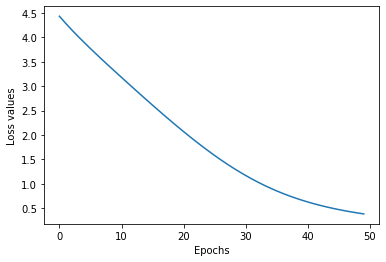

In [23]:
model = CBOW(len(vocab_unique), 100)

loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
#TRAINING
loss= []
for epoch in range(50):
    total_loss = 0
    #Now in this loop we pass the data as a dictionary defined above 
    for idx,(context, target) in enumerate(data_final):
        idxs = [word_to_ix[w] for w in context]
        data_tensored=torch.LongTensor(idxs)
        log_probs = model(data_tensored)
        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))
    
    #optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    loss.append(total_loss / (idx + 1))
losses_values=[]
for i in loss:
    losses_values.append(i.item())
plt.xlabel("Epochs")
plt.ylabel("Loss values")
plt.plot(losses_values)

Reference to this code is in https://towardsdatascience.com/creating-word-embeddings-coding-the-word2vec-algorithm-in-python-using-deep-learning-b337d0ba17a8 and https://github.com/FraLotito/pytorch-continuous-bag-of-words/blob/master/cbow.py